In [1]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [3]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [4]:
num_classes = 5       # 输出的类别总数
patch_size = 16       # 对输入的图像进行切分的大小，表示切分后每个小块的大小
hidden_size = 512     # 隐藏层的维度大小
num_layers = 10       # 编码器中的层数
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # 批次大小
num_epochs = 75    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            #SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads,fropout=dropout_prob):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads,dropout=dropout_prob),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        # self.batch_norm = nn.BatchNorm2d(3)

        self.focus = Focus(3, 12)
        self.vit = ViTModule(12, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(12, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SPPSingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        x = self.focus(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [6]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [7]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

Fold 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Train Loss: 0.9342227530479431
Train Acc (3077): 66.46083847903802%
------Weighted------
Weighted precision 0.6625868302714042
Weighted recall 0.6646083847903802
Weighted f1-score 0.6625060198318165
------Macro------
Macro precision 0.6629646084162435
Macro recall 0.6648405522417234
Macro f1-score 0.6628257325692477


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Val Loss: 0.8664331138134003
Val Acc (162): 67.90123456790124%
------Weighted------
Weighted precision 0.7258817465078713
Weighted recall 0.6790123456790124
Weighted f1-score 0.6849853265419357
------Macro------
Macro precision 0.7266119974559873
Macro recall 0.6782746823069404
Macro f1-score 0.6851565323057948
Training Loss: 0.9342, Training Accuracy: 66.46%
Validation Loss: 0.8664, Validation Accuracy: 67.90%
Epoch 2/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.6825145608186722
Train Acc (3077): 76.21059473513162%
------Weighted------
Weighted precision 0.7605454283622157
Weighted recall 0.7621059473513162
Weighted f1-score 0.7603693374633601
------Macro------
Macro precision 0.7605924158579842
Macro recall 0.762258053881103
Macro f1-score 0.7604748874601753


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.8356471359729767
Val Acc (162): 69.1358024691358%
------Weighted------
Weighted precision 0.755384399104206
Weighted recall 0.691358024691358
Weighted f1-score 0.6937797072829328
------Macro------
Macro precision 0.7525736582258322
Macro recall 0.6937377810361681
Macro f1-score 0.6928651786567401
Training Loss: 0.6825, Training Accuracy: 76.21%
Validation Loss: 0.8356, Validation Accuracy: 69.14%
Epoch 3/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.4962246346473694
Train Acc (3077): 85.05037374065648%
------Weighted------
Weighted precision 0.8499482675927169
Weighted recall 0.8505037374065648
Weighted f1-score 0.8501068913301858
------Macro------
Macro precision 0.8500708582136689
Macro recall 0.8508195221620932
Macro f1-score 0.8503271322387398


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.909148097038269
Val Acc (162): 71.60493827160494%
------Weighted------
Weighted precision 0.7902998236331569
Weighted recall 0.7160493827160493
Weighted f1-score 0.709733262802736
------Macro------
Macro precision 0.7863492063492064
Macro recall 0.719116568914956
Macro f1-score 0.7090625442581517
Training Loss: 0.4962, Training Accuracy: 85.05%
Validation Loss: 0.9091, Validation Accuracy: 71.60%
Epoch 4/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.3648959708213806
Train Acc (3077): 89.21026974325642%
------Weighted------
Weighted precision 0.8914832550297269
Weighted recall 0.8921026974325642
Weighted f1-score 0.8913989327586795
------Macro------
Macro precision 0.8916589177106531
Macro recall 0.892525159823213
Macro f1-score 0.891703395082694


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.8232867121696472
Val Acc (162): 75.30864197530865%
------Weighted------
Weighted precision 0.8468539881715352
Weighted recall 0.7530864197530864
Weighted f1-score 0.7443880306164263
------Macro------
Macro precision 0.8428051001821494
Macro recall 0.7556695992179864
Macro f1-score 0.7436895036847389
Training Loss: 0.3649, Training Accuracy: 89.21%
Validation Loss: 0.8233, Validation Accuracy: 75.31%
Epoch 5/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.27098962604999544
Train Acc (3077): 92.88267793305167%
------Weighted------
Weighted precision 0.9285030078626174
Weighted recall 0.9288267793305167
Weighted f1-score 0.9284500907209172
------Macro------
Macro precision 0.9286939305495723
Macro recall 0.9292085625017913
Macro f1-score 0.9287394140191948


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.6673444211483002
Val Acc (162): 75.92592592592592%
------Weighted------
Weighted precision 0.8224600484657956
Weighted recall 0.7592592592592593
Weighted f1-score 0.7601800850814063
------Macro------
Macro precision 0.8197480106100796
Macro recall 0.7621212121212121
Macro f1-score 0.7601820298951752
Training Loss: 0.2710, Training Accuracy: 92.88%
Validation Loss: 0.6673, Validation Accuracy: 75.93%
Epoch 6/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.20119855105876921
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9554174783761464
Weighted recall 0.9554761130971726
Weighted f1-score 0.9552136728259677
------Macro------
Macro precision 0.9554976597132232
Macro recall 0.9558573795664171
Macro f1-score 0.9554473028528537


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.449619323015213
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8900486896118617
Weighted recall 0.8827160493827161
Weighted f1-score 0.8834059533656308
------Macro------
Macro precision 0.888644540942928
Macro recall 0.8835105083088954
Macro f1-score 0.8830122297057781
Training Loss: 0.2012, Training Accuracy: 95.55%
Validation Loss: 0.4496, Validation Accuracy: 88.27%
|0.27098962604999544 - 0.20119855105876921| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.4967756462097168
Train Acc (3077): 83.23041923951901%
------Weighted------
Weighted precision 0.831618805229893
Weighted recall 0.8323041923951902
Weighted f1-score 0.8318030808557128
------Macro------
Macro precision 0.8320238467488691
Macro recall 0.8327643253181757
Macro f1-score 0.8322355033493286


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.3906612694263458
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8755848112841313
Weighted recall 0.8765432098765432
Weighted f1-score 0.8753990018094334
------Macro------
Macro precision 0.8755375214601969
Macro recall 0.8766801075268817
Macro f1-score 0.8754518722912049
Training Loss: 0.4968, Training Accuracy: 83.23%
Validation Loss: 0.3907, Validation Accuracy: 87.65%
Epoch 8/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.384585018157959
Train Acc (3077): 88.04029899252518%
------Weighted------
Weighted precision 0.8798090406527974
Weighted recall 0.8804029899252519
Weighted f1-score 0.8797627144654068
------Macro------
Macro precision 0.8800844614901807
Macro recall 0.8808048422420847
Macro f1-score 0.8801064928738154


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Val Loss: 0.4610593914985657
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8843411760172333
Weighted recall 0.8827160493827161
Weighted f1-score 0.8801101907333047
------Macro------
Macro precision 0.8838765163308773
Macro recall 0.8831317204301076
Macro f1-score 0.8800951808977254
Training Loss: 0.3846, Training Accuracy: 88.04%
Validation Loss: 0.4611, Validation Accuracy: 88.27%
Epoch 9/75


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Train Loss: 0.2401587611436844
Train Acc (3077): 93.72765680857978%
------Weighted------
Weighted precision 0.9370973467510119
Weighted recall 0.9372765680857978
Weighted f1-score 0.9371381971770855
------Macro------
Macro precision 0.9372379412660911
Macro recall 0.9375905716274305
Macro f1-score 0.9373659823438552


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.45612800121307373
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8506628289766691
Weighted recall 0.845679012345679
Weighted f1-score 0.8432366472874906
------Macro------
Macro precision 0.8493569783043468
Macro recall 0.8467680840664713
Macro f1-score 0.8431072609974961
Training Loss: 0.2402, Training Accuracy: 93.73%
Validation Loss: 0.4561, Validation Accuracy: 84.57%
Epoch 10/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.1652163165807724
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681847969779155
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681522858034903
------Macro------
Macro precision 0.9681896662495968
Macro recall 0.9682535908024381
Macro f1-score 0.9682062700523069


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.34302446246147156
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9019786155202822
Weighted recall 0.9012345679012346
Weighted f1-score 0.8995550942781201
------Macro------
Macro precision 0.9014285714285715
Macro recall 0.9020833333333333
Macro f1-score 0.8996997766778385
Training Loss: 0.1652, Training Accuracy: 96.82%
Validation Loss: 0.3430, Validation Accuracy: 90.12%
Epoch 11/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.12481387704610825
Train Acc (3077): 98.21254468638284%
------Weighted------
Weighted precision 0.9821329482026488
Weighted recall 0.9821254468638284
Weighted f1-score 0.9821157651385343
------Macro------
Macro precision 0.98216424392114
Macro recall 0.9822265221270143
Macro f1-score 0.982182079824257


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.3185298591852188
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9039775202782969
Weighted recall 0.9012345679012346
Weighted f1-score 0.8994953948657652
------Macro------
Macro precision 0.9043792975244587
Macro recall 0.9018817204301076
Macro f1-score 0.90007215007215
Training Loss: 0.1248, Training Accuracy: 98.21%
Validation Loss: 0.3185, Validation Accuracy: 90.12%
|0.1652163165807724 - 0.12481387704610825| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.3498923683166504
Train Acc (3077): 88.0727981800455%
------Weighted------
Weighted precision 0.880234196361868
Weighted recall 0.880727981800455
Weighted f1-score 0.880086711249434
------Macro------
Macro precision 0.8806103171447093
Macro recall 0.8812111702432468
Macro f1-score 0.8805206376767929


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.3351878821849823
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9179282457060235
Weighted recall 0.9135802469135802
Weighted f1-score 0.9136339237788513
------Macro------
Macro precision 0.9189875589875591
Macro recall 0.9140151515151516
Macro f1-score 0.9143961352657005
Training Loss: 0.3499, Training Accuracy: 88.07%
Validation Loss: 0.3352, Validation Accuracy: 91.36%
Epoch 13/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.2554152542352676
Train Acc (3077): 93.56516087097823%
------Weighted------
Weighted precision 0.9354769440415323
Weighted recall 0.9356516087097823
Weighted f1-score 0.9355368484237495
------Macro------
Macro precision 0.9356220013764348
Macro recall 0.9358584728704571
Macro f1-score 0.9357132050416859


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.42168861627578735
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8886296145555406
Weighted recall 0.8827160493827161
Weighted f1-score 0.882264506758498
------Macro------
Macro precision 0.8896574632058503
Macro recall 0.8835105083088954
Macro f1-score 0.8832321315623023
Training Loss: 0.2554, Training Accuracy: 93.57%
Validation Loss: 0.4217, Validation Accuracy: 88.27%
Epoch 14/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.18582899391651153
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9552157254915511
Weighted recall 0.9551511212219694
Weighted f1-score 0.955160871789283
------Macro------
Macro precision 0.9553925907725361
Macro recall 0.9553989953624269
Macro f1-score 0.9553734483156667


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.28326036036014557
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9287496391538606
Weighted recall 0.9259259259259259
Weighted f1-score 0.9248599959445983
------Macro------
Macro precision 0.928435351983739
Macro recall 0.9261363636363636
Macro f1-score 0.9247725039637344
Training Loss: 0.1858, Training Accuracy: 95.52%
Validation Loss: 0.2833, Validation Accuracy: 92.59%
|0.2554152542352676 - 0.18582899391651153| < 0.07
new rng
Epoch 15/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.3314227193593979
Train Acc (3077): 89.89275268118297%
------Weighted------
Weighted precision 0.8986051027857428
Weighted recall 0.8989275268118297
Weighted f1-score 0.8986392372798226
------Macro------
Macro precision 0.8987489658985091
Macro recall 0.8993346617228217
Macro f1-score 0.8989149700496188


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.20958498120307922
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9357930497965815
Weighted recall 0.9320987654320988
Weighted f1-score 0.9328604154663808
------Macro------
Macro precision 0.9359503478810879
Macro recall 0.932172531769306
Macro f1-score 0.9329640823034151
Training Loss: 0.3314, Training Accuracy: 89.89%
Validation Loss: 0.2096, Validation Accuracy: 93.21%
Epoch 16/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.24047415018081664
Train Acc (3077): 93.53266168345792%
------Weighted------
Weighted precision 0.9351134840116491
Weighted recall 0.9353266168345792
Weighted f1-score 0.9351890270721004
------Macro------
Macro precision 0.9354849351599872
Macro recall 0.9357223504354375
Macro f1-score 0.9355727377065


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.2533455118536949
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9038792226292227
Weighted recall 0.9012345679012346
Weighted f1-score 0.8998513876958555
------Macro------
Macro precision 0.9042632367632366
Macro recall 0.9016923264907136
Macro f1-score 0.9003130572934909
Training Loss: 0.2405, Training Accuracy: 93.53%
Validation Loss: 0.2533, Validation Accuracy: 90.12%
Epoch 17/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.148305085003376
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665052041678327
Weighted recall 0.9665258368540787
Weighted f1-score 0.9663861349702336
------Macro------
Macro precision 0.9665705381259911
Macro recall 0.9668270490031551
Macro f1-score 0.9665708857837452


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.24731044471263885
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9008182484463321
Weighted recall 0.9012345679012346
Weighted f1-score 0.9006069244846764
------Macro------
Macro precision 0.9008620222282462
Macro recall 0.9011119257086999
Macro f1-score 0.9005738565687871
Training Loss: 0.1483, Training Accuracy: 96.65%
Validation Loss: 0.2473, Validation Accuracy: 90.12%
Epoch 18/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.09155662730336189
Train Acc (3077): 98.92752681182971%
------Weighted------
Weighted precision 0.9892703627274431
Weighted recall 0.989275268118297
Weighted f1-score 0.989269463345926
------Macro------
Macro precision 0.9893103039393927
Macro recall 0.9893688764970573
Macro f1-score 0.9893362650078501


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.18777769058942795
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9237153077022358
Weighted recall 0.9197530864197531
Weighted f1-score 0.9191694154380722
------Macro------
Macro precision 0.9235856695059731
Macro recall 0.9198619257087
Macro f1-score 0.9192043680921872
Training Loss: 0.0916, Training Accuracy: 98.93%
Validation Loss: 0.1878, Validation Accuracy: 91.98%
|0.148305085003376 - 0.09155662730336189| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.2850864678621292
Train Acc (3077): 91.84270393240169%
------Weighted------
Weighted precision 0.9181436136950013
Weighted recall 0.9184270393240169
Weighted f1-score 0.9182056631260994
------Macro------
Macro precision 0.9183391515094005
Macro recall 0.9186956143162803
Macro f1-score 0.9184384436932073


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.2559327483177185
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9454089506172839
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444165568423112
------Macro------
Macro precision 0.9458333333333332
Macro recall 0.944495356793744
Macro f1-score 0.9446602746861122
Training Loss: 0.2851, Training Accuracy: 91.84%
Validation Loss: 0.2559, Validation Accuracy: 94.44%
Epoch 20/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.18818325400352479
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638334955914283
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638467494519781
------Macro------
Macro precision 0.9638790225404504
Macro recall 0.9640870406383548
Macro f1-score 0.963950212211949


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.31367579847574234
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446796002351558
Weighted recall 0.9444444444444444
Weighted f1-score 0.9441167217328578
------Macro------
Macro precision 0.9449025974025973
Macro recall 0.9446969696969697
Macro f1-score 0.944353870881385
Training Loss: 0.1882, Training Accuracy: 96.39%
Validation Loss: 0.3137, Validation Accuracy: 94.44%
Epoch 21/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.23641068398952483
Train Acc (3077): 94.18264543386415%
------Weighted------
Weighted precision 0.9421546699906054
Weighted recall 0.9418264543386415
Weighted f1-score 0.9418883168505732
------Macro------
Macro precision 0.9425171797842052
Macro recall 0.9419005187328547
Macro f1-score 0.9421079083450985


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.4160732179880142
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9189805322000134
Weighted recall 0.9135802469135802
Weighted f1-score 0.9140150699900619
------Macro------
Macro precision 0.92002071299984
Macro recall 0.9136241446725318
Macro f1-score 0.9145716431503683
Training Loss: 0.2364, Training Accuracy: 94.18%
Validation Loss: 0.4161, Validation Accuracy: 91.36%
|0.18818325400352479 - 0.23641068398952483| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.3248904556035995
Train Acc (3077): 91.03022424439389%
------Weighted------
Weighted precision 0.9101354152028942
Weighted recall 0.9103022424439389
Weighted f1-score 0.9101438372339308
------Macro------
Macro precision 0.9103071427445382
Macro recall 0.9104666850419173
Macro f1-score 0.9103128625912271


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.24515336006879807
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9141889507306065
Weighted recall 0.9012345679012346
Weighted f1-score 0.9011661671531798
------Macro------
Macro precision 0.9147390506163126
Macro recall 0.9018695014662758
Macro f1-score 0.901846093050454
Training Loss: 0.3249, Training Accuracy: 91.03%
Validation Loss: 0.2452, Validation Accuracy: 90.12%
Epoch 23/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.25410198390483857
Train Acc (3077): 93.5001624959376%
------Weighted------
Weighted precision 0.9350746971078516
Weighted recall 0.935001624959376
Weighted f1-score 0.9348106991206118
------Macro------
Macro precision 0.9349411884158819
Macro recall 0.9350525909734462
Macro f1-score 0.9347683756458599


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.2348165139555931
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.917003478346071
Weighted recall 0.9135802469135802
Weighted f1-score 0.9129598144767397
------Macro------
Macro precision 0.916542809042809
Macro recall 0.9140029325513197
Macro f1-score 0.9129701378516127
Training Loss: 0.2541, Training Accuracy: 93.50%
Validation Loss: 0.2348, Validation Accuracy: 91.36%
Epoch 24/75


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.14377461671829223
Train Acc (3077): 97.72505687357815%
------Weighted------
Weighted precision 0.9772686087313822
Weighted recall 0.9772505687357816
Weighted f1-score 0.9771703367867731
------Macro------
Macro precision 0.977199095762136
Macro recall 0.9773252324538383
Macro f1-score 0.9771741714708495


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.2065139338374138
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9454089506172839
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444165568423112
------Macro------
Macro precision 0.9458333333333332
Macro recall 0.944495356793744
Macro f1-score 0.9446602746861122
Training Loss: 0.1438, Training Accuracy: 97.73%
Validation Loss: 0.2065, Validation Accuracy: 94.44%
Epoch 25/75


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


Train Loss: 0.09114863514900208
Train Acc (3077): 99.31751706207345%
------Weighted------
Weighted precision 0.9932003483290257
Weighted recall 0.9931751706207345
Weighted f1-score 0.9931699971305452
------Macro------
Macro precision 0.9931345747538092
Macro recall 0.9932027347982079
Macro f1-score 0.9931510624686076


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


Val Loss: 0.18010732531547546
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9580567580567582
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569655961842959
------Macro------
Macro precision 0.9582683982683982
Macro recall 0.9568059628543499
Macro f1-score 0.9570831310284058
Training Loss: 0.0911, Training Accuracy: 99.32%
Validation Loss: 0.1801, Validation Accuracy: 95.68%
|0.14377461671829223 - 0.09114863514900208| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Train Loss: 0.2204222583770752
Train Acc (3077): 92.65518362040949%
------Weighted------
Weighted precision 0.9263468898021643
Weighted recall 0.9265518362040949
Weighted f1-score 0.9263679391276028
------Macro------
Macro precision 0.9265314727660305
Macro recall 0.9268329645424214
Macro f1-score 0.9266016768405224


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


Val Loss: 0.16707126796245575
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.2204, Training Accuracy: 92.66%
Validation Loss: 0.1671, Validation Accuracy: 95.06%
Epoch 27/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.10840238675475121
Train Acc (3077): 98.3750406239844%
------Weighted------
Weighted precision 0.9837448843205203
Weighted recall 0.983750406239844
Weighted f1-score 0.9837355214957042
------Macro------
Macro precision 0.9837410664542512
Macro recall 0.9837593830207195
Macro f1-score 0.9837381140672458


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Val Loss: 0.16157078742980957
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9580567580567582
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569655961842959
------Macro------
Macro precision 0.9582683982683982
Macro recall 0.9568059628543499
Macro f1-score 0.9570831310284058
Training Loss: 0.1084, Training Accuracy: 98.38%
Validation Loss: 0.1616, Validation Accuracy: 95.68%
Epoch 28/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.08216739371418953
Train Acc (3077): 99.4475138121547%
------Weighted------
Weighted precision 0.9945006186604847
Weighted recall 0.994475138121547
Weighted f1-score 0.994480801722023
------Macro------
Macro precision 0.9945454734447274
Macro recall 0.994485746299272
Macro f1-score 0.9945084967709127


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.14927417784929276
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9587872185911401
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571368919990396
------Macro------
Macro precision 0.9588235294117646
Macro recall 0.9564149560117302
Macro f1-score 0.9569612166440524
Training Loss: 0.0822, Training Accuracy: 99.45%
Validation Loss: 0.1493, Validation Accuracy: 95.68%
|0.10840238675475121 - 0.08216739371418953| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.28746371269226073
Train Acc (3077): 92.07019824504387%
------Weighted------
Weighted precision 0.920559398088103
Weighted recall 0.9207019824504388
Weighted f1-score 0.9205435013763563
------Macro------
Macro precision 0.920903998611497
Macro recall 0.9211182373787183
Macro f1-score 0.9209249020357522


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.2721422165632248
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9080360943866691
Weighted recall 0.9012345679012346
Weighted f1-score 0.9008819166091062
------Macro------
Macro precision 0.9088423645320196
Macro recall 0.9018695014662758
Macro f1-score 0.9016468255276864
Training Loss: 0.2875, Training Accuracy: 92.07%
Validation Loss: 0.2721, Validation Accuracy: 90.12%
Epoch 30/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1590600171685219
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9677607459787755
Weighted recall 0.9671758206044849
Weighted f1-score 0.9669371693796559
------Macro------
Macro precision 0.9677701434202209
Macro recall 0.96746550597387
Macro f1-score 0.967093176548431


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Val Loss: 0.17267369478940964
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.1591, Training Accuracy: 96.72%
Validation Loss: 0.1727, Validation Accuracy: 95.06%
Epoch 31/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.10856145203113556
Train Acc (3077): 98.47253818654534%
------Weighted------
Weighted precision 0.9847211707527181
Weighted recall 0.9847253818654533
Weighted f1-score 0.984713497420878
------Macro------
Macro precision 0.9847798877708787
Macro recall 0.9848329769297954
Macro f1-score 0.9847967419179247


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.16282133758068085
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.1086, Training Accuracy: 98.47%
Validation Loss: 0.1628, Validation Accuracy: 95.06%
|0.1590600171685219 - 0.10856145203113556| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.2014946410059929
Train Acc (3077): 93.59766005849853%
------Weighted------
Weighted precision 0.9359044078527088
Weighted recall 0.9359766005849853
Weighted f1-score 0.935823455558402
------Macro------
Macro precision 0.9358461180239827
Macro recall 0.9362862248362539
Macro f1-score 0.9359497600687077


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.10729392245411873
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.2015, Training Accuracy: 93.60%
Validation Loss: 0.1073, Validation Accuracy: 95.06%
Epoch 33/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.17190614998340606
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.950649121191296
Weighted recall 0.9506012349691257
Weighted f1-score 0.9504878516325153
------Macro------
Macro precision 0.950663495563191
Macro recall 0.9507528346053975
Macro f1-score 0.9505708529461157


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.11266621015965939
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457052335524557
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446101707539617
------Macro------
Macro precision 0.9459577922077923
Macro recall 0.9441043499511241
Macro f1-score 0.944560537501714
Training Loss: 0.1719, Training Accuracy: 95.06%
Validation Loss: 0.1127, Validation Accuracy: 94.44%
|0.2014946410059929 - 0.17190614998340606| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.19307632982730866
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9506246990500848
Weighted recall 0.9506012349691257
Weighted f1-score 0.9505703423772415
------Macro------
Macro precision 0.9506351170498586
Macro recall 0.950739370861697
Macro f1-score 0.9506450601076779


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.14965005218982697
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.1931, Training Accuracy: 95.06%
Validation Loss: 0.1497, Validation Accuracy: 95.06%
|0.17190614998340606 - 0.19307632982730866| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.17012160927057265
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.952133042919612
Weighted recall 0.9522261943451413
Weighted f1-score 0.9521240128553787
------Macro------
Macro precision 0.9522183507339619
Macro recall 0.9522934290831391
Macro f1-score 0.9522014908178396


100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


Val Loss: 0.17236992716789246
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636684303350969
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630464366401364
------Macro------
Macro precision 0.9639502164502165
Macro recall 0.962866568914956
Macro f1-score 0.9631408233360983
Training Loss: 0.1701, Training Accuracy: 95.22%
Validation Loss: 0.1724, Validation Accuracy: 96.30%
|0.19307632982730866 - 0.17012160927057265| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.16596281945705413
Train Acc (3077): 94.63763405914852%
------Weighted------
Weighted precision 0.9462971824893225
Weighted recall 0.9463763405914852
Weighted f1-score 0.9462644602240999
------Macro------
Macro precision 0.9463182510716421
Macro recall 0.9466058843512121
Macro f1-score 0.9463903701031396


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.13672972843050957
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696421459862321
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691229008222473
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.9693181818181819
Macro f1-score 0.9693957023368789
Training Loss: 0.1660, Training Accuracy: 94.64%
Validation Loss: 0.1367, Validation Accuracy: 96.91%
|0.17012160927057265 - 0.16596281945705413| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.17402957379817963
Train Acc (3077): 95.09262268443288%
------Weighted------
Weighted precision 0.9509339750382252
Weighted recall 0.9509262268443289
Weighted f1-score 0.9509003186083071
------Macro------
Macro precision 0.9509731842906122
Macro recall 0.9511755096374348
Macro f1-score 0.951044779570573


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.12157218158245087
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9587872185911401
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571368919990396
------Macro------
Macro precision 0.9588235294117646
Macro recall 0.9564149560117302
Macro f1-score 0.9569612166440524
Training Loss: 0.1740, Training Accuracy: 95.09%
Validation Loss: 0.1216, Validation Accuracy: 95.68%
|0.16596281945705413 - 0.17402957379817963| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.15791664749383927
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9561060919064551
Weighted recall 0.9561260968475788
Weighted f1-score 0.9560890460650536
------Macro------
Macro precision 0.9563000134655356
Macro recall 0.9561583786689603
Macro f1-score 0.9562020583920541


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.11661053821444511
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457052335524557
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446101707539617
------Macro------
Macro precision 0.9459577922077923
Macro recall 0.9441043499511241
Macro f1-score 0.944560537501714
Training Loss: 0.1579, Training Accuracy: 95.61%
Validation Loss: 0.1166, Validation Accuracy: 94.44%
|0.17402957379817963 - 0.15791664749383927| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.18995428830385208
Train Acc (3077): 95.48261293467664%
------Weighted------
Weighted precision 0.9547031973006019
Weighted recall 0.9548261293467664
Weighted f1-score 0.9547369531176193
------Macro------
Macro precision 0.9548270092378857
Macro recall 0.9550677594483752
Macro f1-score 0.9549199660244353


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.09405301697552204
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.1900, Training Accuracy: 95.48%
Validation Loss: 0.0941, Validation Accuracy: 95.06%
|0.15791664749383927 - 0.18995428830385208| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.18530314445495605
Train Acc (3077): 94.44263893402665%
------Weighted------
Weighted precision 0.9444531893637788
Weighted recall 0.9444263893402665
Weighted f1-score 0.9442384635951662
------Macro------
Macro precision 0.9446425556389484
Macro recall 0.9446441663940355
Macro f1-score 0.9444415907089256


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


Val Loss: 0.13853584975004196
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509613427301337
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9503543499511242
Macro f1-score 0.9508979500891266
Training Loss: 0.1853, Training Accuracy: 94.44%
Validation Loss: 0.1385, Validation Accuracy: 95.06%
|0.18995428830385208 - 0.18530314445495605| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.15774012207984925
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9544130505037999
Weighted recall 0.9545011374715632
Weighted f1-score 0.9544212668775746
------Macro------
Macro precision 0.95447269372027
Macro recall 0.9546308435618993
Macro f1-score 0.9545165359982268


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.12147508561611176
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9587872185911401
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571368919990396
------Macro------
Macro precision 0.9588235294117646
Macro recall 0.9564149560117302
Macro f1-score 0.9569612166440524
Training Loss: 0.1577, Training Accuracy: 95.45%
Validation Loss: 0.1215, Validation Accuracy: 95.68%
|0.18530314445495605 - 0.15774012207984925| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.17644483000040054
Train Acc (3077): 95.1251218719532%
------Weighted------
Weighted precision 0.951150766201037
Weighted recall 0.951251218719532
Weighted f1-score 0.95111589902281
------Macro------
Macro precision 0.9510947142196873
Macro recall 0.9514335405550325
Macro f1-score 0.9511792531034582


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Val Loss: 0.1049719825387001
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9517172679958629
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507857200228675
------Macro------
Macro precision 0.9518605169340464
Macro recall 0.9501649560117302
Macro f1-score 0.9506238040566398
Training Loss: 0.1764, Training Accuracy: 95.13%
Validation Loss: 0.1050, Validation Accuracy: 95.06%
|0.15774012207984925 - 0.17644483000040054| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


Train Loss: 0.23110189646482468
Train Acc (3077): 95.41761455963601%
------Weighted------
Weighted precision 0.9540937475057717
Weighted recall 0.9541761455963601
Weighted f1-score 0.9541010658411988
------Macro------
Macro precision 0.9541599821137693
Macro recall 0.9543463116931781
Macro f1-score 0.9542196921101397


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.10696711391210556
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9570973431188484
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566761265661226
------Macro------
Macro precision 0.9574863845831587
Macro recall 0.9566165689149561
Macro f1-score 0.9567841244793993
Training Loss: 0.2311, Training Accuracy: 95.42%
Validation Loss: 0.1070, Validation Accuracy: 95.68%
|0.17644483000040054 - 0.23110189646482468| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.1629648396372795
Train Acc (3077): 95.38511537211569%
------Weighted------
Weighted precision 0.9539114875130533
Weighted recall 0.9538511537211569
Weighted f1-score 0.9538316200911889
------Macro------
Macro precision 0.9540014653853701
Macro recall 0.9540596369517171
Macro f1-score 0.9539799270217536


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


Val Loss: 0.12845082581043243
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9517172679958629
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507857200228675
------Macro------
Macro precision 0.9518605169340464
Macro recall 0.9501649560117302
Macro f1-score 0.9506238040566398
Training Loss: 0.1630, Training Accuracy: 95.39%
Validation Loss: 0.1285, Validation Accuracy: 95.06%
|0.23110189646482468 - 0.1629648396372795| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.15472499579191207
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9561341623380201
Weighted recall 0.9561260968475788
Weighted f1-score 0.9561043587900021
------Macro------
Macro precision 0.9561096539352579
Macro recall 0.9562522588004232
Macro f1-score 0.956155443724582


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Val Loss: 0.10596378520131111
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9571418845315904
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567813401350634
------Macro------
Macro precision 0.9573529411764706
Macro recall 0.9566165689149561
Macro f1-score 0.956800243737178
Training Loss: 0.1547, Training Accuracy: 95.61%
Validation Loss: 0.1060, Validation Accuracy: 95.68%
|0.1629648396372795 - 0.15472499579191207| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


Train Loss: 0.15507631927728652
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9531175359892482
Weighted recall 0.9532011699707508
Weighted f1-score 0.9531254703966039
------Macro------
Macro precision 0.953289386076283
Macro recall 0.9532572380772093
Macro f1-score 0.953239817890192


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.11460597813129425
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9580567580567582
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569655961842959
------Macro------
Macro precision 0.9582683982683982
Macro recall 0.9568059628543499
Macro f1-score 0.9570831310284058
Training Loss: 0.1551, Training Accuracy: 95.32%
Validation Loss: 0.1146, Validation Accuracy: 95.68%
|0.15472499579191207 - 0.15507631927728652| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.16397883236408234
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.961574398863216
Weighted recall 0.9616509587260319
Weighted f1-score 0.9615611948643245
------Macro------
Macro precision 0.9616443502219518
Macro recall 0.9617878776110974
Macro f1-score 0.9616652766243972


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Val Loss: 0.10334083810448647
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575214976563016
Weighted recall 0.9567901234567902
Weighted f1-score 0.956972691072683
------Macro------
Macro precision 0.9577428698752228
Macro recall 0.9568059628543499
Macro f1-score 0.9570900969188221
Training Loss: 0.1640, Training Accuracy: 96.17%
Validation Loss: 0.1033, Validation Accuracy: 95.68%
|0.15507631927728652 - 0.16397883236408234| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.15848366618156434
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.9522123917107891
Weighted recall 0.9522261943451413
Weighted f1-score 0.9522104267194272
------Macro------
Macro precision 0.9522863581142322
Macro recall 0.9523391958393693
Macro f1-score 0.9523038540963291


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.12517676502466202
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9580567580567582
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569655961842959
------Macro------
Macro precision 0.9582683982683982
Macro recall 0.9568059628543499
Macro f1-score 0.9570831310284058
Training Loss: 0.1585, Training Accuracy: 95.22%
Validation Loss: 0.1252, Validation Accuracy: 95.68%
|0.16397883236408234 - 0.15848366618156434| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Train Loss: 0.22519284188747407
Train Acc (3077): 94.89762755931102%
------Weighted------
Weighted precision 0.9489573272205942
Weighted recall 0.9489762755931102
Weighted f1-score 0.9488589465534493
------Macro------
Macro precision 0.9489563201454703
Macro recall 0.9491800915735359
Macro f1-score 0.9489613795687752


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.14157820492982864
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9570973431188484
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566761265661226
------Macro------
Macro precision 0.9574863845831587
Macro recall 0.9566165689149561
Macro f1-score 0.9567841244793993
Training Loss: 0.2252, Training Accuracy: 94.90%
Validation Loss: 0.1416, Validation Accuracy: 95.68%
|0.15848366618156434 - 0.22519284188747407| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:09<00:00,  2.78it/s]


Train Loss: 0.18556371659040452
Train Acc (3077): 95.02762430939227%
------Weighted------
Weighted precision 0.950236136562831
Weighted recall 0.9502762430939227
Weighted f1-score 0.9502130627513062
------Macro------
Macro precision 0.9503865854934981
Macro recall 0.9503559747835066
Macro f1-score 0.95032841187203


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.10487174801528454
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9587872185911401
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571368919990396
------Macro------
Macro precision 0.9588235294117646
Macro recall 0.9564149560117302
Macro f1-score 0.9569612166440524
Training Loss: 0.1856, Training Accuracy: 95.03%
Validation Loss: 0.1049, Validation Accuracy: 95.68%
|0.22519284188747407 - 0.18556371659040452| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.19045484989881514
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9558528330093903
Weighted recall 0.9558011049723757
Weighted f1-score 0.9556910098500131
------Macro------
Macro precision 0.9558958739602501
Macro recall 0.9560406303120732
Macro f1-score 0.9558332125201356


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.1339297890663147
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9517172679958629
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507857200228675
------Macro------
Macro precision 0.9518605169340464
Macro recall 0.9501649560117302
Macro f1-score 0.9506238040566398
Training Loss: 0.1905, Training Accuracy: 95.58%
Validation Loss: 0.1339, Validation Accuracy: 95.06%
|0.18556371659040452 - 0.19045484989881514| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.1503408071398735
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9587364918018656
Weighted recall 0.9587260318492038
Weighted f1-score 0.9586635523146475
------Macro------
Macro precision 0.9587375883014666
Macro recall 0.9589146488127291
Macro f1-score 0.9587591166830812


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.12527300417423248
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631093775622556
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628516758350286
------Macro------
Macro precision 0.9633891093094128
Macro recall 0.962677174975562
Macro f1-score 0.9628473910343253
Training Loss: 0.1503, Training Accuracy: 95.87%
Validation Loss: 0.1253, Validation Accuracy: 96.30%
|0.19045484989881514 - 0.1503408071398735| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.16238792926073076
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9602423016414974
Weighted recall 0.9603509912252194
Weighted f1-score 0.9602721740250443
------Macro------
Macro precision 0.9604103820048444
Macro recall 0.960560035288012
Macro f1-score 0.9604609810644851


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.1692761555314064
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9569716775599129
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567855923781216
------Macro------
Macro precision 0.9571858288770054
Macro recall 0.9566165689149561
Macro f1-score 0.9568044186667259
Training Loss: 0.1624, Training Accuracy: 96.04%
Validation Loss: 0.1693, Validation Accuracy: 95.68%
|0.1503408071398735 - 0.16238792926073076| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.15959811478853225
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.9581201297318191
Weighted recall 0.9580760480987975
Weighted f1-score 0.9580797062615005
------Macro------
Macro precision 0.9582119367432013
Macro recall 0.9580629795085873
Macro f1-score 0.9581191102543425


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.14390098303556442
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9635127830593517
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630533986459279
------Macro------
Macro precision 0.9636252228163993
Macro recall 0.962866568914956
Macro f1-score 0.9630602461725534
Training Loss: 0.1596, Training Accuracy: 95.81%
Validation Loss: 0.1439, Validation Accuracy: 96.30%
|0.16238792926073076 - 0.15959811478853225| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.14968478590250014
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.960005889849354
Weighted recall 0.9600259993500162
Weighted f1-score 0.9599947924860437
------Macro------
Macro precision 0.960098654840462
Macro recall 0.960164280537431
Macro f1-score 0.9601104410835226


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.16653502732515335
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9635127830593517
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630533986459279
------Macro------
Macro precision 0.9636252228163993
Macro recall 0.962866568914956
Macro f1-score 0.9630602461725534
Training Loss: 0.1497, Training Accuracy: 96.00%
Validation Loss: 0.1665, Validation Accuracy: 96.30%
|0.15959811478853225 - 0.14968478590250014| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1648019441962242
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9589329516264153
Weighted recall 0.9590510237244069
Weighted f1-score 0.958951618413823
------Macro------
Macro precision 0.959048314813519
Macro recall 0.9593077599864518
Macro f1-score 0.959138123730732


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.1928195133805275
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693173565722586
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691312713904672
------Macro------
Macro precision 0.9694964349376114
Macro recall 0.9689271749755621
Macro f1-score 0.969115024727332
Training Loss: 0.1648, Training Accuracy: 95.91%
Validation Loss: 0.1928, Validation Accuracy: 96.91%
|0.14968478590250014 - 0.1648019441962242| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.19025623947381973
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609742529206519
Weighted recall 0.9610009749756256
Weighted f1-score 0.9608993955630625
------Macro------
Macro precision 0.9609746820678511
Macro recall 0.9611251749385004
Macro f1-score 0.9609629867381795


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.11971453949809074
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969680464778504
Weighted recall 0.9691358024691358
Weighted f1-score 0.9692219859090424
------Macro------
Macro precision 0.9698529411764707
Macro recall 0.9689271749755621
Macro f1-score 0.9692040898910241
Training Loss: 0.1903, Training Accuracy: 96.10%
Validation Loss: 0.1197, Validation Accuracy: 96.91%
|0.1648019441962242 - 0.19025623947381973| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.18585116177797317
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9605802498844521
Weighted recall 0.9606759831004225
Weighted f1-score 0.9605767590281983
------Macro------
Macro precision 0.9606200966694571
Macro recall 0.9608688828237334
Macro f1-score 0.9606931784770556


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.19722991436719894
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.963475529100529
Weighted recall 0.9629629629629629
Weighted f1-score 0.962951469878503
------Macro------
Macro precision 0.9637608225108225
Macro recall 0.962866568914956
Macro f1-score 0.9630475832428582
Training Loss: 0.1859, Training Accuracy: 96.07%
Validation Loss: 0.1972, Validation Accuracy: 96.30%
|0.19025623947381973 - 0.18585116177797317| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.13759152114391326
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613195130377447
Weighted recall 0.9613259668508287
Weighted f1-score 0.9613108682003618
------Macro------
Macro precision 0.961388390871365
Macro recall 0.9614208839958543
Macro f1-score 0.9613927565067147


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.12892963364720345
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9511298500881833
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506057908661574
------Macro------
Macro precision 0.9514502164502165
Macro recall 0.95055596285435
Macro f1-score 0.9507369771822521
Training Loss: 0.1376, Training Accuracy: 96.13%
Validation Loss: 0.1289, Validation Accuracy: 95.06%
|0.18585116177797317 - 0.13759152114391326| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.15311725646257401
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.959721471745647
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596474978873712
------Macro------
Macro precision 0.9597779085476603
Macro recall 0.9598964083733682
Macro f1-score 0.959773330372353


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Val Loss: 0.18727323412895203
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9511298500881833
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506057908661574
------Macro------
Macro precision 0.9514502164502165
Macro recall 0.95055596285435
Macro f1-score 0.9507369771822521
Training Loss: 0.1531, Training Accuracy: 95.97%
Validation Loss: 0.1873, Validation Accuracy: 95.06%
|0.13759152114391326 - 0.15311725646257401| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.15671492278575896
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9571301362383163
Weighted recall 0.9571010724731882
Weighted f1-score 0.9569525317110622
------Macro------
Macro precision 0.9571727892626448
Macro recall 0.957384359264665
Macro f1-score 0.9571172600680317


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Val Loss: 0.11439866572618484
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957267550090526
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566718743230644
------Macro------
Macro precision 0.9576534968826241
Macro recall 0.9566165689149561
Macro f1-score 0.9567799495498512
Training Loss: 0.1567, Training Accuracy: 95.71%
Validation Loss: 0.1144, Validation Accuracy: 95.68%
|0.15311725646257401 - 0.15671492278575896| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.21062309235334398
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9530726268097002
Weighted recall 0.9532011699707508
Weighted f1-score 0.9530969569290141
------Macro------
Macro precision 0.9531984539932182
Macro recall 0.953528455832544
Macro f1-score 0.9533237709211473


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.11382163688540459
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9511298500881833
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506057908661574
------Macro------
Macro precision 0.9514502164502165
Macro recall 0.95055596285435
Macro f1-score 0.9507369771822521
Training Loss: 0.2106, Training Accuracy: 95.32%
Validation Loss: 0.1138, Validation Accuracy: 95.06%
|0.15671492278575896 - 0.21062309235334398| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.14783340632915498
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9625822680951034
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625802389667228
------Macro------
Macro precision 0.9625676311688307
Macro recall 0.9627918252264204
Macro f1-score 0.9626558810520207


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.12239162996411324
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957267550090526
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566718743230644
------Macro------
Macro precision 0.9576534968826241
Macro recall 0.9566165689149561
Macro f1-score 0.9567799495498512
Training Loss: 0.1478, Training Accuracy: 96.26%
Validation Loss: 0.1224, Validation Accuracy: 95.68%
|0.21062309235334398 - 0.14783340632915498| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.1635003936290741
Train Acc (3077): 95.84010399740006%
------Weighted------
Weighted precision 0.9583809794150366
Weighted recall 0.9584010399740006
Weighted f1-score 0.9583661339405991
------Macro------
Macro precision 0.9584347696418695
Macro recall 0.9586004158506956
Macro f1-score 0.9584928580250859


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.13028935343027115
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957267550090526
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566718743230644
------Macro------
Macro precision 0.9576534968826241
Macro recall 0.9566165689149561
Macro f1-score 0.9567799495498512
Training Loss: 0.1635, Training Accuracy: 95.84%
Validation Loss: 0.1303, Validation Accuracy: 95.68%
|0.14783340632915498 - 0.1635003936290741| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.19395594507455827
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609974497496165
Weighted recall 0.9610009749756256
Weighted f1-score 0.9609471239322258
------Macro------
Macro precision 0.9610885257567165
Macro recall 0.9612452142860841
Macro f1-score 0.9611149710503663


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.1664864458143711
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457052335524557
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446101707539617
------Macro------
Macro precision 0.9459577922077923
Macro recall 0.9441043499511241
Macro f1-score 0.944560537501714
Training Loss: 0.1940, Training Accuracy: 96.10%
Validation Loss: 0.1665, Validation Accuracy: 94.44%
|0.1635003936290741 - 0.19395594507455827| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.17196119725704193
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9585952191822155
Weighted recall 0.9587260318492038
Weighted f1-score 0.9586329921689519
------Macro------
Macro precision 0.9587392240055201
Macro recall 0.9588270665118179
Macro f1-score 0.9587554365604808


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Val Loss: 0.1071382462978363
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457052335524557
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446101707539617
------Macro------
Macro precision 0.9459577922077923
Macro recall 0.9441043499511241
Macro f1-score 0.944560537501714
Training Loss: 0.1720, Training Accuracy: 95.87%
Validation Loss: 0.1071, Validation Accuracy: 94.44%
|0.19395594507455827 - 0.17196119725704193| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.14878736913204194
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596570273642836
Weighted recall 0.9597010074748131
Weighted f1-score 0.959664965205688
------Macro------
Macro precision 0.9598169167752552
Macro recall 0.9598588460590944
Macro f1-score 0.9598240501624111


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.2081882506608963
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457052335524557
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446101707539617
------Macro------
Macro precision 0.9459577922077923
Macro recall 0.9441043499511241
Macro f1-score 0.944560537501714
Training Loss: 0.1488, Training Accuracy: 95.97%
Validation Loss: 0.2082, Validation Accuracy: 94.44%
|0.17196119725704193 - 0.14878736913204194| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.1399507971853018
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9569710930450417
Weighted recall 0.9571010724731882
Weighted f1-score 0.957004473250959
------Macro------
Macro precision 0.9570182664771453
Macro recall 0.957290940874918
Macro f1-score 0.9571230384170727


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Val Loss: 0.12386072427034378
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957267550090526
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566718743230644
------Macro------
Macro precision 0.9576534968826241
Macro recall 0.9566165689149561
Macro f1-score 0.9567799495498512
Training Loss: 0.1400, Training Accuracy: 95.71%
Validation Loss: 0.1239, Validation Accuracy: 95.68%
|0.14878736913204194 - 0.1399507971853018| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.1760275223851204
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.959453067986703
Weighted recall 0.95937601559961
Weighted f1-score 0.9594086948155548
------Macro------
Macro precision 0.9595899119239709
Macro recall 0.959486206326847
Macro f1-score 0.9595321678794114


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.1499335654079914
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9511298500881833
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506057908661574
------Macro------
Macro precision 0.9514502164502165
Macro recall 0.95055596285435
Macro f1-score 0.9507369771822521
Training Loss: 0.1760, Training Accuracy: 95.94%
Validation Loss: 0.1499, Validation Accuracy: 95.06%
|0.1399507971853018 - 0.1760275223851204| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.1453339272737503
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9644822570750087
Weighted recall 0.9645758856028599
Weighted f1-score 0.9644667738765703
------Macro------
Macro precision 0.964549965027415
Macro recall 0.9646635072776588
Macro f1-score 0.964545306596446


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.08972581941634417
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631093775622556
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628516758350286
------Macro------
Macro precision 0.9633891093094128
Macro recall 0.962677174975562
Macro f1-score 0.9628473910343253
Training Loss: 0.1453, Training Accuracy: 96.46%
Validation Loss: 0.0897, Validation Accuracy: 96.30%
|0.1760275223851204 - 0.1453339272737503| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.15521282017230986
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9626900397976453
Weighted recall 0.9626259343516412
Weighted f1-score 0.9626535128829541
------Macro------
Macro precision 0.9628032647549739
Macro recall 0.9626862083162804
Macro f1-score 0.9627402856441585


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.16417072713375092
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.963475529100529
Weighted recall 0.9629629629629629
Weighted f1-score 0.962951469878503
------Macro------
Macro precision 0.9637608225108225
Macro recall 0.962866568914956
Macro f1-score 0.9630475832428582
Training Loss: 0.1552, Training Accuracy: 96.26%
Validation Loss: 0.1642, Validation Accuracy: 96.30%
|0.1453339272737503 - 0.15521282017230986| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.175952470600605
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9636033989012118
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635754492657737
------Macro------
Macro precision 0.9635911778586583
Macro recall 0.9637081661114755
Macro f1-score 0.9636232259883923


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.18868111819028854
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.963475529100529
Weighted recall 0.9629629629629629
Weighted f1-score 0.962951469878503
------Macro------
Macro precision 0.9637608225108225
Macro recall 0.962866568914956
Macro f1-score 0.9630475832428582
Training Loss: 0.1760, Training Accuracy: 96.36%
Validation Loss: 0.1887, Validation Accuracy: 96.30%
|0.15521282017230986 - 0.175952470600605| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.14450598746538162
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9606493008917725
Weighted recall 0.9606759831004225
Weighted f1-score 0.960658370551107
------Macro------
Macro precision 0.9606899849368922
Macro recall 0.9607574519880151
Macro f1-score 0.9607194683693118


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.10100641660392284
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957267550090526
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566718743230644
------Macro------
Macro precision 0.9576534968826241
Macro recall 0.9566165689149561
Macro f1-score 0.9567799495498512
Training Loss: 0.1445, Training Accuracy: 96.07%
Validation Loss: 0.1010, Validation Accuracy: 95.68%
|0.175952470600605 - 0.14450598746538162| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.15817857712507247
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9543472605959892
Weighted recall 0.9545011374715632
Weighted f1-score 0.9543634107410476
------Macro------
Macro precision 0.9543765419598961
Macro recall 0.954711332939494
Macro f1-score 0.9544835492911636


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.12411337718367577
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.963475529100529
Weighted recall 0.9629629629629629
Weighted f1-score 0.962951469878503
------Macro------
Macro precision 0.9637608225108225
Macro recall 0.962866568914956
Macro f1-score 0.9630475832428582
Training Loss: 0.1582, Training Accuracy: 95.45%
Validation Loss: 0.1241, Validation Accuracy: 96.30%
|0.14450598746538162 - 0.15817857712507247| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.2041654646396637
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9600008410551939
Weighted recall 0.9600259993500162
Weighted f1-score 0.9600029700665597
------Macro------
Macro precision 0.9599880056642649
Macro recall 0.9601018139312577
Macro f1-score 0.9600343849425116


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.15456585958600044
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9576709555876224
Weighted recall 0.9567901234567902
Weighted f1-score 0.9568735971339637
------Macro------
Macro precision 0.9578896103896103
Macro recall 0.9568059628543499
Macro f1-score 0.9569928046880796
Training Loss: 0.2042, Training Accuracy: 96.00%
Validation Loss: 0.1546, Validation Accuracy: 95.68%


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Val Loss: 0.09886518120765686
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9576709555876224
Weighted recall 0.9567901234567902
Weighted f1-score 0.9568735971339637
------Macro------
Macro precision 0.9578896103896103
Macro recall 0.9568059628543499
Macro f1-score 0.9569928046880796
Fold 1, Test Accuracy: 95.68%, Test Loss: 0.0989
Precision: 0.9579, Recall: 0.9568, F1-score: 0.9570
Fold 2


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 1.013588116168976
Train Acc (3077): 63.04842378940526%
------Weighted------
Weighted precision 0.6260901116415071
Weighted recall 0.6304842378940526
Weighted f1-score 0.6268459317081405
------Macro------
Macro precision 0.6264035576444945
Macro recall 0.6315354589470854
Macro f1-score 0.6275412838643295


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


Val Loss: 1.1755788326263428
Val Acc (162): 53.08641975308642%
------Weighted------
Weighted precision 0.6253992598359615
Weighted recall 0.5308641975308642
Weighted f1-score 0.49724188027764205
------Macro------
Macro precision 0.6262142474250487
Macro recall 0.5326551808406648
Macro f1-score 0.4993964050133347
Training Loss: 1.0136, Training Accuracy: 63.05%
Validation Loss: 1.1756, Validation Accuracy: 53.09%
Epoch 2/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.7338706189393998
Train Acc (3077): 73.93565160870978%
------Weighted------
Weighted precision 0.7377745320805303
Weighted recall 0.7393565160870978
Weighted f1-score 0.73625587504823
------Macro------
Macro precision 0.7380181678179754
Macro recall 0.7406190599969968
Macro f1-score 0.7370292962637632


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.9554497599601746
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.7304803402842618
Weighted recall 0.6481481481481481
Weighted f1-score 0.6440947820901647
------Macro------
Macro precision 0.7292436974789915
Macro recall 0.6493829423264907
Macro f1-score 0.6437917894584408
Training Loss: 0.7339, Training Accuracy: 73.94%
Validation Loss: 0.9554, Validation Accuracy: 64.81%
Epoch 3/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.5419372576475143
Train Acc (3077): 81.83295417614559%
------Weighted------
Weighted precision 0.8181606350989227
Weighted recall 0.818329541761456
Weighted f1-score 0.816521891242433
------Macro------
Macro precision 0.8184838232607469
Macro recall 0.8195973467061805
Macro f1-score 0.817326511286644


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.7346621751785278
Val Acc (162): 75.92592592592592%
------Weighted------
Weighted precision 0.8057554379776601
Weighted recall 0.7592592592592593
Weighted f1-score 0.7611968538308976
------Macro------
Macro precision 0.8036190476190477
Macro recall 0.760392228739003
Macro f1-score 0.7603816376855332
Training Loss: 0.5419, Training Accuracy: 81.83%
Validation Loss: 0.7347, Validation Accuracy: 75.93%
Epoch 4/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.3971055646240711
Train Acc (3077): 88.52778680532987%
------Weighted------
Weighted precision 0.8852739178717811
Weighted recall 0.8852778680532987
Weighted f1-score 0.8843370893157764
------Macro------
Macro precision 0.8853658556938033
Macro recall 0.886193995331942
Macro f1-score 0.8848465789646663


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.6734401881694794
Val Acc (162): 79.62962962962963%
------Weighted------
Weighted precision 0.8161262605707049
Weighted recall 0.7962962962962963
Weighted f1-score 0.7970490154123041
------Macro------
Macro precision 0.8150183150183151
Macro recall 0.7975134408602151
Macro f1-score 0.7969944547936941
Training Loss: 0.3971, Training Accuracy: 88.53%
Validation Loss: 0.6734, Validation Accuracy: 79.63%
Epoch 5/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.29861449539661405
Train Acc (3077): 92.20019499512512%
------Weighted------
Weighted precision 0.9219460373899829
Weighted recall 0.9220019499512512
Weighted f1-score 0.9214433782045828
------Macro------
Macro precision 0.922035297393798
Macro recall 0.9226544220737534
Macro f1-score 0.9218195575631267


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.5967771708965302
Val Acc (162): 85.18518518518519%
------Weighted------
Weighted precision 0.8715967667130458
Weighted recall 0.8518518518518519
Weighted f1-score 0.8524831408752744
------Macro------
Macro precision 0.8697819699680165
Macro recall 0.8524499022482894
Macro f1-score 0.8517024726501561
Training Loss: 0.2986, Training Accuracy: 92.20%
Validation Loss: 0.5968, Validation Accuracy: 85.19%
Epoch 6/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.24853164076805115
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.949689436215182
Weighted recall 0.9496262593435164
Weighted f1-score 0.9494580984828043
------Macro------
Macro precision 0.9497837798174864
Macro recall 0.9500766112115802
Macro f1-score 0.9497325177596746


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Val Loss: 0.3854239135980606
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8879997069580403
Weighted recall 0.8827160493827161
Weighted f1-score 0.8809411958837247
------Macro------
Macro precision 0.88775351000351
Macro recall 0.8840786901270773
Macro f1-score 0.8815377725722552
Training Loss: 0.2485, Training Accuracy: 94.96%
Validation Loss: 0.3854, Validation Accuracy: 88.27%
|0.29861449539661405 - 0.24853164076805115| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.632748214006424
Train Acc (3077): 80.33799155021124%
------Weighted------
Weighted precision 0.801426855678616
Weighted recall 0.8033799155021124
Weighted f1-score 0.8017496910799419
------Macro------
Macro precision 0.802013195285981
Macro recall 0.8046236574867285
Macro f1-score 0.8026662421464514


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.4392192214727402
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.845784231200898
Weighted recall 0.845679012345679
Weighted f1-score 0.8454030151946819
------Macro------
Macro precision 0.8458333333333334
Macro recall 0.8465664711632455
Macro f1-score 0.8458653846153845
Training Loss: 0.6327, Training Accuracy: 80.34%
Validation Loss: 0.4392, Validation Accuracy: 84.57%
Epoch 8/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.5002969789505005
Train Acc (3077): 85.21286967825804%
------Weighted------
Weighted precision 0.8503654085155546
Weighted recall 0.8521286967825804
Weighted f1-score 0.8503446642300492
------Macro------
Macro precision 0.8508993574373775
Macro recall 0.8531587494170697
Macro f1-score 0.8511355351551899


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.3805742561817169
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8839869281045752
Weighted recall 0.8765432098765432
Weighted f1-score 0.8721360517673072
------Macro------
Macro precision 0.8830659536541889
Macro recall 0.8780180840664711
Macro f1-score 0.872481443052119
Training Loss: 0.5003, Training Accuracy: 85.21%
Validation Loss: 0.3806, Validation Accuracy: 87.65%
Epoch 9/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.3369349020719528
Train Acc (3077): 90.41273968150796%
------Weighted------
Weighted precision 0.903519273708063
Weighted recall 0.9041273968150796
Weighted f1-score 0.9035836989518157
------Macro------
Macro precision 0.9039279164152774
Macro recall 0.9049056636984876
Macro f1-score 0.9041792144788943


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.38303086161613464
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8530097867611772
Weighted recall 0.845679012345679
Weighted f1-score 0.842862829034967
------Macro------
Macro precision 0.8522277906382467
Macro recall 0.846590909090909
Macro f1-score 0.8428011333422152
Training Loss: 0.3369, Training Accuracy: 90.41%
Validation Loss: 0.3830, Validation Accuracy: 84.57%
Epoch 10/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.23567882895469666
Train Acc (3077): 94.93012674683133%
------Weighted------
Weighted precision 0.9492049688981937
Weighted recall 0.9493012674683133
Weighted f1-score 0.9491606018858378
------Macro------
Macro precision 0.9492607992450551
Macro recall 0.9495900152881489
Macro f1-score 0.9493337387537201


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Val Loss: 0.36162880063056946
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8809148923480646
Weighted recall 0.8765432098765432
Weighted f1-score 0.8723096982900904
------Macro------
Macro precision 0.8801700232135016
Macro recall 0.8778286901270771
Macro f1-score 0.872638146167558
Training Loss: 0.2357, Training Accuracy: 94.93%
Validation Loss: 0.3616, Validation Accuracy: 87.65%
Epoch 11/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.20317053020000458
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9564762113133216
Weighted recall 0.956451088722782
Weighted f1-score 0.9563197302976134
------Macro------
Macro precision 0.9565651655652074
Macro recall 0.9568366215035089
Macro f1-score 0.9565584383042893


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.3182009160518646
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9055430272607202
Weighted recall 0.9012345679012346
Weighted f1-score 0.9001889721520002
------Macro------
Macro precision 0.9050768260520583
Macro recall 0.9018817204301076
Macro f1-score 0.9003137414228963
Training Loss: 0.2032, Training Accuracy: 95.65%
Validation Loss: 0.3182, Validation Accuracy: 90.12%
|0.23567882895469666 - 0.20317053020000458| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.4813102650642395
Train Acc (3077): 84.98537536561587%
------Weighted------
Weighted precision 0.8486764879935793
Weighted recall 0.8498537536561586
Weighted f1-score 0.8485633631131305
------Macro------
Macro precision 0.8490118008536681
Macro recall 0.8508989030796308
Macro f1-score 0.8492565471236405


100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Val Loss: 0.2550187259912491
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9203006770211072
Weighted recall 0.9197530864197531
Weighted f1-score 0.9194269249120296
------Macro------
Macro precision 0.9207722385141741
Macro recall 0.9200635386119258
Macro f1-score 0.9198274823976087
Training Loss: 0.4813, Training Accuracy: 84.99%
Validation Loss: 0.2550, Validation Accuracy: 91.98%
Epoch 13/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.391042605638504
Train Acc (3077): 87.35781605459863%
------Weighted------
Weighted precision 0.8738325737333913
Weighted recall 0.8735781605459864
Weighted f1-score 0.873008823719253
------Macro------
Macro precision 0.8739392267807616
Macro recall 0.8741332938104922
Macro f1-score 0.8733485340094266


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.31521622836589813
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.877434554068541
Weighted recall 0.8765432098765432
Weighted f1-score 0.8745007149481083
------Macro------
Macro precision 0.8772268907563024
Macro recall 0.8780180840664711
Macro f1-score 0.8751371067207506
Training Loss: 0.3910, Training Accuracy: 87.36%
Validation Loss: 0.3152, Validation Accuracy: 87.65%
Epoch 14/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.212441041469574
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.9498268380195563
Weighted recall 0.9496262593435164
Weighted f1-score 0.9495607211038971
------Macro------
Macro precision 0.9496744862033297
Macro recall 0.9499344876083897
Macro f1-score 0.9496391341731891


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.2652621269226074
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9153296068630009
Weighted recall 0.9135802469135802
Weighted f1-score 0.9128880967486754
------Macro------
Macro precision 0.9150520367583443
Macro recall 0.9141923264907137
Macro f1-score 0.9130585481216617
Training Loss: 0.2124, Training Accuracy: 94.96%
Validation Loss: 0.2653, Validation Accuracy: 91.36%
Epoch 15/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.14247088819742204
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.9732366811506659
Weighted recall 0.973025674358141
Weighted f1-score 0.9730054215383479
------Macro------
Macro precision 0.9730647555777072
Macro recall 0.973253067747694
Macro f1-score 0.9730337264425764


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.28734995424747467
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9206931169520776
Weighted recall 0.9197530864197531
Weighted f1-score 0.9194704274278062
------Macro------
Macro precision 0.9209734441186054
Macro recall 0.9200635386119258
Macro f1-score 0.9197708906334434
Training Loss: 0.1425, Training Accuracy: 97.30%
Validation Loss: 0.2873, Validation Accuracy: 91.98%
|0.212441041469574 - 0.14247088819742204| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.39362951159477233
Train Acc (3077): 87.0003249918752%
------Weighted------
Weighted precision 0.8695421877555074
Weighted recall 0.870003249918752
Weighted f1-score 0.8695529960048876
------Macro------
Macro precision 0.8698804254563001
Macro recall 0.8706852278749361
Macro f1-score 0.8700647395502379


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.2014671117067337
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.951672567175018
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9511029411764707
Macro recall 0.9511363636363637
Macro f1-score 0.950576923076923
Training Loss: 0.3936, Training Accuracy: 87.00%
Validation Loss: 0.2015, Validation Accuracy: 95.06%
Epoch 17/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.2325814360380173
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.955318463091803
Weighted recall 0.9554761130971726
Weighted f1-score 0.9553469507293197
------Macro------
Macro precision 0.9554992998444517
Macro recall 0.9558233511080936
Macro f1-score 0.9556114651502879


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.2090025544166565
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9324981844589688
Weighted recall 0.9320987654320988
Weighted f1-score 0.931497309275087
------Macro------
Macro precision 0.932087789661319
Macro recall 0.9327651515151516
Macro f1-score 0.9316151903651904
Training Loss: 0.2326, Training Accuracy: 95.55%
Validation Loss: 0.2090, Validation Accuracy: 93.21%
Epoch 18/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.14740926146507263
Train Acc (3077): 98.24504387390316%
------Weighted------
Weighted precision 0.9824757968354718
Weighted recall 0.9824504387390315
Weighted f1-score 0.9824600441123353
------Macro------
Macro precision 0.9825271098769159
Macro recall 0.9825370386527466
Macro f1-score 0.9825290528174909


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Val Loss: 0.2786146029829979
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8959795438395481
Weighted recall 0.8950617283950617
Weighted f1-score 0.8949101565054061
------Macro------
Macro precision 0.8957955264217123
Macro recall 0.8952407135874878
Macro f1-score 0.8949025036109773
Training Loss: 0.1474, Training Accuracy: 98.25%
Validation Loss: 0.2786, Validation Accuracy: 89.51%
Epoch 19/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.26009729266166687
Train Acc (3077): 93.72765680857978%
------Weighted------
Weighted precision 0.9373839509639804
Weighted recall 0.9372765680857978
Weighted f1-score 0.9368537169866702
------Macro------
Macro precision 0.9371364491018159
Macro recall 0.9376950630861103
Macro f1-score 0.9369420845392276


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.2113739252090454
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9212288345074775
Weighted recall 0.9135802469135802
Weighted f1-score 0.9150016426711914
------Macro------
Macro precision 0.9218520578420467
Macro recall 0.9138135386119257
Macro f1-score 0.9154605811232732
Training Loss: 0.2601, Training Accuracy: 93.73%
Validation Loss: 0.2114, Validation Accuracy: 91.36%
Epoch 20/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.13707337141036988
Train Acc (3077): 97.5625609359766%
------Weighted------
Weighted precision 0.9756633901448266
Weighted recall 0.975625609359766
Weighted f1-score 0.975618277162589
------Macro------
Macro precision 0.9756578850105013
Macro recall 0.9757473947363783
Macro f1-score 0.9756766149537055


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.2367333024740219
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9396638017327672
Weighted recall 0.9382716049382716
Weighted f1-score 0.9378670509818051
------Macro------
Macro precision 0.9399518438450585
Macro recall 0.93805596285435
Macro f1-score 0.9379102547373304
Training Loss: 0.1371, Training Accuracy: 97.56%
Validation Loss: 0.2367, Validation Accuracy: 93.83%
Epoch 21/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.09245164066553116
Train Acc (3077): 99.28501787455313%
------Weighted------
Weighted precision 0.9928836871703637
Weighted recall 0.9928501787455314
Weighted f1-score 0.9928521103615932
------Macro------
Macro precision 0.992836443843234
Macro recall 0.9928828742767145
Macro f1-score 0.9928448960526838


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Val Loss: 0.23959773033857346
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9334944965097294
Weighted recall 0.9320987654320988
Weighted f1-score 0.9321696247349843
------Macro------
Macro precision 0.9332114928082671
Macro recall 0.9323741446725318
Macro f1-score 0.932173023055376
Training Loss: 0.0925, Training Accuracy: 99.29%
Validation Loss: 0.2396, Validation Accuracy: 93.21%
|0.13707337141036988 - 0.09245164066553116| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.32832063555717467
Train Acc (3077): 89.24276893077673%
------Weighted------
Weighted precision 0.8922610878292936
Weighted recall 0.8924276893077673
Weighted f1-score 0.8921750068897243
------Macro------
Macro precision 0.8925992177582247
Macro recall 0.8928604164343742
Macro f1-score 0.8925620212909487


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Val Loss: 0.5221173167228699
Val Acc (162): 78.39506172839506%
------Weighted------
Weighted precision 0.7869285952619286
Weighted recall 0.7839506172839507
Weighted f1-score 0.7758089675421419
------Macro------
Macro precision 0.7883783783783783
Macro recall 0.7855571847507332
Macro f1-score 0.777499184488655
Training Loss: 0.3283, Training Accuracy: 89.24%
Validation Loss: 0.5221, Validation Accuracy: 78.40%
Epoch 23/75


100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Train Loss: 0.26303089141845704
Train Acc (3077): 92.20019499512512%
------Weighted------
Weighted precision 0.9218879379976821
Weighted recall 0.9220019499512512
Weighted f1-score 0.9219311663155462
------Macro------
Macro precision 0.9224542615865996
Macro recall 0.9225859203005389
Macro f1-score 0.9225063675172024


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.19228942692279816
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447788862133546
Weighted recall 0.9382716049382716
Weighted f1-score 0.9384717078040863
------Macro------
Macro precision 0.9447133877474435
Macro recall 0.9384469696969697
Macro f1-score 0.9385173527832874
Training Loss: 0.2630, Training Accuracy: 92.20%
Validation Loss: 0.1923, Validation Accuracy: 93.83%
|0.32832063555717467 - 0.26303089141845704| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.30977883100509646
Train Acc (3077): 90.90022749431265%
------Weighted------
Weighted precision 0.9087621786916602
Weighted recall 0.9090022749431265
Weighted f1-score 0.9083249515475692
------Macro------
Macro precision 0.9088559976328787
Macro recall 0.9097332506596103
Macro f1-score 0.9087420001367882


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Val Loss: 0.3453589379787445
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8792747434959064
Weighted recall 0.8703703703703703
Weighted f1-score 0.8692581393531266
------Macro------
Macro precision 0.8794572129402509
Macro recall 0.8715786901270773
Macro f1-score 0.8700294624863589
Training Loss: 0.3098, Training Accuracy: 90.90%
Validation Loss: 0.3454, Validation Accuracy: 87.04%
|0.26303089141845704 - 0.30977883100509646| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.43211809158325193
Train Acc (3077): 88.10529736756581%
------Weighted------
Weighted precision 0.8806336778212823
Weighted recall 0.8810529736756582
Weighted f1-score 0.8807752817542378
------Macro------
Macro precision 0.8811238932341634
Macro recall 0.8817007517610633
Macro f1-score 0.8813450891494297


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.3509552776813507
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9102385213496326
Weighted recall 0.9012345679012346
Weighted f1-score 0.9021574707127499
------Macro------
Macro precision 0.908927108927109
Macro recall 0.9014907135874879
Macro f1-score 0.9016582088385701
Training Loss: 0.4321, Training Accuracy: 88.11%
Validation Loss: 0.3510, Validation Accuracy: 90.12%
Epoch 26/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.3111587971448898
Train Acc (3077): 91.29021774455639%
------Weighted------
Weighted precision 0.9129221157357236
Weighted recall 0.9129021774455639
Weighted f1-score 0.9125871541619929
------Macro------
Macro precision 0.9131409707268604
Macro recall 0.912946016630749
Macro f1-score 0.9127175037427172


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Val Loss: 0.34028393030166626
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8998911765796297
Weighted recall 0.8888888888888888
Weighted f1-score 0.8860478664400233
------Macro------
Macro precision 0.8989385107032166
Macro recall 0.8897605083088955
Macro f1-score 0.8861178037648626
Training Loss: 0.3112, Training Accuracy: 91.29%
Validation Loss: 0.3403, Validation Accuracy: 88.89%
Epoch 27/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.18438512921333314
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9573090727900575
Weighted recall 0.9571010724731882
Weighted f1-score 0.9571007724017981
------Macro------
Macro precision 0.9573214323222817
Macro recall 0.9573719676871673
Macro f1-score 0.9572434228216675


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.3012075126171112
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9162156909297434
Weighted recall 0.9135802469135802
Weighted f1-score 0.9120386866140855
------Macro------
Macro precision 0.9152526395173455
Macro recall 0.913245356793744
Macro f1-score 0.9113266558454413
Training Loss: 0.1844, Training Accuracy: 95.71%
Validation Loss: 0.3012, Validation Accuracy: 91.36%
Epoch 28/75


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.113358014523983
Train Acc (3077): 98.60253493662658%
------Weighted------
Weighted precision 0.9860778896682727
Weighted recall 0.9860253493662658
Weighted f1-score 0.9860324357977454
------Macro------
Macro precision 0.9860705818181306
Macro recall 0.9860992802559794
Macro f1-score 0.9860659336085519


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.294674277305603
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9167454865259524
Weighted recall 0.9135802469135802
Weighted f1-score 0.9138880346436317
------Macro------
Macro precision 0.915456989247312
Macro recall 0.9138135386119257
Macro f1-score 0.9133215105789733
Training Loss: 0.1134, Training Accuracy: 98.60%
Validation Loss: 0.2947, Validation Accuracy: 91.36%
Epoch 29/75


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.08304712876677513
Train Acc (3077): 99.25251868703282%
------Weighted------
Weighted precision 0.9925372198352902
Weighted recall 0.9925251868703282
Weighted f1-score 0.9925293665934569
------Macro------
Macro precision 0.9925370255848538
Macro recall 0.9925222003432213
Macro f1-score 0.9925277748956056


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.28635333478450775
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9290686900558436
Weighted recall 0.9259259259259259
Weighted f1-score 0.926144173097578
------Macro------
Macro precision 0.9280410596840618
Macro recall 0.9263135386119258
Macro f1-score 0.9258199864651477
Training Loss: 0.0830, Training Accuracy: 99.25%
Validation Loss: 0.2864, Validation Accuracy: 92.59%
|0.113358014523983 - 0.08304712876677513| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.22707899644970894
Train Acc (3077): 92.33019174520636%
------Weighted------
Weighted precision 0.9230590855480468
Weighted recall 0.9233019174520637
Weighted f1-score 0.9229528240287829
------Macro------
Macro precision 0.9232116500525297
Macro recall 0.9236563265241291
Macro f1-score 0.9232097392499167


100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Val Loss: 0.1830148920416832
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9525462962962963
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503703373891935
------Macro------
Macro precision 0.9520833333333334
Macro recall 0.95055596285435
Macro f1-score 0.9501273124958258
Training Loss: 0.2271, Training Accuracy: 92.33%
Validation Loss: 0.1830, Validation Accuracy: 95.06%
Epoch 31/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.17418032109737397
Train Acc (3077): 94.76763080922977%
------Weighted------
Weighted precision 0.947561492903427
Weighted recall 0.9476763080922977
Weighted f1-score 0.9474559345341007
------Macro------
Macro precision 0.9476003297160661
Macro recall 0.9479181425913291
Macro f1-score 0.9475983718992579


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.16773365810513496
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9588945005611672
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566336214302554
------Macro------
Macro precision 0.9586999022482894
Macro recall 0.9568059628543499
Macro f1-score 0.9565648937317942
Training Loss: 0.1742, Training Accuracy: 94.77%
Validation Loss: 0.1677, Validation Accuracy: 95.68%
|0.22707899644970894 - 0.17418032109737397| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.2434897592663765
Train Acc (3077): 93.95515112122197%
------Weighted------
Weighted precision 0.9395847878892308
Weighted recall 0.9395515112122197
Weighted f1-score 0.9395366994009733
------Macro------
Macro precision 0.9397933246069007
Macro recall 0.9399056552284195
Macro f1-score 0.9398180402426147


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.2051137611269951
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9526224547057881
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505682860099897
------Macro------
Macro precision 0.9521753246753247
Macro recall 0.950745356793744
Macro f1-score 0.9504236434027705
Training Loss: 0.2435, Training Accuracy: 93.96%
Validation Loss: 0.2051, Validation Accuracy: 95.06%
|0.17418032109737397 - 0.2434897592663765| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.23377784609794616
Train Acc (3077): 93.72765680857978%
------Weighted------
Weighted precision 0.937536730339406
Weighted recall 0.9372765680857978
Weighted f1-score 0.9372157401556557
------Macro------
Macro precision 0.9376035047820184
Macro recall 0.9376175467557555
Macro f1-score 0.9374194319712397


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.17169728130102158
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9574394741061407
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564742326180236
------Macro------
Macro precision 0.957271330819718
Macro recall 0.9568059628543499
Macro f1-score 0.9564084028979665
Training Loss: 0.2338, Training Accuracy: 93.73%
Validation Loss: 0.1717, Validation Accuracy: 95.68%
|0.2434897592663765 - 0.23377784609794616| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.23726339042186737
Train Acc (3077): 93.40266493337667%
------Weighted------
Weighted precision 0.9338859125000989
Weighted recall 0.9340266493337667
Weighted f1-score 0.933754297996121
------Macro------
Macro precision 0.9338836437197375
Macro recall 0.9343684772388281
Macro f1-score 0.933920589946303


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Val Loss: 0.19112059473991394
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514751270878721
Weighted recall 0.9506172839506173
Weighted f1-score 0.9504035059590615
------Macro------
Macro precision 0.9510650623885919
Macro recall 0.9509347507331378
Macro f1-score 0.9503607503607505
Training Loss: 0.2373, Training Accuracy: 93.40%
Validation Loss: 0.1911, Validation Accuracy: 95.06%
|0.23377784609794616 - 0.23726339042186737| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.2101685708761215
Train Acc (3077): 94.0526486837829%
------Weighted------
Weighted precision 0.9402461259500371
Weighted recall 0.940526486837829
Weighted f1-score 0.9402537047364017
------Macro------
Macro precision 0.9403723493583875
Macro recall 0.9408338486093559
Macro f1-score 0.9404724096142209


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.1831154152750969
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9588945005611672
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566336214302554
------Macro------
Macro precision 0.9586999022482894
Macro recall 0.9568059628543499
Macro f1-score 0.9565648937317942
Training Loss: 0.2102, Training Accuracy: 94.05%
Validation Loss: 0.1831, Validation Accuracy: 95.68%
|0.23726339042186737 - 0.2101685708761215| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.2048414793610573
Train Acc (3077): 93.7601559961001%
------Weighted------
Weighted precision 0.9375048972039616
Weighted recall 0.937601559961001
Weighted f1-score 0.9375235643458402
------Macro------
Macro precision 0.9376291730207971
Macro recall 0.9378599726879212
Macro f1-score 0.9377149537430476


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.23755071312189102
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9574394741061407
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564742326180236
------Macro------
Macro precision 0.957271330819718
Macro recall 0.9568059628543499
Macro f1-score 0.9564084028979665
Training Loss: 0.2048, Training Accuracy: 93.76%
Validation Loss: 0.2376, Validation Accuracy: 95.68%
|0.2101685708761215 - 0.2048414793610573| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.20373916745185852
Train Acc (3077): 93.63015924601885%
------Weighted------
Weighted precision 0.936292446519759
Weighted recall 0.9363015924601885
Weighted f1-score 0.9362415816594037
------Macro------
Macro precision 0.9364479389629725
Macro recall 0.9365998630652028
Macro f1-score 0.9364687102511429


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.24763540923595428
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9574394741061407
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564742326180236
------Macro------
Macro precision 0.957271330819718
Macro recall 0.9568059628543499
Macro f1-score 0.9564084028979665
Training Loss: 0.2037, Training Accuracy: 93.63%
Validation Loss: 0.2476, Validation Accuracy: 95.68%
|0.2048414793610573 - 0.20373916745185852| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.20369020819664002
Train Acc (3077): 94.15014624634384%
------Weighted------
Weighted precision 0.9413304981544618
Weighted recall 0.9415014624634385
Weighted f1-score 0.9413472825393484
------Macro------
Macro precision 0.9414498965873053
Macro recall 0.9417757795689825
Macro f1-score 0.9415449921617197


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.1877976655960083
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9569654882154882
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567901234567902
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9568059628543499
Macro f1-score 0.9567185502669373
Training Loss: 0.2037, Training Accuracy: 94.15%
Validation Loss: 0.1878, Validation Accuracy: 95.68%
|0.20373916745185852 - 0.20369020819664002| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.21627590239048003
Train Acc (3077): 94.21514462138447%
------Weighted------
Weighted precision 0.9420677568157657
Weighted recall 0.9421514462138446
Weighted f1-score 0.9420261907811343
------Macro------
Macro precision 0.9423701302563975
Macro recall 0.9423371467542341
Macro f1-score 0.9422706620168775


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Val Loss: 0.20264102518558502
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9574394741061407
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564742326180236
------Macro------
Macro precision 0.957271330819718
Macro recall 0.9568059628543499
Macro f1-score 0.9564084028979665
Training Loss: 0.2163, Training Accuracy: 94.22%
Validation Loss: 0.2026, Validation Accuracy: 95.68%
|0.20369020819664002 - 0.21627590239048003| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.22710593104362486
Train Acc (3077): 93.7601559961001%
------Weighted------
Weighted precision 0.9375363960726995
Weighted recall 0.937601559961001
Weighted f1-score 0.9375093694614544
------Macro------
Macro precision 0.9375661319422484
Macro recall 0.9378498894825091
Macro f1-score 0.9376488767238337


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.16814544796943665
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9569654882154882
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567901234567902
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9568059628543499
Macro f1-score 0.9567185502669373
Training Loss: 0.2271, Training Accuracy: 93.76%
Validation Loss: 0.1681, Validation Accuracy: 95.68%
|0.21627590239048003 - 0.22710593104362486| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.21155604094266892
Train Acc (3077): 94.02014949626259%
------Weighted------
Weighted precision 0.9402163782588607
Weighted recall 0.940201494962626
Weighted f1-score 0.9400897211596909
------Macro------
Macro precision 0.9402874621377633
Macro recall 0.9405183738317179
Macro f1-score 0.9402842129536102


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.11267527006566525
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9588945005611672
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566336214302554
------Macro------
Macro precision 0.9586999022482894
Macro recall 0.9568059628543499
Macro f1-score 0.9565648937317942
Training Loss: 0.2116, Training Accuracy: 94.02%
Validation Loss: 0.1127, Validation Accuracy: 95.68%
|0.22710593104362486 - 0.21155604094266892| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.2080783575773239
Train Acc (3077): 93.85765355866103%
------Weighted------
Weighted precision 0.9383743766683964
Weighted recall 0.9385765355866104
Weighted f1-score 0.9383673403864508
------Macro------
Macro precision 0.9384470855834188
Macro recall 0.9389666446287954
Macro f1-score 0.938599518551262


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.1298038810491562
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9588945005611672
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566336214302554
------Macro------
Macro precision 0.9586999022482894
Macro recall 0.9568059628543499
Macro f1-score 0.9565648937317942
Training Loss: 0.2081, Training Accuracy: 93.86%
Validation Loss: 0.1298, Validation Accuracy: 95.68%
|0.21155604094266892 - 0.2080783575773239| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.2238389328122139
Train Acc (3077): 94.41013974650633%
------Weighted------
Weighted precision 0.9439246664885125
Weighted recall 0.9441013974650634
Weighted f1-score 0.9439342760579996
------Macro------
Macro precision 0.9439789287548563
Macro recall 0.9442603067694202
Macro f1-score 0.9440420298487986


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.14637305587530136
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9632813015778703
Weighted recall 0.9629629629629629
Weighted f1-score 0.9625605747772691
------Macro------
Macro precision 0.9630191622103388
Macro recall 0.9632575757575758
Macro f1-score 0.9625826909409
Training Loss: 0.2238, Training Accuracy: 94.41%
Validation Loss: 0.1464, Validation Accuracy: 96.30%
|0.2080783575773239 - 0.2238389328122139| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.2052364867925644
Train Acc (3077): 94.83262918427039%
------Weighted------
Weighted precision 0.9482073830797851
Weighted recall 0.9483262918427039
Weighted f1-score 0.948135329179816
------Macro------
Macro precision 0.9481792751320401
Macro recall 0.9484770234153634
Macro f1-score 0.9481982793752332


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.15695349872112274
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.951865468409586
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507122507122507
------Macro------
Macro precision 0.9511029411764707
Macro recall 0.9509469696969697
Macro f1-score 0.9504807692307693
Training Loss: 0.2052, Training Accuracy: 94.83%
Validation Loss: 0.1570, Validation Accuracy: 95.06%
|0.2238389328122139 - 0.2052364867925644| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.1699434822797775
Train Acc (3077): 94.93012674683133%
------Weighted------
Weighted precision 0.9493905192211125
Weighted recall 0.9493012674683133
Weighted f1-score 0.949159563260042
------Macro------
Macro precision 0.9495770061650417
Macro recall 0.9496423967131902
Macro f1-score 0.9494253782117713


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.1763761341571808
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9525462962962963
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503703373891935
------Macro------
Macro precision 0.9520833333333334
Macro recall 0.95055596285435
Macro f1-score 0.9501273124958258
Training Loss: 0.1699, Training Accuracy: 94.93%
Validation Loss: 0.1764, Validation Accuracy: 95.06%
|0.2052364867925644 - 0.1699434822797775| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.20282599985599517
Train Acc (3077): 94.34514137146571%
------Weighted------
Weighted precision 0.9437584154057002
Weighted recall 0.9434514137146571
Weighted f1-score 0.9435666446321049
------Macro------
Macro precision 0.9441000747064902
Macro recall 0.9436380794465979
Macro f1-score 0.943831125357487


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Val Loss: 0.1464197374880314
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9525462962962963
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503703373891935
------Macro------
Macro precision 0.9520833333333334
Macro recall 0.95055596285435
Macro f1-score 0.9501273124958258
Training Loss: 0.2028, Training Accuracy: 94.35%
Validation Loss: 0.1464, Validation Accuracy: 95.06%
|0.1699434822797775 - 0.20282599985599517| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.20058414041996003
Train Acc (3077): 94.60513487162821%
------Weighted------
Weighted precision 0.9459798590153768
Weighted recall 0.946051348716282
Weighted f1-score 0.9459624070311315
------Macro------
Macro precision 0.9460577050540163
Macro recall 0.9463743691855152
Macro f1-score 0.9461631512971941


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.20397746562957764
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9573161511807938
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567799357911299
------Macro------
Macro precision 0.9571502501293774
Macro recall 0.9568059628543499
Macro f1-score 0.9567085478315619
Training Loss: 0.2006, Training Accuracy: 94.61%
Validation Loss: 0.2040, Validation Accuracy: 95.68%
|0.20282599985599517 - 0.20058414041996003| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.25993436336517334
Train Acc (3077): 94.21514462138447%
------Weighted------
Weighted precision 0.9419102892758825
Weighted recall 0.9421514462138446
Weighted f1-score 0.9419848715538558
------Macro------
Macro precision 0.9421042021922282
Macro recall 0.9424042776662503
Macro f1-score 0.9422085852210575


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Val Loss: 0.12823979184031487
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9598363026467601
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564076706456509
------Macro------
Macro precision 0.9591392920804684
Macro recall 0.9573863636363636
Macro f1-score 0.956369186538932
Training Loss: 0.2599, Training Accuracy: 94.22%
Validation Loss: 0.1282, Validation Accuracy: 95.68%
|0.20058414041996003 - 0.25993436336517334| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.19136232733726502
Train Acc (3077): 94.34514137146571%
------Weighted------
Weighted precision 0.9433053520791823
Weighted recall 0.9434514137146571
Weighted f1-score 0.9431562143163386
------Macro------
Macro precision 0.9434862049221229
Macro recall 0.9437941986779712
Macro f1-score 0.943421049353323


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.15914060175418854
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9524454296308873
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499613523473383
------Macro------
Macro precision 0.9521966513878279
Macro recall 0.9509469696969697
Macro f1-score 0.9500260650959422
Training Loss: 0.1914, Training Accuracy: 94.35%
Validation Loss: 0.1591, Validation Accuracy: 95.06%
|0.25993436336517334 - 0.19136232733726502| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.18777936816215515
Train Acc (3077): 94.37764055898603%
------Weighted------
Weighted precision 0.9435794685627901
Weighted recall 0.9437764055898602
Weighted f1-score 0.9436295012132456
------Macro------
Macro precision 0.9437111060894822
Macro recall 0.9439366645760859
Macro f1-score 0.9437762063986046


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Val Loss: 0.17840424180030823
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.964229597562931
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629410168625855
------Macro------
Macro precision 0.9639379974863846
Macro recall 0.962866568914956
Macro f1-score 0.9627576092471728
Training Loss: 0.1878, Training Accuracy: 94.38%
Validation Loss: 0.1784, Validation Accuracy: 96.30%
|0.19136232733726502 - 0.18777936816215515| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.20087040543556214
Train Acc (3077): 94.73513162170946%
------Weighted------
Weighted precision 0.9472409050709168
Weighted recall 0.9473513162170946
Weighted f1-score 0.9472587073112199
------Macro------
Macro precision 0.9473213729200458
Macro recall 0.9474984932129781
Macro f1-score 0.947372247224999


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.17101936787366867
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.964229597562931
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629410168625855
------Macro------
Macro precision 0.9639379974863846
Macro recall 0.962866568914956
Macro f1-score 0.9627576092471728
Training Loss: 0.2009, Training Accuracy: 94.74%
Validation Loss: 0.1710, Validation Accuracy: 96.30%
|0.18777936816215515 - 0.20087040543556214| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.22105245411396027
Train Acc (3077): 94.63763405914852%
------Weighted------
Weighted precision 0.9462418135389191
Weighted recall 0.9463763405914852
Weighted f1-score 0.9462039984481697
------Macro------
Macro precision 0.946296032405962
Macro recall 0.9465692087880789
Macro f1-score 0.9463265403527622


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Val Loss: 0.14724073931574821
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9509672592109868
Weighted recall 0.9506172839506173
Weighted f1-score 0.9504243827160493
------Macro------
Macro precision 0.95055596285435
Macro recall 0.9509469696969697
Macro f1-score 0.9503787878787879
Training Loss: 0.2211, Training Accuracy: 94.64%
Validation Loss: 0.1472, Validation Accuracy: 95.06%
|0.20087040543556214 - 0.22105245411396027| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.181185023188591
Train Acc (3077): 94.50763730906728%
------Weighted------
Weighted precision 0.9448916999998983
Weighted recall 0.9450763730906727
Weighted f1-score 0.9448403404405697
------Macro------
Macro precision 0.9450116059582246
Macro recall 0.9453874058281364
Macro f1-score 0.9450576444315875


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Val Loss: 0.1714419424533844
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633187837152891
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628635681876423
------Macro------
Macro precision 0.96305596285435
Macro recall 0.9632575757575758
Macro f1-score 0.9628801753801752
Training Loss: 0.1812, Training Accuracy: 94.51%
Validation Loss: 0.1714, Validation Accuracy: 96.30%
|0.22105245411396027 - 0.181185023188591| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.17118604570627213
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9571288446537073
Weighted recall 0.9571010724731882
Weighted f1-score 0.957091550226783
------Macro------
Macro precision 0.9572263170971432
Macro recall 0.9572316838471695
Macro f1-score 0.9572056974376532


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Val Loss: 0.13615774363279343
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.1712, Training Accuracy: 95.71%
Validation Loss: 0.1362, Validation Accuracy: 96.91%
|0.181185023188591 - 0.17118604570627213| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.20337000191211702
Train Acc (3077): 95.1251218719532%
------Weighted------
Weighted precision 0.9512020405123626
Weighted recall 0.951251218719532
Weighted f1-score 0.9511234574740967
------Macro------
Macro precision 0.9512438699192188
Macro recall 0.9516100415092981
Macro f1-score 0.9513241216058521


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.18821978569030762
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9582438137993693
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563680833743294
------Macro------
Macro precision 0.9577002164502165
Macro recall 0.9570075757575758
Macro f1-score 0.956214421252372
Training Loss: 0.2034, Training Accuracy: 95.13%
Validation Loss: 0.1882, Validation Accuracy: 95.68%
|0.17118604570627213 - 0.20337000191211702| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.2049812173843384
Train Acc (3077): 95.09262268443288%
------Weighted------
Weighted precision 0.9508613411133947
Weighted recall 0.9509262268443289
Weighted f1-score 0.9508450063893997
------Macro------
Macro precision 0.951070196476131
Macro recall 0.9510859018291373
Macro f1-score 0.9510290676944827


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.13227250799536705
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700341710758377
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689254302544063
------Macro------
Macro precision 0.9698214285714286
Macro recall 0.9693181818181819
Macro f1-score 0.9689192343604109
Training Loss: 0.2050, Training Accuracy: 95.09%
Validation Loss: 0.1323, Validation Accuracy: 96.91%
|0.20337000191211702 - 0.2049812173843384| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.18919559180736542
Train Acc (3077): 93.92265193370166%
------Weighted------
Weighted precision 0.939630948336953
Weighted recall 0.9392265193370166
Weighted f1-score 0.9393370312745035
------Macro------
Macro precision 0.9398462400129992
Macro recall 0.9393378870999702
Macro f1-score 0.9395015850082918


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.24927859753370285
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589852776127287
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569664902998235
------Macro------
Macro precision 0.9581105169340465
Macro recall 0.9571969696969698
Macro f1-score 0.9567232767232767
Training Loss: 0.1892, Training Accuracy: 93.92%
Validation Loss: 0.2493, Validation Accuracy: 95.68%
|0.2049812173843384 - 0.18919559180736542| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.19798952877521514
Train Acc (3077): 95.09262268443288%
------Weighted------
Weighted precision 0.9508660399432002
Weighted recall 0.9509262268443289
Weighted f1-score 0.950782137897235
------Macro------
Macro precision 0.9508373537360036
Macro recall 0.9513326756450169
Macro f1-score 0.9509704523342876


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.13645253330469131
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.1980, Training Accuracy: 95.09%
Validation Loss: 0.1365, Validation Accuracy: 96.91%
|0.18919559180736542 - 0.19798952877521514| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.19526245325803757
Train Acc (3077): 95.09262268443288%
------Weighted------
Weighted precision 0.9511093335132681
Weighted recall 0.9509262268443289
Weighted f1-score 0.9509003768530875
------Macro------
Macro precision 0.9513116099016294
Macro recall 0.9510558068852255
Macro f1-score 0.951066146828115


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.15171849727630615
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1953, Training Accuracy: 95.09%
Validation Loss: 0.1517, Validation Accuracy: 96.30%
|0.19798952877521514 - 0.19526245325803757| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.16190402418375016
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.957033266406234
Weighted recall 0.9571010724731882
Weighted f1-score 0.9570520187856544
------Macro------
Macro precision 0.957192454583107
Macro recall 0.9572297416101355
Macro f1-score 0.957196099361583


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.15484872460365295
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1619, Training Accuracy: 95.71%
Validation Loss: 0.1548, Validation Accuracy: 96.30%
|0.19526245325803757 - 0.16190402418375016| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.2065518894791603
Train Acc (3077): 95.41761455963601%
------Weighted------
Weighted precision 0.9543618282567015
Weighted recall 0.9541761455963601
Weighted f1-score 0.9541955228632149
------Macro------
Macro precision 0.9545080021441553
Macro recall 0.9541835073210857
Macro f1-score 0.95427235499736


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.13705375418066978
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.2066, Training Accuracy: 95.42%
Validation Loss: 0.1371, Validation Accuracy: 96.30%
|0.16190402418375016 - 0.2065518894791603| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


Train Loss: 0.20650581181049346
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9507933122648021
Weighted recall 0.9506012349691257
Weighted f1-score 0.9506560321214911
------Macro------
Macro precision 0.9509023170121822
Macro recall 0.9508413543252814
Macro f1-score 0.9508314309694816


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.13488589599728584
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.2065, Training Accuracy: 95.06%
Validation Loss: 0.1349, Validation Accuracy: 96.30%
|0.2065518894791603 - 0.20650581181049346| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Train Loss: 0.17530406415462493
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9534562727468481
Weighted recall 0.9535261618459538
Weighted f1-score 0.9534443051238152
------Macro------
Macro precision 0.9536869030498378
Macro recall 0.9537162212603002
Macro f1-score 0.9536544959151787


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.16090455651283264
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1753, Training Accuracy: 95.35%
Validation Loss: 0.1609, Validation Accuracy: 96.30%
|0.20650581181049346 - 0.17530406415462493| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.16123100072145463
Train Acc (3077): 95.41761455963601%
------Weighted------
Weighted precision 0.9541532229709434
Weighted recall 0.9541761455963601
Weighted f1-score 0.9541299823047227
------Macro------
Macro precision 0.9542888446852157
Macro recall 0.9543667570111818
Macro f1-score 0.9542923750306166


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.1408560872077942
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1612, Training Accuracy: 95.42%
Validation Loss: 0.1409, Validation Accuracy: 96.30%
|0.17530406415462493 - 0.16123100072145463| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.20072847574949265
Train Acc (3077): 94.41013974650633%
------Weighted------
Weighted precision 0.9440851799903522
Weighted recall 0.9441013974650634
Weighted f1-score 0.9440360816288309
------Macro------
Macro precision 0.9443046153138349
Macro recall 0.9442511078453444
Macro f1-score 0.944220230186555


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.13337745890021324
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.2007, Training Accuracy: 94.41%
Validation Loss: 0.1334, Validation Accuracy: 96.91%
|0.16123100072145463 - 0.20072847574949265| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.19433809012174608
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.9494181670906147
Weighted recall 0.9496262593435164
Weighted f1-score 0.9494868920754161
------Macro------
Macro precision 0.9496169062588192
Macro recall 0.9498987733440185
Macro f1-score 0.9497227289803588


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.14022810757160187
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.1943, Training Accuracy: 94.96%
Validation Loss: 0.1402, Validation Accuracy: 96.91%
|0.20072847574949265 - 0.19433809012174608| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.179072108566761
Train Acc (3077): 95.41761455963601%
------Weighted------
Weighted precision 0.954061106478519
Weighted recall 0.9541761455963601
Weighted f1-score 0.9540676270903242
------Macro------
Macro precision 0.9542247958814224
Macro recall 0.9543165547711876
Macro f1-score 0.9542188906972701


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Val Loss: 0.1921408772468567
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.1791, Training Accuracy: 95.42%
Validation Loss: 0.1921, Validation Accuracy: 96.91%
|0.19433809012174608 - 0.179072108566761| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1981314653158188
Train Acc (3077): 94.70263243418914%
------Weighted------
Weighted precision 0.9470507382130162
Weighted recall 0.9470263243418915
Weighted f1-score 0.9469998937145001
------Macro------
Macro precision 0.9471202749326182
Macro recall 0.9472435898481543
Macro f1-score 0.9471435228369414


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.1445152312517166
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.1981, Training Accuracy: 94.70%
Validation Loss: 0.1445, Validation Accuracy: 96.91%
|0.179072108566761 - 0.1981314653158188| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.20445735573768617
Train Acc (3077): 95.41761455963601%
------Weighted------
Weighted precision 0.9541558165495638
Weighted recall 0.9541761455963601
Weighted f1-score 0.954104299424549
------Macro------
Macro precision 0.9543586055896718
Macro recall 0.954318825285872
Macro f1-score 0.9542759553705258


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.14669913798570633
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.2045, Training Accuracy: 95.42%
Validation Loss: 0.1467, Validation Accuracy: 96.30%
|0.1981314653158188 - 0.20445735573768617| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.15699275106191635
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9534636963247477
Weighted recall 0.9535261618459538
Weighted f1-score 0.9534581555747538
------Macro------
Macro precision 0.9536251416718174
Macro recall 0.9538132101682152
Macro f1-score 0.9536827734357942


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.1549459546804428
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1570, Training Accuracy: 95.35%
Validation Loss: 0.1549, Validation Accuracy: 96.30%
|0.20445735573768617 - 0.15699275106191635| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.21201485574245452
Train Acc (3077): 94.89762755931102%
------Weighted------
Weighted precision 0.9489022637604229
Weighted recall 0.9489762755931102
Weighted f1-score 0.9489252303395151
------Macro------
Macro precision 0.9489877228225833
Macro recall 0.9491830945829731
Macro f1-score 0.9490714616423153


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.11351281218230724
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.2120, Training Accuracy: 94.90%
Validation Loss: 0.1135, Validation Accuracy: 96.91%
|0.15699275106191635 - 0.21201485574245452| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.18361664891242982
Train Acc (3077): 94.89762755931102%
------Weighted------
Weighted precision 0.949178341463177
Weighted recall 0.9489762755931102
Weighted f1-score 0.9490182319375927
------Macro------
Macro precision 0.9494743892532425
Macro recall 0.9491255425113557
Macro f1-score 0.9492406567525069


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.12790779769420624
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1836, Training Accuracy: 94.90%
Validation Loss: 0.1279, Validation Accuracy: 96.30%
|0.21201485574245452 - 0.18361664891242982| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.16708029985427855
Train Acc (3077): 95.19012024699383%
------Weighted------
Weighted precision 0.9518715913894855
Weighted recall 0.9519012024699383
Weighted f1-score 0.9518620650547973
------Macro------
Macro precision 0.9519976709716174
Macro recall 0.9519523746192073
Macro f1-score 0.9519505581818176


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Val Loss: 0.1409774124622345
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1671, Training Accuracy: 95.19%
Validation Loss: 0.1410, Validation Accuracy: 96.30%
|0.18361664891242982 - 0.16708029985427855| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.20298727959394455
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9534727688203168
Weighted recall 0.9535261618459538
Weighted f1-score 0.9534914477744938
------Macro------
Macro precision 0.9536526455013735
Macro recall 0.9537877332908051
Macro f1-score 0.953712055923765


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Val Loss: 0.171492338180542
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700714250346604
Weighted recall 0.9691358024691358
Weighted f1-score 0.969027359021831
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9693181818181819
Macro f1-score 0.9689318972901063
Training Loss: 0.2030, Training Accuracy: 95.35%
Validation Loss: 0.1715, Validation Accuracy: 96.91%
|0.16708029985427855 - 0.20298727959394455| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.18519828349351883
Train Acc (3077): 95.48261293467664%
------Weighted------
Weighted precision 0.9548298808620201
Weighted recall 0.9548261293467664
Weighted f1-score 0.9547650115967018
------Macro------
Macro precision 0.9549363554221028
Macro recall 0.9549937818424453
Macro f1-score 0.9549023825416469


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Val Loss: 0.1359361857175827
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Training Loss: 0.1852, Training Accuracy: 95.48%
Validation Loss: 0.1359, Validation Accuracy: 96.30%


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.14987026154994965
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9644224987974989
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626344293397494
------Macro------
Macro precision 0.9641396103896105
Macro recall 0.9632575757575758
Macro f1-score 0.9626552026931533
Fold 2, Test Accuracy: 96.30%, Test Loss: 0.1499
Precision: 0.9641, Recall: 0.9633, F1-score: 0.9627
Fold 3


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.9501443719863891
Train Acc (3077): 67.11082222944427%
------Weighted------
Weighted precision 0.6682548775691388
Weighted recall 0.6711082222944427
Weighted f1-score 0.6661826931855362
------Macro------
Macro precision 0.6691522445106284
Macro recall 0.6735329973675351
Macro f1-score 0.6678415380344551


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Val Loss: 1.0354636907577515
Val Acc (162): 62.34567901234568%
------Weighted------
Weighted precision 0.6830625390252719
Weighted recall 0.6234567901234568
Weighted f1-score 0.5972708290715953
------Macro------
Macro precision 0.6816243714877255
Macro recall 0.6285740469208211
Macro f1-score 0.5995820271682339
Training Loss: 0.9501, Training Accuracy: 67.11%
Validation Loss: 1.0355, Validation Accuracy: 62.35%
Epoch 2/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.6622768878936768
Train Acc (3077): 77.96555086122846%
------Weighted------
Weighted precision 0.7768413749668416
Weighted recall 0.7796555086122847
Weighted f1-score 0.7760052586041929
------Macro------
Macro precision 0.7773744836147022
Macro recall 0.7814778386461266
Macro f1-score 0.7771934446597646


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.8101039826869965
Val Acc (162): 71.60493827160494%
------Weighted------
Weighted precision 0.731154150906117
Weighted recall 0.7160493827160493
Weighted f1-score 0.7091294245350188
------Macro------
Macro precision 0.7310740801847879
Macro recall 0.719104349951124
Macro f1-score 0.7105776095302258
Training Loss: 0.6623, Training Accuracy: 77.97%
Validation Loss: 0.8101, Validation Accuracy: 71.60%
Epoch 3/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.5028680515289307
Train Acc (3077): 83.84790380240494%
------Weighted------
Weighted precision 0.8368117033363945
Weighted recall 0.8384790380240494
Weighted f1-score 0.8364446920537001
------Macro------
Macro precision 0.8373710563801644
Macro recall 0.8397741921019168
Macro f1-score 0.8373830717040267


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.7993928492069244
Val Acc (162): 76.54320987654322%
------Weighted------
Weighted precision 0.7715119378114489
Weighted recall 0.7654320987654321
Weighted f1-score 0.7572710194814728
------Macro------
Macro precision 0.770789592500994
Macro recall 0.7685483870967742
Macro f1-score 0.7583960465038945
Training Loss: 0.5029, Training Accuracy: 83.85%
Validation Loss: 0.7994, Validation Accuracy: 76.54%
Epoch 4/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.35259173274040223
Train Acc (3077): 90.28274293142671%
------Weighted------
Weighted precision 0.9026314688842614
Weighted recall 0.9028274293142672
Weighted f1-score 0.9021052503464277
------Macro------
Macro precision 0.9030238848526597
Macro recall 0.9035113355035541
Macro f1-score 0.9026518118314435


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.7256460189819336
Val Acc (162): 77.77777777777777%
------Weighted------
Weighted precision 0.8103760289567946
Weighted recall 0.7777777777777778
Weighted f1-score 0.764769386991609
------Macro------
Macro precision 0.8082324100811495
Macro recall 0.7808589931573803
Macro f1-score 0.7652813852813853
Training Loss: 0.3526, Training Accuracy: 90.28%
Validation Loss: 0.7256, Validation Accuracy: 77.78%
Epoch 5/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.25472458600997927
Train Acc (3077): 93.89015274618134%
------Weighted------
Weighted precision 0.9387661466143812
Weighted recall 0.9389015274618134
Weighted f1-score 0.9386676658122941
------Macro------
Macro precision 0.9389327179700997
Macro recall 0.9393421436540471
Macro f1-score 0.93897300195257


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Val Loss: 0.5716637372970581
Val Acc (162): 80.8641975308642%
------Weighted------
Weighted precision 0.8181705891175045
Weighted recall 0.808641975308642
Weighted f1-score 0.7912238849842499
------Macro------
Macro precision 0.8171855848469909
Macro recall 0.8111620234604106
Macro f1-score 0.7921855010660981
Training Loss: 0.2547, Training Accuracy: 93.89%
Validation Loss: 0.5717, Validation Accuracy: 80.86%
Epoch 6/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1949191176891327
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9612877803123541
Weighted recall 0.9613259668508287
Weighted f1-score 0.9611370531784984
------Macro------
Macro precision 0.9614313955772544
Macro recall 0.9617416165918146
Macro f1-score 0.9614187856871201


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.4989681541919708
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.8421516754850089
Weighted recall 0.8333333333333334
Weighted f1-score 0.822296023348683
------Macro------
Macro precision 0.841125541125541
Macro recall 0.8355938416422287
Macro f1-score 0.8230158728219198
Training Loss: 0.1949, Training Accuracy: 96.13%
Validation Loss: 0.4990, Validation Accuracy: 83.33%
|0.25472458600997927 - 0.1949191176891327| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.47538974285125735
Train Acc (3077): 83.94540136496587%
------Weighted------
Weighted precision 0.8372266069047877
Weighted recall 0.8394540136496588
Weighted f1-score 0.8375903249426526
------Macro------
Macro precision 0.8379087758783331
Macro recall 0.84081037255278
Macro f1-score 0.8386159512533526


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.3868842124938965
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.8518073328380592
Weighted recall 0.8333333333333334
Weighted f1-score 0.8336845750824244
------Macro------
Macro precision 0.8510555179926376
Macro recall 0.8355938416422287
Macro f1-score 0.8344380350831964
Training Loss: 0.4754, Training Accuracy: 83.95%
Validation Loss: 0.3869, Validation Accuracy: 83.33%
Epoch 8/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.3830446135997772
Train Acc (3077): 87.78030549236269%
------Weighted------
Weighted precision 0.8778349126247801
Weighted recall 0.8778030549236269
Weighted f1-score 0.8768767502896443
------Macro------
Macro precision 0.8783497594305514
Macro recall 0.878515590123236
Macro f1-score 0.8775057137097054


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Val Loss: 0.45438411831855774
Val Acc (162): 82.71604938271605%
------Weighted------
Weighted precision 0.8372254019490449
Weighted recall 0.8271604938271605
Weighted f1-score 0.8209191099286755
------Macro------
Macro precision 0.8359036658141518
Macro recall 0.8297348484848485
Macro f1-score 0.8215289460008217
Training Loss: 0.3830, Training Accuracy: 87.78%
Validation Loss: 0.4544, Validation Accuracy: 82.72%
Epoch 9/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.26060462832450865
Train Acc (3077): 92.75268118297042%
------Weighted------
Weighted precision 0.9275730339473837
Weighted recall 0.9275268118297043
Weighted f1-score 0.9272176397092445
------Macro------
Macro precision 0.9276323434940746
Macro recall 0.9279750117166806
Macro f1-score 0.9274752066238344


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.44960953295230865
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.854156304969313
Weighted recall 0.845679012345679
Weighted f1-score 0.8385912964881539
------Macro------
Macro precision 0.8532163902895611
Macro recall 0.8481060606060605
Macro f1-score 0.8393771954609989
Training Loss: 0.2606, Training Accuracy: 92.75%
Validation Loss: 0.4496, Validation Accuracy: 84.57%
Epoch 10/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.1590850305557251
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9687466853400962
Weighted recall 0.9688007799805005
Weighted f1-score 0.9686941397458781
------Macro------
Macro precision 0.9688718343368914
Macro recall 0.96908964549213
Macro f1-score 0.9689017229378007


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.4524330794811249
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8523416051153975
Weighted recall 0.845679012345679
Weighted f1-score 0.8425937596533033
------Macro------
Macro precision 0.8523307682274683
Macro recall 0.8481060606060605
Macro f1-score 0.843816964725737
Training Loss: 0.1591, Training Accuracy: 96.88%
Validation Loss: 0.4524, Validation Accuracy: 84.57%
Epoch 11/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.11847755938768387
Train Acc (3077): 98.44003899902502%
------Weighted------
Weighted precision 0.9844243598000028
Weighted recall 0.9844003899902503
Weighted f1-score 0.9843669823135797
------Macro------
Macro precision 0.9844006412991714
Macro recall 0.9845868610284925
Macro f1-score 0.9844486989424709


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.3524157553911209
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.873946344037279
Weighted recall 0.8703703703703703
Weighted f1-score 0.8655067671090112
------Macro------
Macro precision 0.8741050083761082
Macro recall 0.8723484848484848
Macro f1-score 0.866634343601182
Training Loss: 0.1185, Training Accuracy: 98.44%
Validation Loss: 0.3524, Validation Accuracy: 87.04%
|0.1590850305557251 - 0.11847755938768387| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.3540137279033661
Train Acc (3077): 89.34026649333767%
------Weighted------
Weighted precision 0.8925254621335516
Weighted recall 0.8934026649333766
Weighted f1-score 0.8924264992477663
------Macro------
Macro precision 0.8930470225933556
Macro recall 0.8943530925786852
Macro f1-score 0.8931694351978041


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.42812442779541016
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.9028192084620253
Weighted recall 0.8827160493827161
Weighted f1-score 0.8765905330951628
------Macro------
Macro precision 0.9026569564688469
Macro recall 0.8848484848484848
Macro f1-score 0.8777530525030525
Training Loss: 0.3540, Training Accuracy: 89.34%
Validation Loss: 0.4281, Validation Accuracy: 88.27%
Epoch 13/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.23380959391593933
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9600373256856478
Weighted recall 0.9600259993500162
Weighted f1-score 0.9598443013023896
------Macro------
Macro precision 0.9599961039497338
Macro recall 0.9603969691538042
Macro f1-score 0.9600103473895819


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.3296430706977844
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9127732587281014
Weighted recall 0.9012345679012346
Weighted f1-score 0.8989321951314968
------Macro------
Macro precision 0.9128810028783517
Macro recall 0.902840909090909
Macro f1-score 0.899856549574519
Training Loss: 0.2338, Training Accuracy: 96.00%
Validation Loss: 0.3296, Validation Accuracy: 90.12%
Epoch 14/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.3037781536579132
Train Acc (3077): 92.78518037049074%
------Weighted------
Weighted precision 0.9275823805726695
Weighted recall 0.9278518037049074
Weighted f1-score 0.9274473938003094
------Macro------
Macro precision 0.9277288093656246
Macro recall 0.9281702869957327
Macro f1-score 0.9276813941740499


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.3182012736797333
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.9049831323571634
Weighted recall 0.8888888888888888
Weighted f1-score 0.8852971590662222
------Macro------
Macro precision 0.9050193798449613
Macro recall 0.8907196969696969
Macro f1-score 0.8863321602145131
Training Loss: 0.3038, Training Accuracy: 92.79%
Validation Loss: 0.3182, Validation Accuracy: 88.89%
|0.23380959391593933 - 0.3037781536579132| < 0.07
new rng
Epoch 15/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.3217204892635345
Train Acc (3077): 89.9902502437439%
------Weighted------
Weighted precision 0.8991212924423126
Weighted recall 0.8999025024374391
Weighted f1-score 0.8990549161312152
------Macro------
Macro precision 0.8996823857671725
Macro recall 0.9006865300078679
Macro f1-score 0.8997344865458541


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.30364926904439926
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.886873121272846
Weighted recall 0.8827160493827161
Weighted f1-score 0.8769807639750208
------Macro------
Macro precision 0.8869194376315118
Macro recall 0.8844696969696969
Macro f1-score 0.8779728886127043
Training Loss: 0.3217, Training Accuracy: 89.99%
Validation Loss: 0.3036, Validation Accuracy: 88.27%
|0.3037781536579132 - 0.3217204892635345| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.3099030864238739
Train Acc (3077): 90.99772505687358%
------Weighted------
Weighted precision 0.9091892969054672
Weighted recall 0.9099772505687358
Weighted f1-score 0.9092312999163679
------Macro------
Macro precision 0.9095412611725042
Macro recall 0.9107530702143573
Macro f1-score 0.9097965882350036


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.255136638879776
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9211409012797901
Weighted recall 0.9135802469135802
Weighted f1-score 0.9121874616689347
------Macro------
Macro precision 0.9213315018315018
Macro recall 0.9149621212121213
Macro f1-score 0.9130158074362857
Training Loss: 0.3099, Training Accuracy: 91.00%
Validation Loss: 0.2551, Validation Accuracy: 91.36%
|0.3217204892635345 - 0.3099030864238739| < 0.07
new rng
Epoch 17/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.3612795901298523
Train Acc (3077): 89.50276243093923%
------Weighted------
Weighted precision 0.89436495060118
Weighted recall 0.8950276243093923
Weighted f1-score 0.8945016910737342
------Macro------
Macro precision 0.8949159721957283
Macro recall 0.8956125768896156
Macro f1-score 0.8950681568816016


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.3338510990142822
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9247576581017107
Weighted recall 0.9135802469135802
Weighted f1-score 0.9145052436980762
------Macro------
Macro precision 0.9246475040815317
Macro recall 0.9145711143695016
Macro f1-score 0.9149477434080945
Training Loss: 0.3613, Training Accuracy: 89.50%
Validation Loss: 0.3339, Validation Accuracy: 91.36%
|0.3099030864238739 - 0.3612795901298523| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.4242258882522583
Train Acc (3077): 90.64023399415015%
------Weighted------
Weighted precision 0.9060012209193509
Weighted recall 0.9064023399415014
Weighted f1-score 0.9060691865642336
------Macro------
Macro precision 0.9062941255889824
Macro recall 0.9071012294703207
Macro f1-score 0.9065655109645288


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.325784370303154
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8904866566903603
Weighted recall 0.8765432098765432
Weighted f1-score 0.8732830465858689
------Macro------
Macro precision 0.8908249158249157
Macro recall 0.8787878787878787
Macro f1-score 0.8746300533943554
Training Loss: 0.4242, Training Accuracy: 90.64%
Validation Loss: 0.3258, Validation Accuracy: 87.65%
|0.3612795901298523 - 0.4242258882522583| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.3579748100042343
Train Acc (3077): 88.39779005524862%
------Weighted------
Weighted precision 0.8839201421932482
Weighted recall 0.8839779005524862
Weighted f1-score 0.8839081817941165
------Macro------
Macro precision 0.8844709841011593
Macro recall 0.8845961899309147
Macro f1-score 0.8844921877070012


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.35173200070858
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9030611299129818
Weighted recall 0.8950617283950617
Weighted f1-score 0.8938512814381052
------Macro------
Macro precision 0.9017114517114517
Macro recall 0.8965909090909092
Macro f1-score 0.8939212255886609
Training Loss: 0.3580, Training Accuracy: 88.40%
Validation Loss: 0.3517, Validation Accuracy: 89.51%
|0.4242258882522583 - 0.3579748100042343| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.3148012846708298
Train Acc (3077): 91.12772180695482%
------Weighted------
Weighted precision 0.9106082157558776
Weighted recall 0.9112772180695483
Weighted f1-score 0.9105540202878244
------Macro------
Macro precision 0.9109943435194185
Macro recall 0.9118854164752772
Macro f1-score 0.9110564674087398


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.24366088211536407
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9037749602765082
Weighted recall 0.8950617283950617
Weighted f1-score 0.8893277400825732
------Macro------
Macro precision 0.904408079021082
Macro recall 0.8967803030303031
Macro f1-score 0.8906473222975221
Training Loss: 0.3148, Training Accuracy: 91.13%
Validation Loss: 0.2437, Validation Accuracy: 89.51%
|0.3579748100042343 - 0.3148012846708298| < 0.07
new rng
Epoch 21/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.33565983414649964
Train Acc (3077): 91.06272343191421%
------Weighted------
Weighted precision 0.9107441224390119
Weighted recall 0.910627234319142
Weighted f1-score 0.9106041834607399
------Macro------
Macro precision 0.911293200555156
Macro recall 0.9109612101887595
Macro f1-score 0.9110451860346597


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.31896111369132996
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8883213494324603
Weighted recall 0.8765432098765432
Weighted f1-score 0.8664520407363084
------Macro------
Macro precision 0.8891086691086691
Macro recall 0.8785984848484848
Macro f1-score 0.8681119396115253
Training Loss: 0.3357, Training Accuracy: 91.06%
Validation Loss: 0.3190, Validation Accuracy: 87.65%
|0.3148012846708298 - 0.33565983414649964| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.2896521526575089
Train Acc (3077): 91.3227169320767%
------Weighted------
Weighted precision 0.9132853134914252
Weighted recall 0.913227169320767
Weighted f1-score 0.9130886899162381
------Macro------
Macro precision 0.9140066184334061
Macro recall 0.9138686835427876
Macro f1-score 0.9137735339301878


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.26423180103302
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9043249642779514
Weighted recall 0.9012345679012346
Weighted f1-score 0.8993055834213893
------Macro------
Macro precision 0.9044440274780833
Macro recall 0.9026515151515152
Macro f1-score 0.9001107499699049
Training Loss: 0.2897, Training Accuracy: 91.32%
Validation Loss: 0.2642, Validation Accuracy: 90.12%
|0.33565983414649964 - 0.2896521526575089| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.31015135526657106
Train Acc (3077): 91.38771530711732%
------Weighted------
Weighted precision 0.9144216911674125
Weighted recall 0.9138771530711732
Weighted f1-score 0.9134473662516234
------Macro------
Macro precision 0.9147815119606353
Macro recall 0.9142560148825387
Macro f1-score 0.9138086305289781


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.29239585995674133
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9157911918328586
Weighted recall 0.9074074074074074
Weighted f1-score 0.9063816838853194
------Macro------
Macro precision 0.9155448717948719
Macro recall 0.9087121212121213
Macro f1-score 0.9069524677588541
Training Loss: 0.3102, Training Accuracy: 91.39%
Validation Loss: 0.2924, Validation Accuracy: 90.74%
|0.2896521526575089 - 0.31015135526657106| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.29067245721817014
Train Acc (3077): 93.04517387065323%
------Weighted------
Weighted precision 0.9305682232761333
Weighted recall 0.9304517387065323
Weighted f1-score 0.930147220707688
------Macro------
Macro precision 0.9310617045773117
Macro recall 0.9309202836380763
Macro f1-score 0.9306335759901062


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.25605107098817825
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9203960905349794
Weighted recall 0.9135802469135802
Weighted f1-score 0.9127398396347938
------Macro------
Macro precision 0.9202214452214452
Macro recall 0.9149621212121213
Macro f1-score 0.9133657419740018
Training Loss: 0.2907, Training Accuracy: 93.05%
Validation Loss: 0.2561, Validation Accuracy: 91.36%
|0.31015135526657106 - 0.29067245721817014| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.2585779416561127
Train Acc (3077): 91.94020149496262%
------Weighted------
Weighted precision 0.9199746018767012
Weighted recall 0.9194020149496263
Weighted f1-score 0.9193581229450501
------Macro------
Macro precision 0.9206326047178324
Macro recall 0.9195302265959404
Macro f1-score 0.9197523859569234


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.34153080731630325
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9293884559453556
Weighted recall 0.9197530864197531
Weighted f1-score 0.919405020272095
------Macro------
Macro precision 0.9287255620723363
Macro recall 0.9212121212121213
Macro f1-score 0.9198181949876865
Training Loss: 0.2586, Training Accuracy: 91.94%
Validation Loss: 0.3415, Validation Accuracy: 91.98%
|0.29067245721817014 - 0.2585779416561127| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.22199429869651793
Train Acc (3077): 93.53266168345792%
------Weighted------
Weighted precision 0.9350573812157295
Weighted recall 0.9353266168345792
Weighted f1-score 0.9351373767087587
------Macro------
Macro precision 0.9353042414505343
Macro recall 0.9358179262754811
Macro f1-score 0.9355054882120191


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.28190651535987854
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9303020282186949
Weighted recall 0.9197530864197531
Weighted f1-score 0.9182362970346
------Macro------
Macro precision 0.9303571428571429
Macro recall 0.9212121212121213
Macro f1-score 0.9190495091423884
Training Loss: 0.2220, Training Accuracy: 93.53%
Validation Loss: 0.2819, Validation Accuracy: 91.98%
|0.2585779416561127 - 0.22199429869651793| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.19338978260755538
Train Acc (3077): 94.34514137146571%
------Weighted------
Weighted precision 0.9433743209227679
Weighted recall 0.9434514137146571
Weighted f1-score 0.9433810686342954
------Macro------
Macro precision 0.9436928315216658
Macro recall 0.9436937824257626
Macro f1-score 0.9436615771613057


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.24381019175052643
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9358024691358025
Weighted recall 0.9259259259259259
Weighted f1-score 0.9252637055957618
------Macro------
Macro precision 0.9357575757575758
Macro recall 0.9272727272727274
Macro f1-score 0.9259491466388019
Training Loss: 0.1934, Training Accuracy: 94.35%
Validation Loss: 0.2438, Validation Accuracy: 92.59%
|0.22199429869651793 - 0.19338978260755538| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.17764970600605012
Train Acc (3077): 94.73513162170946%
------Weighted------
Weighted precision 0.9473833803216255
Weighted recall 0.9473513162170946
Weighted f1-score 0.9472738045911112
------Macro------
Macro precision 0.9475300538191582
Macro recall 0.9476331063383672
Macro f1-score 0.947488409926937


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.2299511507153511
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.921779286467969
Weighted recall 0.9135802469135802
Weighted f1-score 0.909163764317225
------Macro------
Macro precision 0.9215099245439802
Macro recall 0.9151515151515153
Macro f1-score 0.9099170638404616
Training Loss: 0.1776, Training Accuracy: 94.74%
Validation Loss: 0.2300, Validation Accuracy: 91.36%
|0.19338978260755538 - 0.17764970600605012| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.19554842442274092
Train Acc (3077): 95.1251218719532%
------Weighted------
Weighted precision 0.951218541211545
Weighted recall 0.951251218719532
Weighted f1-score 0.9511785186287797
------Macro------
Macro precision 0.951546076092928
Macro recall 0.951455497106154
Macro f1-score 0.95144425115248


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.2174771949648857
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9294348129642247
Weighted recall 0.9259259259259259
Weighted f1-score 0.9234642159816827
------Macro------
Macro precision 0.9301830570065863
Macro recall 0.9270833333333334
Macro f1-score 0.9244884662328883
Training Loss: 0.1955, Training Accuracy: 95.13%
Validation Loss: 0.2175, Validation Accuracy: 92.59%
|0.17764970600605012 - 0.19554842442274092| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.19221456468105316
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9531780172081294
Weighted recall 0.9532011699707508
Weighted f1-score 0.9530762239941774
------Macro------
Macro precision 0.9533390313235985
Macro recall 0.9534336441169037
Macro f1-score 0.9532728997217506


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Val Loss: 0.15328969806432724
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9313541016363227
Weighted recall 0.9259259259259259
Weighted f1-score 0.9254739732351672
------Macro------
Macro precision 0.9314857814470818
Macro recall 0.9270833333333334
Macro f1-score 0.9261363512109781
Training Loss: 0.1922, Training Accuracy: 95.32%
Validation Loss: 0.1533, Validation Accuracy: 92.59%
|0.19554842442274092 - 0.19221456468105316| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.18829511404037474
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613125425550751
Weighted recall 0.9613259668508287
Weighted f1-score 0.9611535523752704
------Macro------
Macro precision 0.961363216196367
Macro recall 0.9616679989897845
Macro f1-score 0.9613516494373606


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.15391429141163826
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9304669820304272
Weighted recall 0.9259259259259259
Weighted f1-score 0.9260694701554917
------Macro------
Macro precision 0.9306147912885663
Macro recall 0.9270833333333334
Macro f1-score 0.9267210209145693
Training Loss: 0.1883, Training Accuracy: 96.13%
Validation Loss: 0.1539, Validation Accuracy: 92.59%
|0.19221456468105316 - 0.18829511404037474| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.16454186767339707
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577591014984729
Weighted recall 0.9577510562235944
Weighted f1-score 0.9577073220472845
------Macro------
Macro precision 0.9580980087178885
Macro recall 0.9579422679881621
Macro f1-score 0.9579722684898849


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.13226236775517464
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9374332822797734
Weighted recall 0.9320987654320988
Weighted f1-score 0.9322068540647774
------Macro------
Macro precision 0.9374544315333789
Macro recall 0.9331439393939395
Macro f1-score 0.9327468160255046
Training Loss: 0.1645, Training Accuracy: 95.78%
Validation Loss: 0.1323, Validation Accuracy: 93.21%
|0.18829511404037474 - 0.16454186767339707| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.16406230568885805
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9570558283622518
Weighted recall 0.9571010724731882
Weighted f1-score 0.9570425118716754
------Macro------
Macro precision 0.9572103730545555
Macro recall 0.9573096545117027
Macro f1-score 0.9572240921439858


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Val Loss: 0.16114547848701477
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9413151577503429
Weighted recall 0.9382716049382716
Weighted f1-score 0.9386825955453406
------Macro------
Macro precision 0.9415404040404042
Macro recall 0.9392045454545455
Macro f1-score 0.9392626980862275
Training Loss: 0.1641, Training Accuracy: 95.71%
Validation Loss: 0.1611, Validation Accuracy: 93.83%
|0.16454186767339707 - 0.16406230568885805| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.15464589208364488
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9553234432856254
Weighted recall 0.9554761130971726
Weighted f1-score 0.955352998865348
------Macro------
Macro precision 0.955514388653533
Macro recall 0.9557781105153653
Macro f1-score 0.9556001155841247


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.154476597905159
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9311946423358795
Weighted recall 0.9259259259259259
Weighted f1-score 0.9258397800490409
------Macro------
Macro precision 0.9313578477510625
Macro recall 0.9272727272727274
Macro f1-score 0.9265906231433265
Training Loss: 0.1546, Training Accuracy: 95.55%
Validation Loss: 0.1545, Validation Accuracy: 92.59%
|0.16406230568885805 - 0.15464589208364488| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.16964257687330245
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9628320761358198
Weighted recall 0.9629509262268443
Weighted f1-score 0.962857245104503
------Macro------
Macro precision 0.9629251414021504
Macro recall 0.9631558654494029
Macro f1-score 0.9630064553631306


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.18152615427970886
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1696, Training Accuracy: 96.30%
Validation Loss: 0.1815, Validation Accuracy: 93.83%
|0.15464589208364488 - 0.16964257687330245| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.14699698328971864
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596114291020861
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596182319933222
------Macro------
Macro precision 0.9598094941244689
Macro recall 0.9598634604368887
Macro f1-score 0.959798640462617


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Val Loss: 0.1551033928990364
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373010071474984
Weighted recall 0.9320987654320988
Weighted f1-score 0.9327560428254872
------Macro------
Macro precision 0.9373245614035088
Macro recall 0.9331439393939395
Macro f1-score 0.9332860195360195
Training Loss: 0.1470, Training Accuracy: 95.97%
Validation Loss: 0.1551, Validation Accuracy: 93.21%
|0.16964257687330245 - 0.14699698328971864| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.13422108501195906
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596380419956988
Weighted recall 0.9597010074748131
Weighted f1-score 0.959644791302976
------Macro------
Macro precision 0.959795923031718
Macro recall 0.9599609892410417
Macro f1-score 0.9598539767033186


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Val Loss: 0.17559098452329636
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373010071474984
Weighted recall 0.9320987654320988
Weighted f1-score 0.9327560428254872
------Macro------
Macro precision 0.9373245614035088
Macro recall 0.9331439393939395
Macro f1-score 0.9332860195360195
Training Loss: 0.1342, Training Accuracy: 95.97%
Validation Loss: 0.1756, Validation Accuracy: 93.21%
|0.14699698328971864 - 0.13422108501195906| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.14284953981637954
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642180942768573
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642209670893707
------Macro------
Macro precision 0.9643884083546986
Macro recall 0.9644241305392794
Macro f1-score 0.9643929309476114


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Val Loss: 0.14917902648448944
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373010071474984
Weighted recall 0.9320987654320988
Weighted f1-score 0.9327560428254872
------Macro------
Macro precision 0.9373245614035088
Macro recall 0.9331439393939395
Macro f1-score 0.9332860195360195
Training Loss: 0.1428, Training Accuracy: 96.43%
Validation Loss: 0.1492, Validation Accuracy: 93.21%
|0.13422108501195906 - 0.14284953981637954| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.2097507831454277
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596234534228965
Weighted recall 0.9597010074748131
Weighted f1-score 0.959597025791568
------Macro------
Macro precision 0.9596923242502171
Macro recall 0.9600624363045789
Macro f1-score 0.9598124620769308


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.11127483751624823
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9470223735868692
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443390259329539
------Macro------
Macro precision 0.9471438523162661
Macro recall 0.9452651515151516
Macro f1-score 0.9448162842849751
Training Loss: 0.2098, Training Accuracy: 95.97%
Validation Loss: 0.1113, Validation Accuracy: 94.44%
|0.14284953981637954 - 0.2097507831454277| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.18549124300479888
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.9521746260025286
Weighted recall 0.9522261943451413
Weighted f1-score 0.952030319443512
------Macro------
Macro precision 0.9522403384852257
Macro recall 0.9525468348033307
Macro f1-score 0.9522256186842665


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.1223500594496727
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373010071474984
Weighted recall 0.9320987654320988
Weighted f1-score 0.9327560428254872
------Macro------
Macro precision 0.9373245614035088
Macro recall 0.9331439393939395
Macro f1-score 0.9332860195360195
Training Loss: 0.1855, Training Accuracy: 95.22%
Validation Loss: 0.1224, Validation Accuracy: 93.21%
|0.2097507831454277 - 0.18549124300479888| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.17068843692541122
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9616027313959983
Weighted recall 0.9616509587260319
Weighted f1-score 0.961615700107492
------Macro------
Macro precision 0.9617643967142955
Macro recall 0.961879949188346
Macro f1-score 0.9618109313113827


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.192538321018219
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9404872134038801
Weighted recall 0.9320987654320988
Weighted f1-score 0.9326410349387732
------Macro------
Macro precision 0.9403571428571429
Macro recall 0.9333333333333333
Macro f1-score 0.9331923427210314
Training Loss: 0.1707, Training Accuracy: 96.17%
Validation Loss: 0.1925, Validation Accuracy: 93.21%
|0.18549124300479888 - 0.17068843692541122| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.14568862348794936
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613191162199107
Weighted recall 0.9613259668508287
Weighted f1-score 0.9613016696013702
------Macro------
Macro precision 0.9614163764023674
Macro recall 0.9615300355572352
Macro f1-score 0.9614525905621741


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Val Loss: 0.13541879877448082
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9420393813353583
Weighted recall 0.9382716049382716
Weighted f1-score 0.9384050201410338
------Macro------
Macro precision 0.9421104097828236
Macro recall 0.9392045454545455
Macro f1-score 0.9389100847726374
Training Loss: 0.1457, Training Accuracy: 96.13%
Validation Loss: 0.1354, Validation Accuracy: 93.83%
|0.17068843692541122 - 0.14568862348794936| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.13888290733098985
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9635952750761471
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635009498848083
------Macro------
Macro precision 0.9638930028309138
Macro recall 0.963809874209397
Macro f1-score 0.9637550609048399


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Val Loss: 0.13963591679930687
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9456414213358657
Weighted recall 0.9382716049382716
Weighted f1-score 0.9383124005189732
------Macro------
Macro precision 0.945541958041958
Macro recall 0.9393939393939394
Macro f1-score 0.9388364686956236
Training Loss: 0.1389, Training Accuracy: 96.36%
Validation Loss: 0.1396, Validation Accuracy: 93.83%
|0.14568862348794936 - 0.13888290733098985| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.14494056433439254
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9606345310039052
Weighted recall 0.9606759831004225
Weighted f1-score 0.9606352066835075
------Macro------
Macro precision 0.9609045002429685
Macro recall 0.9609023726528733
Macro f1-score 0.9608833218361452


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.14257538318634033
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1449, Training Accuracy: 96.07%
Validation Loss: 0.1426, Validation Accuracy: 93.83%
|0.13888290733098985 - 0.14494056433439254| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.1727767616510391
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9593201410410029
Weighted recall 0.95937601559961
Weighted f1-score 0.9593242344576486
------Macro------
Macro precision 0.9594760075323612
Macro recall 0.9597081880241316
Macro f1-score 0.959567890294889


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Val Loss: 0.15514475107192993
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1728, Training Accuracy: 95.94%
Validation Loss: 0.1551, Validation Accuracy: 93.83%
|0.14494056433439254 - 0.1727767616510391| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.15128882825374604
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9625429285185277
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625514149661777
------Macro------
Macro precision 0.9627134491530797
Macro recall 0.9628805238915685
Macro f1-score 0.9627644286278105


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.16918058693408966
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1513, Training Accuracy: 96.26%
Validation Loss: 0.1692, Validation Accuracy: 93.83%
|0.1727767616510391 - 0.15128882825374604| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.1357065099477768
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.963226825195539
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632454527321254
------Macro------
Macro precision 0.9634021396721486
Macro recall 0.963469756942921
Macro f1-score 0.9634299692369723


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.13563431799411774
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373010071474984
Weighted recall 0.9320987654320988
Weighted f1-score 0.9327560428254872
------Macro------
Macro precision 0.9373245614035088
Macro recall 0.9331439393939395
Macro f1-score 0.9332860195360195
Training Loss: 0.1357, Training Accuracy: 96.33%
Validation Loss: 0.1356, Validation Accuracy: 93.21%
|0.15128882825374604 - 0.1357065099477768| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1276281675696373
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9636036502477818
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635864623409458
------Macro------
Macro precision 0.9637218380288501
Macro recall 0.9638169456561337
Macro f1-score 0.963753723976677


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.20647162199020386
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9404872134038801
Weighted recall 0.9320987654320988
Weighted f1-score 0.9326410349387732
------Macro------
Macro precision 0.9403571428571429
Macro recall 0.9333333333333333
Macro f1-score 0.9331923427210314
Training Loss: 0.1276, Training Accuracy: 96.36%
Validation Loss: 0.2065, Validation Accuracy: 93.21%
|0.1357065099477768 - 0.1276281675696373| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.14903317809104918
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9604639794442441
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603959001608673
------Macro------
Macro precision 0.9607443887582555
Macro recall 0.960547620880782
Macro f1-score 0.9606344784141891


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Val Loss: 0.12487614527344704
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9449249310360421
Weighted recall 0.9382716049382716
Weighted f1-score 0.938437871460701
------Macro------
Macro precision 0.9448384948384948
Macro recall 0.9393939393939394
Macro f1-score 0.9389596583475018
Training Loss: 0.1490, Training Accuracy: 96.04%
Validation Loss: 0.1249, Validation Accuracy: 93.83%
|0.1276281675696373 - 0.14903317809104918| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.1525245052576065
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.962488652336778
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625272384779767
------Macro------
Macro precision 0.9627608343810812
Macro recall 0.9629241539485246
Macro f1-score 0.9628126671575055


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Val Loss: 0.1596144661307335
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9359090273068768
Weighted recall 0.9320987654320988
Weighted f1-score 0.9324518186233162
------Macro------
Macro precision 0.936091516736678
Macro recall 0.9331439393939395
Macro f1-score 0.9330651232825146
Training Loss: 0.1525, Training Accuracy: 96.26%
Validation Loss: 0.1596, Validation Accuracy: 93.21%
|0.14903317809104918 - 0.1525245052576065| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Train Loss: 0.12484314907342195
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651424755954011
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651406108517288
------Macro------
Macro precision 0.9652097334557311
Macro recall 0.9654955826235201
Macro f1-score 0.9653094455461104


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Val Loss: 0.15579654276371002
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9239853104984684
Weighted recall 0.9197530864197531
Weighted f1-score 0.9193552046011062
------Macro------
Macro precision 0.9242509683299158
Macro recall 0.9210227272727274
Macro f1-score 0.9201288329157181
Training Loss: 0.1248, Training Accuracy: 96.52%
Validation Loss: 0.1558, Validation Accuracy: 91.98%
|0.1525245052576065 - 0.12484314907342195| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Train Loss: 0.17934426099061965
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.968086676905166
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681023644286078
------Macro------
Macro precision 0.9682047258953244
Macro recall 0.9682800006570135
Macro f1-score 0.9682259397332015


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Val Loss: 0.16687314212322235
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373010071474984
Weighted recall 0.9320987654320988
Weighted f1-score 0.9327560428254872
------Macro------
Macro precision 0.9373245614035088
Macro recall 0.9331439393939395
Macro f1-score 0.9332860195360195
Training Loss: 0.1793, Training Accuracy: 96.82%
Validation Loss: 0.1669, Validation Accuracy: 93.21%
|0.12484314907342195 - 0.17934426099061965| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.16026597261428832
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9616140505785514
Weighted recall 0.9616509587260319
Weighted f1-score 0.9615915753929405
------Macro------
Macro precision 0.9617419625008192
Macro recall 0.9618305154439944
Macro f1-score 0.9617458929575641


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Val Loss: 0.2021932229399681
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9311679924123332
Weighted recall 0.9259259259259259
Weighted f1-score 0.9265923890923891
------Macro------
Macro precision 0.9313030560271647
Macro recall 0.9270833333333334
Macro f1-score 0.9272344322344322
Training Loss: 0.1603, Training Accuracy: 96.17%
Validation Loss: 0.2022, Validation Accuracy: 92.59%
|0.17934426099061965 - 0.16026597261428832| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.17165074601769448
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9602852515339307
Weighted recall 0.9603509912252194
Weighted f1-score 0.9602261263697942
------Macro------
Macro precision 0.9603881726696116
Macro recall 0.9606681850616123
Macro f1-score 0.9604366934618518


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.17893553525209427
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9311679924123332
Weighted recall 0.9259259259259259
Weighted f1-score 0.9265923890923891
------Macro------
Macro precision 0.9313030560271647
Macro recall 0.9270833333333334
Macro f1-score 0.9272344322344322
Training Loss: 0.1717, Training Accuracy: 96.04%
Validation Loss: 0.1789, Validation Accuracy: 92.59%
|0.16026597261428832 - 0.17165074601769448| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.16494142174720763
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9660152633639635
Weighted recall 0.9658758531036724
Weighted f1-score 0.9659082103482615
------Macro------
Macro precision 0.9662892915090857
Macro recall 0.9660831349491902
Macro f1-score 0.9661488283475226


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.18672560900449753
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9338520233196158
Weighted recall 0.9259259259259259
Weighted f1-score 0.9258204073018887
------Macro------
Macro precision 0.9338425925925925
Macro recall 0.9272727272727274
Macro f1-score 0.9264957264957264
Training Loss: 0.1649, Training Accuracy: 96.59%
Validation Loss: 0.1867, Validation Accuracy: 92.59%
|0.17165074601769448 - 0.16494142174720763| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.16183694690465927
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.963584689822575
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635807003755092
------Macro------
Macro precision 0.9636707296952022
Macro recall 0.9637860078677589
Macro f1-score 0.9637164104203366


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Val Loss: 0.1579592525959015
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9337138143891017
Weighted recall 0.9259259259259259
Weighted f1-score 0.9263980852989216
------Macro------
Macro precision 0.9337068965517241
Macro recall 0.9272727272727274
Macro f1-score 0.9270629012564496
Training Loss: 0.1618, Training Accuracy: 96.36%
Validation Loss: 0.1580, Validation Accuracy: 92.59%
|0.16494142174720763 - 0.16183694690465927| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.1454690209031105
Train Acc (3077): 95.84010399740006%
------Weighted------
Weighted precision 0.9584085182284889
Weighted recall 0.9584010399740006
Weighted f1-score 0.9583827597201809
------Macro------
Macro precision 0.958612094309616
Macro recall 0.958546392828536
Macro f1-score 0.9585575494452648


100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


Val Loss: 0.12205463461577892
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9361392642642642
Weighted recall 0.9320987654320988
Weighted f1-score 0.9326536229917871
------Macro------
Macro precision 0.9363175675675676
Macro recall 0.9331439393939395
Macro f1-score 0.9332632584806498
Training Loss: 0.1455, Training Accuracy: 95.84%
Validation Loss: 0.1221, Validation Accuracy: 93.21%
|0.16183694690465927 - 0.1454690209031105| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.14545602321624757
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9683865630558257
Weighted recall 0.9684757881052973
Weighted f1-score 0.968409649455769
------Macro------
Macro precision 0.9685170124742509
Macro recall 0.9685792127844314
Macro f1-score 0.9685268939302766


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Val Loss: 0.16343700140714645
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9428849902534112
Weighted recall 0.9382716049382716
Weighted f1-score 0.9383891828336273
------Macro------
Macro precision 0.9429665071770336
Macro recall 0.9393939393939394
Macro f1-score 0.938989898989899
Training Loss: 0.1455, Training Accuracy: 96.85%
Validation Loss: 0.1634, Validation Accuracy: 93.83%
|0.1454690209031105 - 0.14545602321624757| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.1395705646276474
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9644967228609742
Weighted recall 0.9645758856028599
Weighted f1-score 0.9644356475235449
------Macro------
Macro precision 0.9646558336693548
Macro recall 0.9647341401780075
Macro f1-score 0.9645952144305241


100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


Val Loss: 0.130526814609766
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1396, Training Accuracy: 96.46%
Validation Loss: 0.1305, Validation Accuracy: 93.83%
|0.14545602321624757 - 0.1395705646276474| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1721156942844391
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661991057183018
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661161388694418
------Macro------
Macro precision 0.9663497808704005
Macro recall 0.9662971780354408
Macro f1-score 0.9662411016024486


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.1608099788427353
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1721, Training Accuracy: 96.62%
Validation Loss: 0.1608, Validation Accuracy: 93.83%
|0.1395705646276474 - 0.1721156942844391| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.13783858299255372
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.958091898752489
Weighted recall 0.9580760480987975
Weighted f1-score 0.9580775895378342
------Macro------
Macro precision 0.9583575167587173
Macro recall 0.9583352456462318
Macro f1-score 0.958340024876143


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.1484525203704834
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1378, Training Accuracy: 95.81%
Validation Loss: 0.1485, Validation Accuracy: 93.83%
|0.1721156942844391 - 0.13783858299255372| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.12672625422477724
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9648509345989781
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648022333827617
------Macro------
Macro precision 0.9648975255205695
Macro recall 0.9651129937383647
Macro f1-score 0.9649323836667074


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.18577099591493607
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1267, Training Accuracy: 96.49%
Validation Loss: 0.1858, Validation Accuracy: 93.83%
|0.13783858299255372 - 0.12672625422477724| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.13804431080818177
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9667444879751156
Weighted recall 0.9668508287292817
Weighted f1-score 0.966720724759206
------Macro------
Macro precision 0.9669327062635276
Macro recall 0.9670280354262848
Macro f1-score 0.9669042148169569


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.13685398921370506
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1380, Training Accuracy: 96.69%
Validation Loss: 0.1369, Validation Accuracy: 93.83%
|0.12672625422477724 - 0.13804431080818177| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Train Loss: 0.13303981721401215
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681765780723904
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681593826660032
------Macro------
Macro precision 0.9683760139842527
Macro recall 0.9683381908017294
Macro f1-score 0.9683528271547608


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Val Loss: 0.16282376646995544
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1330, Training Accuracy: 96.82%
Validation Loss: 0.1628, Validation Accuracy: 93.83%
|0.13804431080818177 - 0.13303981721401215| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.16232203036546708
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632464891725856
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632537115126559
------Macro------
Macro precision 0.963476309208773
Macro recall 0.9634800602228115
Macro f1-score 0.96347059132886


100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


Val Loss: 0.16719306260347366
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1623, Training Accuracy: 96.33%
Validation Loss: 0.1672, Validation Accuracy: 93.83%
|0.13303981721401215 - 0.16232203036546708| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.13714900612831116
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700399151942046
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700605927588029
------Macro------
Macro precision 0.9702317171679304
Macro recall 0.9703117044428634
Macro f1-score 0.9702621054556756


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.15713929384946823
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1371, Training Accuracy: 97.01%
Validation Loss: 0.1571, Validation Accuracy: 93.83%
|0.16232203036546708 - 0.13714900612831116| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.12247992217540742
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645122856345276
Weighted recall 0.9645758856028599
Weighted f1-score 0.964460230909146
------Macro------
Macro precision 0.9647142110940463
Macro recall 0.964829619415324
Macro f1-score 0.9646892530978658


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.18718945980072021
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1225, Training Accuracy: 96.46%
Validation Loss: 0.1872, Validation Accuracy: 93.83%
|0.13714900612831116 - 0.12247992217540742| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.13054444879293442
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677285699294852
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677489968866023
------Macro------
Macro precision 0.9678819659003901
Macro recall 0.9679290578232417
Macro f1-score 0.9678770379094266


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.17685409635305405
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1305, Training Accuracy: 96.78%
Validation Loss: 0.1769, Validation Accuracy: 93.83%
|0.12247992217540742 - 0.13054444879293442| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1674618887901306
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651695283721878
Weighted recall 0.9652258693532662
Weighted f1-score 0.965169004630833
------Macro------
Macro precision 0.9653503185515906
Macro recall 0.9653586541229618
Macro f1-score 0.9653255889103569


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Val Loss: 0.17765043675899506
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1675, Training Accuracy: 96.52%
Validation Loss: 0.1777, Validation Accuracy: 93.83%
|0.13054444879293442 - 0.1674618887901306| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.1308050921559334
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9608859775536295
Weighted recall 0.9610009749756256
Weighted f1-score 0.9608042192284783
------Macro------
Macro precision 0.9609241180382151
Macro recall 0.9612679211319408
Macro f1-score 0.9609584444555193


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Val Loss: 0.19132009148597717
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1308, Training Accuracy: 96.10%
Validation Loss: 0.1913, Validation Accuracy: 93.83%
|0.1674618887901306 - 0.1308050921559334| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.18235521376132965
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.96711570959421
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671317911771178
------Macro------
Macro precision 0.9672054582956469
Macro recall 0.9673949100133488
Macro f1-score 0.9672862729205102


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Val Loss: 0.1761126071214676
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1824, Training Accuracy: 96.72%
Validation Loss: 0.1761, Validation Accuracy: 93.83%
|0.1308050921559334 - 0.18235521376132965| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.12730056405067444
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694004490294255
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694186783035468
------Macro------
Macro precision 0.9695686998122651
Macro recall 0.96962275494642
Macro f1-score 0.9695887868751054


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Val Loss: 0.17246393114328384
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1273, Training Accuracy: 96.95%
Validation Loss: 0.1725, Validation Accuracy: 93.83%
|0.18235521376132965 - 0.12730056405067444| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.1549593523144722
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9628194414549394
Weighted recall 0.9629509262268443
Weighted f1-score 0.9628555731820259
------Macro------
Macro precision 0.9629802171365135
Macro recall 0.9631110014184214
Macro f1-score 0.963015966840624


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.15099656581878662
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1550, Training Accuracy: 96.30%
Validation Loss: 0.1510, Validation Accuracy: 93.83%
|0.12730056405067444 - 0.1549593523144722| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1314398753643036
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684211970565263
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684342430583939
------Macro------
Macro precision 0.9685360562533439
Macro recall 0.9686399222713471
Macro f1-score 0.9685738983416252


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.18480142205953598
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9447899951970833
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387766080060301
------Macro------
Macro precision 0.9447060123784261
Macro recall 0.9393939393939394
Macro f1-score 0.9392922360465523
Training Loss: 0.1314, Training Accuracy: 96.85%
Validation Loss: 0.1848, Validation Accuracy: 93.83%
|0.1549593523144722 - 0.1314398753643036| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.1575848153233528
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664540978559663
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664300300732642
------Macro------
Macro precision 0.9666537329068415
Macro recall 0.9666600852746905
Macro f1-score 0.966597294961154


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.1262025274336338
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9494409715220362
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446441016669512
------Macro------
Macro precision 0.9494032887862289
Macro recall 0.9454545454545455
Macro f1-score 0.9451310920262532
Training Loss: 0.1576, Training Accuracy: 96.65%
Validation Loss: 0.1262, Validation Accuracy: 94.44%


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.18194463849067688
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9494409715220362
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446441016669512
------Macro------
Macro precision 0.9494032887862289
Macro recall 0.9454545454545455
Macro f1-score 0.9451310920262532
Fold 3, Test Accuracy: 94.44%, Test Loss: 0.1819
Precision: 0.9494, Recall: 0.9455, F1-score: 0.9451
Fold 4


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.9432814693450928
Train Acc (3077): 64.70588235294117%
------Weighted------
Weighted precision 0.6413776772369728
Weighted recall 0.6470588235294118
Weighted f1-score 0.6424110928232705
------Macro------
Macro precision 0.6419593811311356
Macro recall 0.6484964032771885
Macro f1-score 0.6434384200421217


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.8642184734344482
Val Acc (162): 64.19753086419753%
------Weighted------
Weighted precision 0.7099335232668565
Weighted recall 0.6419753086419753
Weighted f1-score 0.6448031223777085
------Macro------
Macro precision 0.7084665012406948
Macro recall 0.6463892961876833
Macro f1-score 0.6457905815132945
Training Loss: 0.9433, Training Accuracy: 64.71%
Validation Loss: 0.8642, Validation Accuracy: 64.20%
Epoch 2/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.6418204927444457
Train Acc (3077): 77.2180695482613%
------Weighted------
Weighted precision 0.7702973818817201
Weighted recall 0.7721806954826129
Weighted f1-score 0.7699352653487975
------Macro------
Macro precision 0.7703766643410672
Macro recall 0.7731530571565856
Macro f1-score 0.7704715574774458


100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Val Loss: 0.9156842231750488
Val Acc (162): 64.19753086419753%
------Weighted------
Weighted precision 0.7139538968262963
Weighted recall 0.6419753086419753
Weighted f1-score 0.6451472474052071
------Macro------
Macro precision 0.7123537708784904
Macro recall 0.6462121212121212
Macro f1-score 0.645817321080479
Training Loss: 0.6418, Training Accuracy: 77.22%
Validation Loss: 0.9157, Validation Accuracy: 64.20%
Epoch 3/75


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Train Loss: 0.48508296251296995
Train Acc (3077): 83.91290217744556%
------Weighted------
Weighted precision 0.8385758465448269
Weighted recall 0.8391290217744556
Weighted f1-score 0.838092243631337
------Macro------
Macro precision 0.8385113104070865
Macro recall 0.8398207632823198
Macro f1-score 0.8384108971359344


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.8296108841896057
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.7376105412438122
Weighted recall 0.6481481481481481
Weighted f1-score 0.6528349994741065
------Macro------
Macro precision 0.7351662514607357
Macro recall 0.6518817204301076
Macro f1-score 0.6527400345928396
Training Loss: 0.4851, Training Accuracy: 83.91%
Validation Loss: 0.8296, Validation Accuracy: 64.81%
Epoch 4/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.3492478239536285
Train Acc (3077): 90.12024699382515%
------Weighted------
Weighted precision 0.9012413783307871
Weighted recall 0.9012024699382516
Weighted f1-score 0.9007172824076555
------Macro------
Macro precision 0.9010811889815582
Macro recall 0.9017088147234329
Macro f1-score 0.9008944905423528


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.7318204641342163
Val Acc (162): 74.69135802469135%
------Weighted------
Weighted precision 0.787849796141766
Weighted recall 0.7469135802469136
Weighted f1-score 0.7418295626393555
------Macro------
Macro precision 0.7860022253612708
Macro recall 0.7499999999999999
Macro f1-score 0.7422190239139391
Training Loss: 0.3492, Training Accuracy: 90.12%
Validation Loss: 0.7318, Validation Accuracy: 74.69%
Epoch 5/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.2460508245229721
Train Acc (3077): 93.85765355866103%
------Weighted------
Weighted precision 0.9386498978600639
Weighted recall 0.9385765355866104
Weighted f1-score 0.9384368339899956
------Macro------
Macro precision 0.9384995912726526
Macro recall 0.9388118789869937
Macro f1-score 0.9384806789176228


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.6286318600177765
Val Acc (162): 82.09876543209876%
------Weighted------
Weighted precision 0.8364666943775559
Weighted recall 0.8209876543209876
Weighted f1-score 0.8163574008247279
------Macro------
Macro precision 0.835452786377709
Macro recall 0.8232832355816226
Macro f1-score 0.817076368466424
Training Loss: 0.2461, Training Accuracy: 93.86%
Validation Loss: 0.6286, Validation Accuracy: 82.10%
Epoch 6/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1871428456902504
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9617719515840079
Weighted recall 0.9616509587260319
Weighted f1-score 0.96158117766596
------Macro------
Macro precision 0.961700657791156
Macro recall 0.961735678336523
Macro f1-score 0.9615882181764503


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.5171807110309601
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.8532794116580348
Weighted recall 0.8395061728395061
Weighted f1-score 0.8373839184296701
------Macro------
Macro precision 0.8518111045828437
Macro recall 0.841263440860215
Macro f1-score 0.8375479422538247
Training Loss: 0.1871, Training Accuracy: 96.17%
Validation Loss: 0.5172, Validation Accuracy: 83.95%
|0.2460508245229721 - 0.1871428456902504| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.4978076803684235
Train Acc (3077): 82.9379265518362%
------Weighted------
Weighted precision 0.8281910427864928
Weighted recall 0.829379265518362
Weighted f1-score 0.8285029267647469
------Macro------
Macro precision 0.828604455139808
Macro recall 0.8301065104014314
Macro f1-score 0.829074104030278


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.4563775062561035
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8623141647447203
Weighted recall 0.8580246913580247
Weighted f1-score 0.8563779364880141
------Macro------
Macro precision 0.8633745421245422
Macro recall 0.8592558651026392
Macro f1-score 0.857579010285525
Training Loss: 0.4978, Training Accuracy: 82.94%
Validation Loss: 0.4564, Validation Accuracy: 85.80%
Epoch 8/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.36904235929250717
Train Acc (3077): 87.68280792980175%
------Weighted------
Weighted precision 0.8764577130639377
Weighted recall 0.8768280792980175
Weighted f1-score 0.8765064784206061
------Macro------
Macro precision 0.8767779806121473
Macro recall 0.8774415566309883
Macro f1-score 0.8769747778313832


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.45882783830165863
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8555034438335064
Weighted recall 0.845679012345679
Weighted f1-score 0.8416411114223498
------Macro------
Macro precision 0.8554278012427717
Macro recall 0.8475378787878789
Macro f1-score 0.8425290219506014
Training Loss: 0.3690, Training Accuracy: 87.68%
Validation Loss: 0.4588, Validation Accuracy: 84.57%
Epoch 9/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.21512536078691483
Train Acc (3077): 94.47513812154696%
------Weighted------
Weighted precision 0.94487394024605
Weighted recall 0.9447513812154696
Weighted f1-score 0.9446118111319591
------Macro------
Macro precision 0.9447983538437625
Macro recall 0.944948908272526
Macro f1-score 0.944674793807992


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Val Loss: 0.34380900859832764
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9084143122269485
Weighted recall 0.9012345679012346
Weighted f1-score 0.8992730485506544
------Macro------
Macro precision 0.9081682369917663
Macro recall 0.9028409090909092
Macro f1-score 0.9000102477501859
Training Loss: 0.2151, Training Accuracy: 94.48%
Validation Loss: 0.3438, Validation Accuracy: 90.12%
Epoch 10/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.1270089927315712
Train Acc (3077): 97.79005524861878%
------Weighted------
Weighted precision 0.977982018271833
Weighted recall 0.9779005524861878
Weighted f1-score 0.9778937682055395
------Macro------
Macro precision 0.9778583449226271
Macro recall 0.9779352781571239
Macro f1-score 0.9778498163377762


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.3580889403820038
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9032847798779171
Weighted recall 0.8950617283950617
Weighted f1-score 0.8936158336071768
------Macro------
Macro precision 0.9033028616852146
Macro recall 0.8963892961876834
Macro f1-score 0.8943580465076497
Training Loss: 0.1270, Training Accuracy: 97.79%
Validation Loss: 0.3581, Validation Accuracy: 89.51%
Epoch 11/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.08854359775781631
Train Acc (3077): 98.99252518687032%
------Weighted------
Weighted precision 0.9899574399284917
Weighted recall 0.9899252518687033
Weighted f1-score 0.9899253226298198
------Macro------
Macro precision 0.9899100197841978
Macro recall 0.9899723809083302
Macro f1-score 0.9899253414953799


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.3221123665571213
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9041041041041041
Weighted recall 0.8950617283950617
Weighted f1-score 0.8941226591011722
------Macro------
Macro precision 0.9045908581392453
Macro recall 0.8961999022482894
Macro f1-score 0.8950234971722262
Training Loss: 0.0885, Training Accuracy: 98.99%
Validation Loss: 0.3221, Validation Accuracy: 89.51%
|0.1270089927315712 - 0.08854359775781631| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.3736607497930527
Train Acc (3077): 88.17029574260644%
------Weighted------
Weighted precision 0.8812084548312583
Weighted recall 0.8817029574260643
Weighted f1-score 0.8812217003682007
------Macro------
Macro precision 0.8813892602326462
Macro recall 0.8823780310222775
Macro f1-score 0.881650789451754


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Val Loss: 0.41165342926979065
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.895959118159554
Weighted recall 0.8888888888888888
Weighted f1-score 0.8878694969374481
------Macro------
Macro precision 0.8966723193782016
Macro recall 0.8899499022482894
Macro f1-score 0.8888182593641897
Training Loss: 0.3737, Training Accuracy: 88.17%
Validation Loss: 0.4117, Validation Accuracy: 88.89%
Epoch 13/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.26284579873085023
Train Acc (3077): 92.55768605784856%
------Weighted------
Weighted precision 0.925465742448199
Weighted recall 0.9255768605784855
Weighted f1-score 0.9254621117112986
------Macro------
Macro precision 0.9255244299796443
Macro recall 0.9256121389838696
Macro f1-score 0.9255093331994209


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.38901659846305847
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9078941209209409
Weighted recall 0.9074074074074074
Weighted f1-score 0.9058159153135628
------Macro------
Macro precision 0.908141513658755
Macro recall 0.9089015151515152
Macro f1-score 0.906697281303791
Training Loss: 0.2628, Training Accuracy: 92.56%
Validation Loss: 0.3890, Validation Accuracy: 90.74%
Epoch 14/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.17153619557619096
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9626681334674118
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625375417304178
------Macro------
Macro precision 0.9625960215491638
Macro recall 0.9628372699889169
Macro f1-score 0.9626075572943268


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.35595396161079407
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8744887657265108
Weighted recall 0.8703703703703703
Weighted f1-score 0.8646433375132873
------Macro------
Macro precision 0.875409199306258
Macro recall 0.8725378787878787
Macro f1-score 0.8662971234548132
Training Loss: 0.1715, Training Accuracy: 96.26%
Validation Loss: 0.3560, Validation Accuracy: 87.04%
Epoch 15/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.11127518996596336
Train Acc (3077): 97.98505037374066%
------Weighted------
Weighted precision 0.9798780624763711
Weighted recall 0.9798505037374066
Weighted f1-score 0.9798087551452521
------Macro------
Macro precision 0.9798429057578535
Macro recall 0.9800403030571865
Macro f1-score 0.9798865267541721


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Val Loss: 0.25657645612955093
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.914113345004922
Weighted recall 0.9135802469135802
Weighted f1-score 0.9132453887696262
------Macro------
Macro precision 0.9145492947912303
Macro recall 0.9145833333333334
Macro f1-score 0.9139629569776627
Training Loss: 0.1113, Training Accuracy: 97.99%
Validation Loss: 0.2566, Validation Accuracy: 91.36%
|0.17153619557619096 - 0.11127518996596336| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.322710765004158
Train Acc (3077): 90.57523561910952%
------Weighted------
Weighted precision 0.9058021081506781
Weighted recall 0.9057523561910952
Weighted f1-score 0.9057326662453377
------Macro------
Macro precision 0.9060479467536592
Macro recall 0.9061896590683313
Macro f1-score 0.9060739042624262


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.31153178215026855
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9217505029395868
Weighted recall 0.9135802469135802
Weighted f1-score 0.9135002553946088
------Macro------
Macro precision 0.922056793635741
Macro recall 0.9145711143695016
Macro f1-score 0.9141816289357273
Training Loss: 0.3227, Training Accuracy: 90.58%
Validation Loss: 0.3115, Validation Accuracy: 91.36%
Epoch 17/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.1941330498456955
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9567669195198519
Weighted recall 0.956451088722782
Weighted f1-score 0.9564345761274876
------Macro------
Macro precision 0.9564248193395596
Macro recall 0.9565961593012459
Macro f1-score 0.9563367578787544


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.31227877736091614
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8970184878113266
Weighted recall 0.8888888888888888
Weighted f1-score 0.8861345323763624
------Macro------
Macro precision 0.8981778664643114
Macro recall 0.8905303030303031
Macro f1-score 0.8876538494185553
Training Loss: 0.1941, Training Accuracy: 95.65%
Validation Loss: 0.3123, Validation Accuracy: 88.89%
Epoch 18/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.12721014201641082
Train Acc (3077): 97.95255118622035%
------Weighted------
Weighted precision 0.9796716606977965
Weighted recall 0.9795255118622035
Weighted f1-score 0.979541406426592
------Macro------
Macro precision 0.9795809391616024
Macro recall 0.9796530016779759
Macro f1-score 0.979559834148934


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Val Loss: 0.35359086096286774
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9066358024691358
Weighted recall 0.9074074074074074
Weighted f1-score 0.9069340810081551
------Macro------
Macro precision 0.9075757575757576
Macro recall 0.9087121212121213
Macro f1-score 0.9080550005550005
Training Loss: 0.1272, Training Accuracy: 97.95%
Validation Loss: 0.3536, Validation Accuracy: 90.74%
|0.1941330498456955 - 0.12721014201641082| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.26283676981925963
Train Acc (3077): 92.1351966200845%
------Weighted------
Weighted precision 0.9211225790568438
Weighted recall 0.921351966200845
Weighted f1-score 0.9211712360775791
------Macro------
Macro precision 0.9212376060167429
Macro recall 0.9216403365858736
Macro f1-score 0.9213731713771413


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.25155051052570343
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8971341970245479
Weighted recall 0.8950617283950617
Weighted f1-score 0.8939264688437321
------Macro------
Macro precision 0.8984535201640466
Macro recall 0.8965909090909092
Macro f1-score 0.8953888780349182
Training Loss: 0.2628, Training Accuracy: 92.14%
Validation Loss: 0.2516, Validation Accuracy: 89.51%
Epoch 20/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.15185084462165832
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9627464522564554
Weighted recall 0.9626259343516412
Weighted f1-score 0.96257193028134
------Macro------
Macro precision 0.9626822858670273
Macro recall 0.9627513012110892
Macro f1-score 0.9626039370978864


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.20072391629219055
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9079172783965813
Weighted recall 0.9074074074074074
Weighted f1-score 0.9053488631920005
------Macro------
Macro precision 0.9079710267945561
Macro recall 0.9087121212121213
Macro f1-score 0.906044151926505
Training Loss: 0.1519, Training Accuracy: 96.26%
Validation Loss: 0.2007, Validation Accuracy: 90.74%
Epoch 21/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.07677171111106873
Train Acc (3077): 99.12252193695157%
------Weighted------
Weighted precision 0.9912870153351118
Weighted recall 0.9912252193695158
Weighted f1-score 0.9912234133369952
------Macro------
Macro precision 0.9911871179782439
Macro recall 0.9913075937946761
Macro f1-score 0.9912148620689658


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.20149364322423935
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9346692733789508
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318248452627834
------Macro------
Macro precision 0.9345715216682958
Macro recall 0.9329545454545455
Macro f1-score 0.9322194051857446
Training Loss: 0.0768, Training Accuracy: 99.12%
Validation Loss: 0.2015, Validation Accuracy: 93.21%
Epoch 22/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.04914853468537331
Train Acc (3077): 99.80500487487812%
------Weighted------
Weighted precision 0.9980532587074804
Weighted recall 0.9980500487487812
Weighted f1-score 0.9980503316140341
------Macro------
Macro precision 0.9980321153681849
Macro recall 0.9980450787101856
Macro f1-score 0.9980372694339492


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.1888076514005661
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9219253613438874
Weighted recall 0.9197530864197531
Weighted f1-score 0.9189545659834542
------Macro------
Macro precision 0.9218972688343886
Macro recall 0.9208333333333334
Macro f1-score 0.9194983672630939
Training Loss: 0.0491, Training Accuracy: 99.81%
Validation Loss: 0.1888, Validation Accuracy: 91.98%
|0.07677171111106873 - 0.04914853468537331| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.23593161404132842
Train Acc (3077): 93.24016899577511%
------Weighted------
Weighted precision 0.9323090834922971
Weighted recall 0.9324016899577511
Weighted f1-score 0.932331452775663
------Macro------
Macro precision 0.9325213946596598
Macro recall 0.9327262213256539
Macro f1-score 0.9326001149629605


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Val Loss: 0.2494199573993683
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.900831228956229
Weighted recall 0.9012345679012346
Weighted f1-score 0.9008562082636156
------Macro------
Macro precision 0.9017045454545455
Macro recall 0.9026515151515152
Macro f1-score 0.9020002220002219
Training Loss: 0.2359, Training Accuracy: 93.24%
Validation Loss: 0.2494, Validation Accuracy: 90.12%
Epoch 24/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.2093364840745926
Train Acc (3077): 94.99512512187195%
------Weighted------
Weighted precision 0.9498207015429443
Weighted recall 0.9499512512187195
Weighted f1-score 0.9497983070623354
------Macro------
Macro precision 0.9501328384451864
Macro recall 0.9503419134526462
Macro f1-score 0.9501512898257033


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.2350340187549591
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9015498742761288
Weighted recall 0.9012345679012346
Weighted f1-score 0.9007989488926308
------Macro------
Macro precision 0.9022264697667923
Macro recall 0.9024621212121211
Macro f1-score 0.9017575235222294
Training Loss: 0.2093, Training Accuracy: 95.00%
Validation Loss: 0.2350, Validation Accuracy: 90.12%
|0.23593161404132842 - 0.2093364840745926| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.24915608406066894
Train Acc (3077): 92.88267793305167%
------Weighted------
Weighted precision 0.9287356101873554
Weighted recall 0.9288267793305167
Weighted f1-score 0.9287546695658787
------Macro------
Macro precision 0.9288458827789174
Macro recall 0.9291244949916038
Macro f1-score 0.9289585589350982


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Val Loss: 0.19399318099021912
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9166691967431213
Weighted recall 0.9135802469135802
Weighted f1-score 0.9125081764577817
------Macro------
Macro precision 0.9168402162353775
Macro recall 0.9140029325513197
Macro f1-score 0.9128483356352209
Training Loss: 0.2492, Training Accuracy: 92.88%
Validation Loss: 0.1940, Validation Accuracy: 91.36%
|0.2093364840745926 - 0.24915608406066894| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.2796858978271484
Train Acc (3077): 92.1351966200845%
------Weighted------
Weighted precision 0.9212830012945589
Weighted recall 0.921351966200845
Weighted f1-score 0.9212567788339224
------Macro------
Macro precision 0.9213392854481152
Macro recall 0.9216824848177134
Macro f1-score 0.921449841879508


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.30202674865722656
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8825205712271588
Weighted recall 0.8827160493827161
Weighted f1-score 0.8814246018852654
------Macro------
Macro precision 0.8836790437346611
Macro recall 0.8836999022482894
Macro f1-score 0.8825161106986039
Training Loss: 0.2797, Training Accuracy: 92.14%
Validation Loss: 0.3020, Validation Accuracy: 88.27%
|0.24915608406066894 - 0.2796858978271484| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.2285774427652359
Train Acc (3077): 93.53266168345792%
------Weighted------
Weighted precision 0.9352476099618685
Weighted recall 0.9353266168345792
Weighted f1-score 0.9351808998373619
------Macro------
Macro precision 0.9354477190113627
Macro recall 0.935619700005763
Macro f1-score 0.9354289485248074


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.2996309995651245
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9011437908496733
Weighted recall 0.9012345679012346
Weighted f1-score 0.9009410342743676
------Macro------
Macro precision 0.90183715715025
Macro recall 0.9022605083088955
Macro f1-score 0.9018001353485225
Training Loss: 0.2286, Training Accuracy: 93.53%
Validation Loss: 0.2996, Validation Accuracy: 90.12%
|0.2796858978271484 - 0.2285774427652359| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.28025350987911224
Train Acc (3077): 91.16022099447514%
------Weighted------
Weighted precision 0.9115026181580076
Weighted recall 0.9116022099447514
Weighted f1-score 0.9114697467822096
------Macro------
Macro precision 0.9116537351075017
Macro recall 0.9119911493816343
Macro f1-score 0.9117396770139463


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.2555709481239319
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8797322891540638
Weighted recall 0.8765432098765432
Weighted f1-score 0.8752634016266589
------Macro------
Macro precision 0.8795604138265576
Macro recall 0.8772605083088955
Macro f1-score 0.8755352236248122
Training Loss: 0.2803, Training Accuracy: 91.16%
Validation Loss: 0.2556, Validation Accuracy: 87.65%
|0.2285774427652359 - 0.28025350987911224| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.3334812033176422
Train Acc (3077): 90.41273968150796%
------Weighted------
Weighted precision 0.9039627890307247
Weighted recall 0.9041273968150796
Weighted f1-score 0.9038739802080188
------Macro------
Macro precision 0.9041334218041545
Macro recall 0.9046554429021146
Macro f1-score 0.9042239669939063


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.4638682007789612
Val Acc (162): 86.41975308641975%
------Weighted------
Weighted precision 0.8788522872820602
Weighted recall 0.8641975308641975
Weighted f1-score 0.8619848481839696
------Macro------
Macro precision 0.8797108869463355
Macro recall 0.8655180840664712
Macro f1-score 0.8632436133300233
Training Loss: 0.3335, Training Accuracy: 90.41%
Validation Loss: 0.4639, Validation Accuracy: 86.42%
|0.28025350987911224 - 0.3334812033176422| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.24932754188776016
Train Acc (3077): 92.33019174520636%
------Weighted------
Weighted precision 0.923330144504464
Weighted recall 0.9233019174520637
Weighted f1-score 0.9232618029193397
------Macro------
Macro precision 0.9234155798367668
Macro recall 0.9236576923681195
Macro f1-score 0.9234822567571997


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.21219590306282043
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9356633857246602
Weighted recall 0.9320987654320988
Weighted f1-score 0.9306846221304615
------Macro------
Macro precision 0.9359348739495796
Macro recall 0.9333333333333333
Macro f1-score 0.9314811311150653
Training Loss: 0.2493, Training Accuracy: 92.33%
Validation Loss: 0.2122, Validation Accuracy: 93.21%
Epoch 31/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.19162927761673929
Train Acc (3077): 94.24764380890478%
------Weighted------
Weighted precision 0.9424657159521737
Weighted recall 0.9424764380890478
Weighted f1-score 0.9423987186324169
------Macro------
Macro precision 0.942668943659592
Macro recall 0.9428296107951841
Macro f1-score 0.9426775937395184


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.1945032998919487
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.949401946451095
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439110214540575
------Macro------
Macro precision 0.9497871517027864
Macro recall 0.9452651515151516
Macro f1-score 0.9445635116057651
Training Loss: 0.1916, Training Accuracy: 94.25%
Validation Loss: 0.1945, Validation Accuracy: 94.44%
|0.24932754188776016 - 0.19162927761673929| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1838139407336712
Train Acc (3077): 94.63763405914852%
------Weighted------
Weighted precision 0.9463441684297755
Weighted recall 0.9463763405914852
Weighted f1-score 0.9462969912750534
------Macro------
Macro precision 0.946515722697324
Macro recall 0.9466028630244565
Macro f1-score 0.9464970397221357


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.2061101272702217
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.949401946451095
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439110214540575
------Macro------
Macro precision 0.9497871517027864
Macro recall 0.9452651515151516
Macro f1-score 0.9445635116057651
Training Loss: 0.1838, Training Accuracy: 94.64%
Validation Loss: 0.2061, Validation Accuracy: 94.44%
|0.19162927761673929 - 0.1838139407336712| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.21450446784496308
Train Acc (3077): 94.63763405914852%
------Weighted------
Weighted precision 0.9463001230390474
Weighted recall 0.9463763405914852
Weighted f1-score 0.946331303871554
------Macro------
Macro precision 0.946439245609152
Macro recall 0.9465806720980362
Macro f1-score 0.9465030558174558


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.22833306342363358
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9562656641604009
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500738920810657
------Macro------
Macro precision 0.9565413533834587
Macro recall 0.9515151515151515
Macro f1-score 0.9507102690771495
Training Loss: 0.2145, Training Accuracy: 94.64%
Validation Loss: 0.2283, Validation Accuracy: 95.06%
|0.1838139407336712 - 0.21450446784496308| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.16972794115543366
Train Acc (3077): 95.48261293467664%
------Weighted------
Weighted precision 0.9547984477464339
Weighted recall 0.9548261293467664
Weighted f1-score 0.9547441606409659
------Macro------
Macro precision 0.9549710589721574
Macro recall 0.9549801252003945
Macro f1-score 0.9549077774507981


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Val Loss: 0.21569471806287766
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.936497961007765
Weighted recall 0.9320987654320988
Weighted f1-score 0.930484504658128
------Macro------
Macro precision 0.9372737556561086
Macro recall 0.9329545454545455
Macro f1-score 0.9313696348764651
Training Loss: 0.1697, Training Accuracy: 95.48%
Validation Loss: 0.2157, Validation Accuracy: 93.21%
|0.21450446784496308 - 0.16972794115543366| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.170201812684536
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9554622320352022
Weighted recall 0.9554761130971726
Weighted f1-score 0.955393563933885
------Macro------
Macro precision 0.9555846511917927
Macro recall 0.9557460750115767
Macro f1-score 0.9555905654299511


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.27755188196897507
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9334849469352393
Weighted recall 0.9320987654320988
Weighted f1-score 0.9312654100629264
------Macro------
Macro precision 0.9342902711323765
Macro recall 0.9325757575757576
Macro f1-score 0.9319286196160345
Training Loss: 0.1702, Training Accuracy: 95.55%
Validation Loss: 0.2776, Validation Accuracy: 93.21%
|0.16972794115543366 - 0.170201812684536| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.17753836572170256
Train Acc (3077): 94.80012999675009%
------Weighted------
Weighted precision 0.947961512145241
Weighted recall 0.9480012999675008
Weighted f1-score 0.9479400088891597
------Macro------
Macro precision 0.9482413434122069
Macro recall 0.9482132593504519
Macro f1-score 0.9481865366161486


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.24238760024309158
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1775, Training Accuracy: 94.80%
Validation Loss: 0.2424, Validation Accuracy: 95.06%
|0.170201812684536 - 0.17753836572170256| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.18690996527671813
Train Acc (3077): 94.89762755931102%
------Weighted------
Weighted precision 0.9489038619351425
Weighted recall 0.9489762755931102
Weighted f1-score 0.9489333546552521
------Macro------
Macro precision 0.9490935643698366
Macro recall 0.9491512424883396
Macro f1-score 0.9491156967719089


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Val Loss: 0.14023204147815704
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9538536326730772
Weighted recall 0.9506172839506173
Weighted f1-score 0.9496623404030812
------Macro------
Macro precision 0.9539465601965602
Macro recall 0.9513257575757577
Macro f1-score 0.9501054501054501
Training Loss: 0.1869, Training Accuracy: 94.90%
Validation Loss: 0.1402, Validation Accuracy: 95.06%
|0.17753836572170256 - 0.18690996527671813| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.1709414055943489
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9551245001325062
Weighted recall 0.9551511212219694
Weighted f1-score 0.9551012116388985
------Macro------
Macro precision 0.9552793965416182
Macro recall 0.9553210462186641
Macro f1-score 0.9552642379756049


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.21861457079648972
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9483960063004181
Weighted recall 0.9444444444444444
Weighted f1-score 0.9430097163304946
------Macro------
Macro precision 0.9484207134942431
Macro recall 0.9452651515151516
Macro f1-score 0.9434861936556853
Training Loss: 0.1709, Training Accuracy: 95.52%
Validation Loss: 0.2186, Validation Accuracy: 94.44%
|0.18690996527671813 - 0.1709414055943489| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.1649462702870369
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577409037769399
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576255925040255
------Macro------
Macro precision 0.9578166423816945
Macro recall 0.9580754916438874
Macro f1-score 0.9578268909286951


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.20148082822561264
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1649, Training Accuracy: 95.78%
Validation Loss: 0.2015, Validation Accuracy: 95.06%
|0.1709414055943489 - 0.1649462702870369| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.18356549620628357
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9550604417387564
Weighted recall 0.9551511212219694
Weighted f1-score 0.9550451691742265
------Macro------
Macro precision 0.9552671692227067
Macro recall 0.9553559201834473
Macro f1-score 0.9552513874213974


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.16366175189614296
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9495948476856628
Weighted recall 0.9444444444444444
Weighted f1-score 0.9433420256873215
------Macro------
Macro precision 0.9499765456421804
Macro recall 0.9452651515151516
Macro f1-score 0.9440048612166063
Training Loss: 0.1836, Training Accuracy: 95.52%
Validation Loss: 0.1637, Validation Accuracy: 94.44%
|0.1649462702870369 - 0.18356549620628357| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.21801409304141997
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.9522169588877258
Weighted recall 0.9522261943451413
Weighted f1-score 0.9522159445056599
------Macro------
Macro precision 0.9523594627429152
Macro recall 0.9523383355298897
Macro f1-score 0.9523431907293725


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.16254350915551186
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.954375944572023
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498450109561221
------Macro------
Macro precision 0.954670713494243
Macro recall 0.9513257575757577
Macro f1-score 0.9503896103896103
Training Loss: 0.2180, Training Accuracy: 95.22%
Validation Loss: 0.1625, Validation Accuracy: 95.06%
|0.18356549620628357 - 0.21801409304141997| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1753271758556366
Train Acc (3077): 95.02762430939227%
------Weighted------
Weighted precision 0.950380396205046
Weighted recall 0.9502762430939227
Weighted f1-score 0.9502010592137144
------Macro------
Macro precision 0.9502885038401591
Macro recall 0.9505610198984856
Macro f1-score 0.9502975123919697


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.14023135229945183
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1753, Training Accuracy: 95.03%
Validation Loss: 0.1402, Validation Accuracy: 95.06%
|0.21801409304141997 - 0.1753271758556366| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.15704114526510238
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9545025712441471
Weighted recall 0.9545011374715632
Weighted f1-score 0.9544533375421627
------Macro------
Macro precision 0.9545547062394496
Macro recall 0.9546939541248392
Macro f1-score 0.954576150276538


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Val Loss: 0.19887728244066238
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1570, Training Accuracy: 95.45%
Validation Loss: 0.1989, Validation Accuracy: 95.06%
|0.1753271758556366 - 0.15704114526510238| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Train Loss: 0.20738118529319763
Train Acc (3077): 95.25511862203444%
------Weighted------
Weighted precision 0.9526009243294579
Weighted recall 0.9525511862203445
Weighted f1-score 0.9525138625651658
------Macro------
Macro precision 0.9528554662418497
Macro recall 0.9527966742806935
Macro f1-score 0.9527641637105233


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Val Loss: 0.20494212210178375
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9402315835731132
Weighted recall 0.9382716049382716
Weighted f1-score 0.9375204276680037
------Macro------
Macro precision 0.9409272752109823
Macro recall 0.9388257575757576
Macro f1-score 0.9381754194112213
Training Loss: 0.2074, Training Accuracy: 95.26%
Validation Loss: 0.2049, Validation Accuracy: 93.83%
|0.15704114526510238 - 0.20738118529319763| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.17627545148134233
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9568339820230466
Weighted recall 0.956776080597985
Weighted f1-score 0.9567706603811765
------Macro------
Macro precision 0.957085528845316
Macro recall 0.9568431968723775
Macro f1-score 0.9569303655169197


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Val Loss: 0.17617784440517426
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1763, Training Accuracy: 95.68%
Validation Loss: 0.1762, Validation Accuracy: 95.06%
|0.20738118529319763 - 0.17627545148134233| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.22873981297016144
Train Acc (3077): 95.28761780955476%
------Weighted------
Weighted precision 0.9529241941940633
Weighted recall 0.9528761780955476
Weighted f1-score 0.9527792486040353
------Macro------
Macro precision 0.9530946241404147
Macro recall 0.9529555182535965
Macro f1-score 0.952906235911134


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.15801765024662018
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9474032302979672
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437603153834971
------Macro------
Macro precision 0.9479807473228525
Macro recall 0.9450757575757576
Macro f1-score 0.9444040672250094
Training Loss: 0.2287, Training Accuracy: 95.29%
Validation Loss: 0.1580, Validation Accuracy: 94.44%
|0.17627545148134233 - 0.22873981297016144| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.17870326548814774
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9567223794908044
Weighted recall 0.956776080597985
Weighted f1-score 0.9566718113976239
------Macro------
Macro precision 0.9567827665060593
Macro recall 0.9569002735373164
Macro f1-score 0.956765200218187


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Val Loss: 0.23206035047769547
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9470529331640444
Weighted recall 0.9444444444444444
Weighted f1-score 0.9438741990654559
------Macro------
Macro precision 0.9476482976482977
Macro recall 0.9452651515151516
Macro f1-score 0.9446149478936364
Training Loss: 0.1787, Training Accuracy: 95.68%
Validation Loss: 0.2321, Validation Accuracy: 94.44%
|0.22873981297016144 - 0.17870326548814774| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.18655170887708664
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9567202442409234
Weighted recall 0.956776080597985
Weighted f1-score 0.9567221244581727
------Macro------
Macro precision 0.9567899877265884
Macro recall 0.9570199969869689
Macro f1-score 0.9568790309671504


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.16240379214286804
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1866, Training Accuracy: 95.68%
Validation Loss: 0.1624, Validation Accuracy: 95.06%
|0.17870326548814774 - 0.18655170887708664| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.17007346719503402
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9578452020029172
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576616514337756
------Macro------
Macro precision 0.9579189238474614
Macro recall 0.9580468999453926
Macro f1-score 0.9578472572671961


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.21689250320196152
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1701, Training Accuracy: 95.78%
Validation Loss: 0.2169, Validation Accuracy: 95.06%
|0.18655170887708664 - 0.17007346719503402| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.16117998838424683
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9564113418308595
Weighted recall 0.956451088722782
Weighted f1-score 0.9564004560669841
------Macro------
Macro precision 0.9564589731035278
Macro recall 0.956613537736807
Macro f1-score 0.9565058767100212


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Val Loss: 0.1429799720644951
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1612, Training Accuracy: 95.65%
Validation Loss: 0.1430, Validation Accuracy: 95.06%
|0.17007346719503402 - 0.16117998838424683| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.18415570348501206
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9544578773449997
Weighted recall 0.9545011374715632
Weighted f1-score 0.9544398558945685
------Macro------
Macro precision 0.9546073612136767
Macro recall 0.9545814802787289
Macro f1-score 0.9545550622961662


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Val Loss: 0.17192989587783813
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9475844405486219
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437603153834971
------Macro------
Macro precision 0.9481701412622465
Macro recall 0.9452651515151516
Macro f1-score 0.9445031348240768
Training Loss: 0.1842, Training Accuracy: 95.45%
Validation Loss: 0.1719, Validation Accuracy: 94.44%
|0.16117998838424683 - 0.18415570348501206| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.16733289271593094
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577470638766145
Weighted recall 0.9577510562235944
Weighted f1-score 0.9577339325225026
------Macro------
Macro precision 0.9577761410516811
Macro recall 0.9578943431964667
Macro f1-score 0.9578201334151604


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.15192021057009697
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1673, Training Accuracy: 95.78%
Validation Loss: 0.1519, Validation Accuracy: 95.06%
|0.18415570348501206 - 0.16733289271593094| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.21683095812797545
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.9581628142070491
Weighted recall 0.9580760480987975
Weighted f1-score 0.9580934419239667
------Macro------
Macro precision 0.9583661845059177
Macro recall 0.958110078118408
Macro f1-score 0.9582122060691771


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.15874620527029037
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9672055956885679
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627818795300737
------Macro------
Macro precision 0.9678018575851393
Macro recall 0.9634469696969697
Macro f1-score 0.9633623725333267
Training Loss: 0.2168, Training Accuracy: 95.81%
Validation Loss: 0.1587, Validation Accuracy: 96.30%
|0.16733289271593094 - 0.21683095812797545| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.14305802077054977
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596611393201705
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596345677762474
------Macro------
Macro precision 0.9597164726687775
Macro recall 0.9599040031002266
Macro f1-score 0.9597642646891378


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.1614251732826233
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1431, Training Accuracy: 95.97%
Validation Loss: 0.1614, Validation Accuracy: 95.06%
Epoch 55/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.12874809116125108
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.964540081321546
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645270776432561
------Macro------
Macro precision 0.9646101928048647
Macro recall 0.9647483191036565
Macro f1-score 0.9646487352466881


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Val Loss: 0.15699762850999832
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1287, Training Accuracy: 96.46%
Validation Loss: 0.1570, Validation Accuracy: 95.06%
|0.14305802077054977 - 0.12874809116125108| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.13742806449532508
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9607713103879971
Weighted recall 0.9606759831004225
Weighted f1-score 0.9607160998629489
------Macro------
Macro precision 0.9609970460812951
Macro recall 0.9608026925712375
Macro f1-score 0.9608922344531126


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Val Loss: 0.14245465770363808
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1374, Training Accuracy: 96.07%
Validation Loss: 0.1425, Validation Accuracy: 95.06%
|0.12874809116125108 - 0.13742806449532508| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.16931514650583268
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9629520746033525
Weighted recall 0.9629509262268443
Weighted f1-score 0.9629045767674032
------Macro------
Macro precision 0.9630772637761409
Macro recall 0.9631693196583146
Macro f1-score 0.9630768752747446


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Val Loss: 0.15597231686115265
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.955052474058322
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499946497599079
------Macro------
Macro precision 0.9555023923444976
Macro recall 0.9513257575757577
Macro f1-score 0.9506241176663712
Training Loss: 0.1693, Training Accuracy: 96.30%
Validation Loss: 0.1560, Validation Accuracy: 95.06%
|0.13742806449532508 - 0.16931514650583268| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.19053419560194015
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9568590951625427
Weighted recall 0.956776080597985
Weighted f1-score 0.956630909577741
------Macro------
Macro precision 0.9569780938590613
Macro recall 0.9570151826390181
Macro f1-score 0.9568119736289397


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.2477884218096733
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9488410335184528
Weighted recall 0.9444444444444444
Weighted f1-score 0.9440697853721532
------Macro------
Macro precision 0.9495756931240802
Macro recall 0.9450757575757576
Macro f1-score 0.9447980980767866
Training Loss: 0.1905, Training Accuracy: 95.68%
Validation Loss: 0.2478, Validation Accuracy: 94.44%
|0.16931514650583268 - 0.19053419560194015| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.15002362310886383
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9567632672377115
Weighted recall 0.956776080597985
Weighted f1-score 0.956752542953136
------Macro------
Macro precision 0.9567324694013359
Macro recall 0.9569082888293261
Macro f1-score 0.9568032380275591


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.22062458097934723
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952435193814504
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501280081925243
------Macro------
Macro precision 0.9529212205936343
Macro recall 0.9511363636363637
Macro f1-score 0.9506559838011451
Training Loss: 0.1500, Training Accuracy: 95.68%
Validation Loss: 0.2206, Validation Accuracy: 95.06%
|0.19053419560194015 - 0.15002362310886383| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.14676903963088989
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.963534420636766
Weighted recall 0.9636009099772506
Weighted f1-score 0.9634895898491384
------Macro------
Macro precision 0.9635863695981752
Macro recall 0.9638303285923941
Macro f1-score 0.9636312703679906


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.1719973012804985
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952435193814504
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501280081925243
------Macro------
Macro precision 0.9529212205936343
Macro recall 0.9511363636363637
Macro f1-score 0.9506559838011451
Training Loss: 0.1468, Training Accuracy: 96.36%
Validation Loss: 0.1720, Validation Accuracy: 95.06%
|0.15002362310886383 - 0.14676903963088989| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.13721001088619234
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9649296108383246
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648194090511072
------Macro------
Macro precision 0.9649493554435844
Macro recall 0.9650978262482409
Macro f1-score 0.9649289169573152


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.14428798481822014
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952435193814504
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501280081925243
------Macro------
Macro precision 0.9529212205936343
Macro recall 0.9511363636363637
Macro f1-score 0.9506559838011451
Training Loss: 0.1372, Training Accuracy: 96.49%
Validation Loss: 0.1443, Validation Accuracy: 95.06%
|0.14676903963088989 - 0.13721001088619234| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.20085680574178696
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661508783429995
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661286041211337
------Macro------
Macro precision 0.9662777479420385
Macro recall 0.9663463518048129
Macro f1-score 0.9662652814645586


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Val Loss: 0.1745278388261795
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952435193814504
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501280081925243
------Macro------
Macro precision 0.9529212205936343
Macro recall 0.9511363636363637
Macro f1-score 0.9506559838011451
Training Loss: 0.2009, Training Accuracy: 96.62%
Validation Loss: 0.1745, Validation Accuracy: 95.06%
|0.13721001088619234 - 0.20085680574178696| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.16981930941343307
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9612050910653104
Weighted recall 0.9613259668508287
Weighted f1-score 0.9612149925280752
------Macro------
Macro precision 0.9612631249725426
Macro recall 0.9614631614438771
Macro f1-score 0.9613127897606383


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.22174789011478424
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1698, Training Accuracy: 96.13%
Validation Loss: 0.2217, Validation Accuracy: 95.06%
|0.20085680574178696 - 0.16981930941343307| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.1394275841116905
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9625275222799802
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625470066852545
------Macro------
Macro precision 0.9626394776628675
Macro recall 0.9627697860498301
Macro f1-score 0.9626751002329937


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.14946576580405235
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1394, Training Accuracy: 96.26%
Validation Loss: 0.1495, Validation Accuracy: 95.06%
|0.16981930941343307 - 0.1394275841116905| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.16383055061101914
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655588825894331
Weighted recall 0.9655508612284693
Weighted f1-score 0.965432574601095
------Macro------
Macro precision 0.9654639666078133
Macro recall 0.965787873155759
Macro f1-score 0.965504370576663


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Val Loss: 0.1520419642329216
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9474032302979672
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437603153834971
------Macro------
Macro precision 0.9479807473228525
Macro recall 0.9450757575757576
Macro f1-score 0.9444040672250094
Training Loss: 0.1638, Training Accuracy: 96.56%
Validation Loss: 0.1520, Validation Accuracy: 94.44%
|0.1394275841116905 - 0.16383055061101914| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.16889646589756013
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651651786571415
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651839935927077
------Macro------
Macro precision 0.9652197816986312
Macro recall 0.9653057350679504
Macro f1-score 0.9652511500899459


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.1700901985168457
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1689, Training Accuracy: 96.52%
Validation Loss: 0.1701, Validation Accuracy: 95.06%
|0.16383055061101914 - 0.16889646589756013| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.12576301634311676
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9674724711758999
Weighted recall 0.967500812479688
Weighted f1-score 0.96748082770523
------Macro------
Macro precision 0.9675767136686593
Macro recall 0.9675850029232821
Macro f1-score 0.9675751090053109


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.13518210873007774
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1258, Training Accuracy: 96.75%
Validation Loss: 0.1352, Validation Accuracy: 95.06%
|0.16889646589756013 - 0.12576301634311676| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.16196949303150177
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664767058143044
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664777389356529
------Macro------
Macro precision 0.9665950148978377
Macro recall 0.9665658456153391
Macro f1-score 0.9665568666953266


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.13985731080174446
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1620, Training Accuracy: 96.65%
Validation Loss: 0.1399, Validation Accuracy: 95.06%
|0.12576301634311676 - 0.16196949303150177| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.14030129194259644
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622677632872794
Weighted recall 0.962300942476438
Weighted f1-score 0.9622325840540956
------Macro------
Macro precision 0.9622665323897099
Macro recall 0.9625083893188942
Macro f1-score 0.9623360053223591


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Val Loss: 0.13039836287498474
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1403, Training Accuracy: 96.23%
Validation Loss: 0.1304, Validation Accuracy: 95.06%
|0.16196949303150177 - 0.14030129194259644| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.18429276913404466
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596878256181686
Weighted recall 0.9597010074748131
Weighted f1-score 0.9595793582880674
------Macro------
Macro precision 0.959781413115221
Macro recall 0.9599719788339931
Macro f1-score 0.9597622982028046


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.20311465859413147
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9601813300436125
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565290899566816
------Macro------
Macro precision 0.9609053058610014
Macro recall 0.9571969696969698
Macro f1-score 0.9571239667179775
Training Loss: 0.1843, Training Accuracy: 95.97%
Validation Loss: 0.2031, Validation Accuracy: 95.68%
|0.14030129194259644 - 0.18429276913404466| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.15943849295377732
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9641602971582107
Weighted recall 0.9642508937276568
Weighted f1-score 0.9641534282016679
------Macro------
Macro precision 0.9641489654441621
Macro recall 0.964364822132767
Macro f1-score 0.964205438070403


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Val Loss: 0.11696541123092175
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9601813300436125
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565290899566816
------Macro------
Macro precision 0.9609053058610014
Macro recall 0.9571969696969698
Macro f1-score 0.9571239667179775
Training Loss: 0.1594, Training Accuracy: 96.43%
Validation Loss: 0.1170, Validation Accuracy: 95.68%
|0.18429276913404466 - 0.15943849295377732| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.15871986836194993
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638553396150522
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638588323042787
------Macro------
Macro precision 0.964023089299263
Macro recall 0.9641050107099114
Macro f1-score 0.9640326488250823


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.16370493918657303
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1587, Training Accuracy: 96.39%
Validation Loss: 0.1637, Validation Accuracy: 95.06%
|0.15943849295377732 - 0.15871986836194993| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.18264885753393173
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.960059079366634
Weighted recall 0.9600259993500162
Weighted f1-score 0.9600252087556569
------Macro------
Macro precision 0.9602996692494831
Macro recall 0.9601261353761406
Macro f1-score 0.9601955397291413


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.1625598520040512
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9536278125792791
Weighted recall 0.9506172839506173
Weighted f1-score 0.9503623359698881
------Macro------
Macro precision 0.954275439838346
Macro recall 0.9511363636363637
Macro f1-score 0.9509762386636534
Training Loss: 0.1826, Training Accuracy: 96.00%
Validation Loss: 0.1626, Validation Accuracy: 95.06%
|0.15871986836194993 - 0.18264885753393173| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.18947698950767516
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.961029639903765
Weighted recall 0.9610009749756256
Weighted f1-score 0.9610081780538298
------Macro------
Macro precision 0.9611552884282546
Macro recall 0.9611631026477176
Macro f1-score 0.9611519997364131


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Val Loss: 0.18262004852294922
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9608512020792723
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566119648471684
------Macro------
Macro precision 0.9613736044657097
Macro recall 0.9573863636363636
Macro f1-score 0.9572114442741896
Training Loss: 0.1895, Training Accuracy: 96.10%
Validation Loss: 0.1826, Validation Accuracy: 95.68%
|0.18264885753393173 - 0.18947698950767516| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.21972090423107146
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9589919621415718
Weighted recall 0.9590510237244069
Weighted f1-score 0.9590090991425336
------Macro------
Macro precision 0.9590589459896197
Macro recall 0.9592328227317521
Macro f1-score 0.9591334486474048


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Val Loss: 0.1751091629266739
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9601813300436125
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565290899566816
------Macro------
Macro precision 0.9609053058610014
Macro recall 0.9571969696969698
Macro f1-score 0.9571239667179775
Training Loss: 0.2197, Training Accuracy: 95.91%
Validation Loss: 0.1751, Validation Accuracy: 95.68%


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Val Loss: 0.13185244426131248
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9601813300436125
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565290899566816
------Macro------
Macro precision 0.9609053058610014
Macro recall 0.9571969696969698
Macro f1-score 0.9571239667179775
Fold 4, Test Accuracy: 95.68%, Test Loss: 0.1319
Precision: 0.9609, Recall: 0.9572, F1-score: 0.9571
Fold 5


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:09<00:00,  2.78it/s]


Train Loss: 0.9460571885108948
Train Acc (3078): 66.21182586094866%
------Weighted------
Weighted precision 0.6573681329001843
Weighted recall 0.6621182586094867
Weighted f1-score 0.6585586477374326
------Macro------
Macro precision 0.6580601547714491
Macro recall 0.6631075821947626
Macro f1-score 0.6594098190596817


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 1.0962308049201965
Val Acc (162): 59.25925925925926%
------Weighted------
Weighted precision 0.7015704508097248
Weighted recall 0.5925925925925926
Weighted f1-score 0.5585080532337917
------Macro------
Macro precision 0.7002048424005315
Macro recall 0.5975378787878787
Macro f1-score 0.561005860372949
Training Loss: 0.9461, Training Accuracy: 66.21%
Validation Loss: 1.0962, Validation Accuracy: 59.26%
Epoch 2/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.6877325701713563
Train Acc (3078): 76.44574398960364%
------Weighted------
Weighted precision 0.7639593857236486
Weighted recall 0.7644574398960364
Weighted f1-score 0.7625846518808206
------Macro------
Macro precision 0.764172757174453
Macro recall 0.7653039396263654
Macro f1-score 0.7631195149810148


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.8101973533630371
Val Acc (162): 75.30864197530865%
------Weighted------
Weighted precision 0.8163658954329898
Weighted recall 0.7530864197530864
Weighted f1-score 0.7543088009936887
------Macro------
Macro precision 0.8150986367281476
Macro recall 0.7554924242424242
Macro f1-score 0.7546748047799825
Training Loss: 0.6877, Training Accuracy: 76.45%
Validation Loss: 0.8102, Validation Accuracy: 75.31%
Epoch 3/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.5103034609556198
Train Acc (3078): 83.75568551007147%
------Weighted------
Weighted precision 0.8371260286582967
Weighted recall 0.8375568551007148
Weighted f1-score 0.8364979469372593
------Macro------
Macro precision 0.8372106004358928
Macro recall 0.8384325756016265
Macro f1-score 0.8369778484143433


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Val Loss: 0.6996236741542816
Val Acc (162): 75.30864197530865%
------Weighted------
Weighted precision 0.8187569236036149
Weighted recall 0.7530864197530864
Weighted f1-score 0.7563043635174783
------Macro------
Macro precision 0.8152656933916942
Macro recall 0.7556695992179863
Macro f1-score 0.7555868393901182
Training Loss: 0.5103, Training Accuracy: 83.76%
Validation Loss: 0.6996, Validation Accuracy: 75.31%
Epoch 4/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.38507081210613253
Train Acc (3078): 88.98635477582846%
------Weighted------
Weighted precision 0.8896812884684715
Weighted recall 0.8898635477582846
Weighted f1-score 0.8894041738295189
------Macro------
Macro precision 0.8896209865819076
Macro recall 0.8904011367611704
Macro f1-score 0.8896463912879986


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.5481799840927124
Val Acc (162): 80.24691358024691%
------Weighted------
Weighted precision 0.8345727777371402
Weighted recall 0.8024691358024691
Weighted f1-score 0.8034241550293463
------Macro------
Macro precision 0.8317441199353641
Macro recall 0.8045332355816226
Macro f1-score 0.8028315946348734
Training Loss: 0.3851, Training Accuracy: 88.99%
Validation Loss: 0.5482, Validation Accuracy: 80.25%
Epoch 5/75


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.28937073290348053
Train Acc (3078): 92.8849902534113%
------Weighted------
Weighted precision 0.9288753202014334
Weighted recall 0.928849902534113
Weighted f1-score 0.9286025683594318
------Macro------
Macro precision 0.9289315365608728
Macro recall 0.929211101470746
Macro f1-score 0.9288137255917999


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


Val Loss: 0.5363093167543411
Val Acc (162): 81.48148148148148%
------Weighted------
Weighted precision 0.8675398489234967
Weighted recall 0.8148148148148148
Weighted f1-score 0.8190728597384748
------Macro------
Macro precision 0.8642551662174303
Macro recall 0.8166544477028349
Macro f1-score 0.8180911598355818
Training Loss: 0.2894, Training Accuracy: 92.88%
Validation Loss: 0.5363, Validation Accuracy: 81.48%
Epoch 6/75


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.22258373975753784
Train Acc (3078): 95.64652371669915%
------Weighted------
Weighted precision 0.9566165832667032
Weighted recall 0.9564652371669915
Weighted f1-score 0.956408187215482
------Macro------
Macro precision 0.9565567937074549
Macro recall 0.9567071768095744
Macro f1-score 0.9565007290485656


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.4990980476140976
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8612825788751715
Weighted recall 0.845679012345679
Weighted f1-score 0.8417686475701485
------Macro------
Macro precision 0.861111111111111
Macro recall 0.8465786901270771
Macro f1-score 0.8422492424516204
Training Loss: 0.2226, Training Accuracy: 95.65%
Validation Loss: 0.4991, Validation Accuracy: 84.57%
|0.28937073290348053 - 0.22258373975753784| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.5558619236946106
Train Acc (3078): 80.89668615984405%
------Weighted------
Weighted precision 0.80883823128664
Weighted recall 0.8089668615984406
Weighted f1-score 0.8083885584523497
------Macro------
Macro precision 0.808931540512537
Macro recall 0.8096873206850876
Macro f1-score 0.8087886996378753


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.38377414643764496
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8699149754593303
Weighted recall 0.8703703703703703
Weighted f1-score 0.8691022914925244
------Macro------
Macro precision 0.8709165213600697
Macro recall 0.8713892961876833
Macro f1-score 0.8701230355665839
Training Loss: 0.5559, Training Accuracy: 80.90%
Validation Loss: 0.3838, Validation Accuracy: 87.04%
Epoch 8/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.435217570066452
Train Acc (3078): 86.6146848602989%
------Weighted------
Weighted precision 0.866129520094379
Weighted recall 0.866146848602989
Weighted f1-score 0.865579059005242
------Macro------
Macro precision 0.8666121019410984
Macro recall 0.8666251140592884
Macro f1-score 0.866058609938597


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Val Loss: 0.41024522483348846
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8962133149231103
Weighted recall 0.8888888888888888
Weighted f1-score 0.8878961477748606
------Macro------
Macro precision 0.8958377192982457
Macro recall 0.8890029325513197
Macro f1-score 0.8877110665382105
Training Loss: 0.4352, Training Accuracy: 86.61%
Validation Loss: 0.4102, Validation Accuracy: 88.89%
Epoch 9/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.2944390070438385
Train Acc (3078): 92.52761533463288%
------Weighted------
Weighted precision 0.9254179611986769
Weighted recall 0.9252761533463287
Weighted f1-score 0.925235874768793
------Macro------
Macro precision 0.9254533040674355
Macro recall 0.9254948496881417
Macro f1-score 0.9253621897871959


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Val Loss: 0.31493787467479706
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9144306717111376
Weighted recall 0.9135802469135802
Weighted f1-score 0.9132407726912557
------Macro------
Macro precision 0.9144713261648747
Macro recall 0.9140029325513197
Macro f1-score 0.913483436853002
Training Loss: 0.2944, Training Accuracy: 92.53%
Validation Loss: 0.3149, Validation Accuracy: 91.36%
Epoch 10/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.19063974112272264
Train Acc (3078): 95.93892137751787%
------Weighted------
Weighted precision 0.9594975311868543
Weighted recall 0.9593892137751787
Weighted f1-score 0.9593728085433947
------Macro------
Macro precision 0.9594745138812021
Macro recall 0.9595536124792886
Macro f1-score 0.9594442562198757


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Val Loss: 0.28609587997198105
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9311481581880064
Weighted recall 0.9320987654320988
Weighted f1-score 0.931200497903848
------Macro------
Macro precision 0.9318134995933857
Macro recall 0.9325757575757576
Macro f1-score 0.9317779972685593
Training Loss: 0.1906, Training Accuracy: 95.94%
Validation Loss: 0.2861, Validation Accuracy: 93.21%
Epoch 11/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.1326133269071579
Train Acc (3078): 97.82326185834958%
------Weighted------
Weighted precision 0.9782269103766358
Weighted recall 0.9782326185834957
Weighted f1-score 0.9782228867940401
------Macro------
Macro precision 0.9782918707455999
Macro recall 0.978359547008447
Macro f1-score 0.978318882557107


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.3035896271467209
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9077897241949531
Weighted recall 0.9074074074074074
Weighted f1-score 0.9036982137387817
------Macro------
Macro precision 0.9074784823020117
Macro recall 0.9083333333333334
Macro f1-score 0.9040505539085661
Training Loss: 0.1326, Training Accuracy: 97.82%
Validation Loss: 0.3036, Validation Accuracy: 90.74%
|0.19063974112272264 - 0.1326133269071579| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.40230441331863404
Train Acc (3078): 86.58219623131905%
------Weighted------
Weighted precision 0.8652201679420458
Weighted recall 0.8658219623131904
Weighted f1-score 0.8652486233104839
------Macro------
Macro precision 0.8653008553465318
Macro recall 0.8662927137872547
Macro f1-score 0.8655263272932008


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.15189840644598007
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9408690903788942
Weighted recall 0.9382716049382716
Weighted f1-score 0.9376971073162249
------Macro------
Macro precision 0.9415654099477628
Macro recall 0.9390151515151516
Macro f1-score 0.9384510993044147
Training Loss: 0.4023, Training Accuracy: 86.58%
Validation Loss: 0.1519, Validation Accuracy: 93.83%
Epoch 13/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.2999007517099381
Train Acc (3078): 91.65042235217673%
------Weighted------
Weighted precision 0.9166074529197218
Weighted recall 0.9165042235217674
Weighted f1-score 0.916301977977417
------Macro------
Macro precision 0.916487975365302
Macro recall 0.916955419285547
Macro f1-score 0.9164693417716242


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Val Loss: 0.15459438413381577
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9391612888140667
Weighted recall 0.9382716049382716
Weighted f1-score 0.9377444261969742
------Macro------
Macro precision 0.939128787878788
Macro recall 0.9386363636363637
Macro f1-score 0.9379110475779481
Training Loss: 0.2999, Training Accuracy: 91.65%
Validation Loss: 0.1546, Validation Accuracy: 93.83%
Epoch 14/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.17358244478702545
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.96561594266643
Weighted recall 0.9655620532813515
Weighted f1-score 0.9655550291166869
------Macro------
Macro precision 0.9656502337719953
Macro recall 0.9657397533216848
Macro f1-score 0.9656610471490941


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.20551557838916779
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9351157521285429
Weighted recall 0.9320987654320988
Weighted f1-score 0.9319219507255023
------Macro------
Macro precision 0.9342209572000844
Macro recall 0.9327651515151516
Macro f1-score 0.9317741648898366
Training Loss: 0.1736, Training Accuracy: 96.56%
Validation Loss: 0.2055, Validation Accuracy: 93.21%
Epoch 15/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.10877442181110382
Train Acc (3078): 98.60298895386615%
------Weighted------
Weighted precision 0.9861099149560033
Weighted recall 0.9860298895386614
Weighted f1-score 0.986046801690261
------Macro------
Macro precision 0.9860427646993045
Macro recall 0.9860832952253604
Macro f1-score 0.986040019549528


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.14969023689627647
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446249631871865
Weighted recall 0.9444444444444444
Weighted f1-score 0.9438189623862567
------Macro------
Macro precision 0.9450574907382308
Macro recall 0.9450757575757576
Macro f1-score 0.9443594353164151
Training Loss: 0.1088, Training Accuracy: 98.60%
Validation Loss: 0.1497, Validation Accuracy: 94.44%
|0.17358244478702545 - 0.10877442181110382| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.3702224802970886
Train Acc (3078): 90.12345679012346%
------Weighted------
Weighted precision 0.901071174850507
Weighted recall 0.9012345679012346
Weighted f1-score 0.9011137791957997
------Macro------
Macro precision 0.9010577809356061
Macro recall 0.9012808483653838
Macro f1-score 0.9011308611135425


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.353907972574234
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9116612776827104
Weighted recall 0.9135802469135802
Weighted f1-score 0.9116587946948711
------Macro------
Macro precision 0.9119058581062115
Macro recall 0.9140151515151516
Macro f1-score 0.9119920227694699
Training Loss: 0.3702, Training Accuracy: 90.12%
Validation Loss: 0.3539, Validation Accuracy: 91.36%
Epoch 17/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.37993999660015104
Train Acc (3078): 89.44119558154645%
------Weighted------
Weighted precision 0.8956876163619302
Weighted recall 0.8944119558154646
Weighted f1-score 0.8944460753054468
------Macro------
Macro precision 0.8949819688800396
Macro recall 0.8946062539638616
Macro f1-score 0.8941920955923699


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.3833121061325073
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8964949917237498
Weighted recall 0.8888888888888888
Weighted f1-score 0.8879404710464448
------Macro------
Macro precision 0.8961688747571099
Macro recall 0.8893939393939394
Macro f1-score 0.887951460511798
Training Loss: 0.3799, Training Accuracy: 89.44%
Validation Loss: 0.3833, Validation Accuracy: 88.89%
|0.3702224802970886 - 0.37993999660015104| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.43481292724609377
Train Acc (3078): 87.00454840805718%
------Weighted------
Weighted precision 0.8694782008859024
Weighted recall 0.8700454840805718
Weighted f1-score 0.8692645544357722
------Macro------
Macro precision 0.8694896764502383
Macro recall 0.8707245659020263
Macro f1-score 0.869612858999681


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.38897138833999634
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8929500115458369
Weighted recall 0.8765432098765432
Weighted f1-score 0.8782649595545022
------Macro------
Macro precision 0.8910002710761724
Macro recall 0.8772605083088955
Macro f1-score 0.877511671096572
Training Loss: 0.4348, Training Accuracy: 87.00%
Validation Loss: 0.3890, Validation Accuracy: 87.65%
|0.37993999660015104 - 0.43481292724609377| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.46301400363445283
Train Acc (3078): 85.2501624431449%
------Weighted------
Weighted precision 0.8525328483276567
Weighted recall 0.852501624431449
Weighted f1-score 0.8521757377508746
------Macro------
Macro precision 0.8521376276370279
Macro recall 0.8524373850673719
Macro f1-score 0.8519485766065588


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Val Loss: 0.3523810803890228
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8817640725971377
Weighted recall 0.8827160493827161
Weighted f1-score 0.8808762291359109
------Macro------
Macro precision 0.8824263251833919
Macro recall 0.8839015151515153
Macro f1-score 0.8817871959354499
Training Loss: 0.4630, Training Accuracy: 85.25%
Validation Loss: 0.3524, Validation Accuracy: 88.27%
|0.43481292724609377 - 0.46301400363445283| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.354646857380867
Train Acc (3078): 88.9538661468486%
------Weighted------
Weighted precision 0.889499189288432
Weighted recall 0.889538661468486
Weighted f1-score 0.8893173077238916
------Macro------
Macro precision 0.8895999053614473
Macro recall 0.8900203461659177
Macro f1-score 0.8896111071790376


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Val Loss: 0.18789220601320267
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.933809612665368
Weighted recall 0.9320987654320988
Weighted f1-score 0.93140886363113
------Macro------
Macro precision 0.9344098194833489
Macro recall 0.9321969696969697
Macro f1-score 0.9317445200527297
Training Loss: 0.3546, Training Accuracy: 88.95%
Validation Loss: 0.1879, Validation Accuracy: 93.21%
Epoch 21/75


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.25095645427703855
Train Acc (3078): 93.37231968810916%
------Weighted------
Weighted precision 0.9334624698160972
Weighted recall 0.9337231968810916
Weighted f1-score 0.9334991335454114
------Macro------
Macro precision 0.9335919231155995
Macro recall 0.9341710349963277
Macro f1-score 0.933787708051557


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.19529490172863007
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9347702043780475
Weighted recall 0.9320987654320988
Weighted f1-score 0.9317502164595215
------Macro------
Macro precision 0.9355651938194633
Macro recall 0.9319953567937439
Macro f1-score 0.9320865040890809
Training Loss: 0.2510, Training Accuracy: 93.37%
Validation Loss: 0.1953, Validation Accuracy: 93.21%
Epoch 22/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.14445695012807847
Train Acc (3078): 97.69330734243015%
------Weighted------
Weighted precision 0.9769125317255707
Weighted recall 0.9769330734243015
Weighted f1-score 0.9768644049330074
------Macro------
Macro precision 0.9768806958024532
Macro recall 0.9771284227496343
Macro f1-score 0.9769465472076231


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Val Loss: 0.17106666415929794
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.931379789570149
Weighted recall 0.9320987654320988
Weighted f1-score 0.931298828680516
------Macro------
Macro precision 0.9322233893557422
Macro recall 0.9325757575757576
Macro f1-score 0.9319614306223952
Training Loss: 0.1445, Training Accuracy: 97.69%
Validation Loss: 0.1711, Validation Accuracy: 93.21%
Epoch 23/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.09501927733421325
Train Acc (3078): 98.92787524366472%
------Weighted------
Weighted precision 0.9892982429711417
Weighted recall 0.9892787524366472
Weighted f1-score 0.9892605666981615
------Macro------
Macro precision 0.9893031294066329
Macro recall 0.9893763117374936
Macro f1-score 0.9893121336097058


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Val Loss: 0.17139489203691483
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9180059523809524
Weighted recall 0.9197530864197531
Weighted f1-score 0.917933548037561
------Macro------
Macro precision 0.9185119047619047
Macro recall 0.9202651515151515
Macro f1-score 0.9184512514683293
Training Loss: 0.0950, Training Accuracy: 98.93%
Validation Loss: 0.1714, Validation Accuracy: 91.98%
|0.14445695012807847 - 0.09501927733421325| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.2843024158477783
Train Acc (3078): 92.3651721897336%
------Weighted------
Weighted precision 0.9235949850274581
Weighted recall 0.9236517218973359
Weighted f1-score 0.9234653476432779
------Macro------
Macro precision 0.9236516415852034
Macro recall 0.9240661493713365
Macro f1-score 0.9237014585131899


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Val Loss: 0.20703542977571487
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9340423231354604
Weighted recall 0.9320987654320988
Weighted f1-score 0.9308409474229224
------Macro------
Macro precision 0.9344225528049058
Macro recall 0.9333333333333333
Macro f1-score 0.9316592103902878
Training Loss: 0.2843, Training Accuracy: 92.37%
Validation Loss: 0.2070, Validation Accuracy: 93.21%
Epoch 25/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.26535601377487184
Train Acc (3078): 92.75503573749188%
------Weighted------
Weighted precision 0.9281320572365431
Weighted recall 0.9275503573749188
Weighted f1-score 0.9276945763186538
------Macro------
Macro precision 0.9284759828065823
Macro recall 0.9278100542398396
Macro f1-score 0.927998722217828


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.21256012469530106
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9211480106954245
Weighted recall 0.9197530864197531
Weighted f1-score 0.9184731922465643
------Macro------
Macro precision 0.9219939089335641
Macro recall 0.9204545454545455
Macro f1-score 0.9192663266611069
Training Loss: 0.2654, Training Accuracy: 92.76%
Validation Loss: 0.2126, Validation Accuracy: 91.98%
|0.2843024158477783 - 0.26535601377487184| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.2818398654460907
Train Acc (3078): 91.4554905782976%
------Weighted------
Weighted precision 0.9142375486691023
Weighted recall 0.9145549057829759
Weighted f1-score 0.9142796369518934
------Macro------
Macro precision 0.9144041481547458
Macro recall 0.9149015580508832
Macro f1-score 0.9145374436718454


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.19874318689107895
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9391119447992055
Weighted recall 0.9382716049382716
Weighted f1-score 0.9378052504395524
------Macro------
Macro precision 0.9396312260536398
Macro recall 0.9386363636363637
Macro f1-score 0.93824689288695
Training Loss: 0.2818, Training Accuracy: 91.46%
Validation Loss: 0.1987, Validation Accuracy: 93.83%
|0.26535601377487184 - 0.2818398654460907| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.2894361537694931
Train Acc (3078): 92.17024041585445%
------Weighted------
Weighted precision 0.9217844472275659
Weighted recall 0.9217024041585445
Weighted f1-score 0.921603871363069
------Macro------
Macro precision 0.9220521796295744
Macro recall 0.9219668665335465
Macro f1-score 0.9218722551567385


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Val Loss: 0.186263307929039
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9286440502126777
Weighted recall 0.9259259259259259
Weighted f1-score 0.9257035091218951
------Macro------
Macro precision 0.928655462184874
Macro recall 0.9263257575757576
Macro f1-score 0.9258888532450869
Training Loss: 0.2894, Training Accuracy: 92.17%
Validation Loss: 0.1863, Validation Accuracy: 92.59%
|0.2818398654460907 - 0.2894361537694931| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.28733876049518586
Train Acc (3078): 91.81286549707602%
------Weighted------
Weighted precision 0.9187515539748171
Weighted recall 0.9181286549707602
Weighted f1-score 0.9183068526409821
------Macro------
Macro precision 0.9186540471976448
Macro recall 0.9182668484034462
Macro f1-score 0.9183290782158637


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.19307007640600204
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9175220741192963
Weighted recall 0.9135802469135802
Weighted f1-score 0.9131825656145196
------Macro------
Macro precision 0.9184097846597847
Macro recall 0.9138257575757576
Macro f1-score 0.9137327185655962
Training Loss: 0.2873, Training Accuracy: 91.81%
Validation Loss: 0.1931, Validation Accuracy: 91.36%
|0.2894361537694931 - 0.28733876049518586| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.247667293548584
Train Acc (3078): 92.62508122157244%
------Weighted------
Weighted precision 0.9262257404127348
Weighted recall 0.9262508122157245
Weighted f1-score 0.9259505862397398
------Macro------
Macro precision 0.9261874888834447
Macro recall 0.9265179641797439
Macro f1-score 0.9260680825626345


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.16153601929545403
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9222947075197175
Weighted recall 0.9197530864197531
Weighted f1-score 0.9185697382956451
------Macro------
Macro precision 0.922097782742944
Macro recall 0.9200757575757577
Macro f1-score 0.9185966146356714
Training Loss: 0.2477, Training Accuracy: 92.63%
Validation Loss: 0.1615, Validation Accuracy: 91.98%
|0.28733876049518586 - 0.247667293548584| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.22216832816600798
Train Acc (3078): 93.76218323586744%
------Weighted------
Weighted precision 0.9377693556605723
Weighted recall 0.9376218323586745
Weighted f1-score 0.9374751975418939
------Macro------
Macro precision 0.9377276189168532
Macro recall 0.9377863220179752
Macro f1-score 0.9375385705767056


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Val Loss: 0.13765877857804298
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9324333044104287
Weighted recall 0.9320987654320988
Weighted f1-score 0.9310389225107912
------Macro------
Macro precision 0.9327107206518971
Macro recall 0.9323863636363636
Macro f1-score 0.9313079117984737
Training Loss: 0.2222, Training Accuracy: 93.76%
Validation Loss: 0.1377, Validation Accuracy: 93.21%
|0.247667293548584 - 0.22216832816600798| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.2066153961420059
Train Acc (3078): 94.50942170240415%
------Weighted------
Weighted precision 0.944949989643881
Weighted recall 0.9450942170240416
Weighted f1-score 0.9449683536944504
------Macro------
Macro precision 0.9450332723381946
Macro recall 0.9452222873620105
Macro f1-score 0.9450732394702939


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.14518612250685692
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9445434383842938
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439187434230433
------Macro------
Macro precision 0.9449639652099083
Macro recall 0.9446969696969697
Macro f1-score 0.9442492314525591
Training Loss: 0.2066, Training Accuracy: 94.51%
Validation Loss: 0.1452, Validation Accuracy: 94.44%
|0.22216832816600798 - 0.2066153961420059| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.18836453169584275
Train Acc (3078): 94.57439896036388%
------Weighted------
Weighted precision 0.9455389679991041
Weighted recall 0.9457439896036387
Weighted f1-score 0.9455395688245688
------Macro------
Macro precision 0.9455534081269132
Macro recall 0.9459506752278587
Macro f1-score 0.9456512025319391


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.13976352661848068
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.9506862745098038
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730211
Training Loss: 0.1884, Training Accuracy: 94.57%
Validation Loss: 0.1398, Validation Accuracy: 95.06%
|0.2066153961420059 - 0.18836453169584275| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.21487190902233125
Train Acc (3078): 94.28200129954516%
------Weighted------
Weighted precision 0.9428214172854217
Weighted recall 0.9428200129954516
Weighted f1-score 0.9427839185513748
------Macro------
Macro precision 0.9428150017868562
Macro recall 0.9429763001325494
Macro f1-score 0.9428589606602669


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.18912464007735252
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9445434383842938
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439187434230433
------Macro------
Macro precision 0.9449639652099083
Macro recall 0.9446969696969697
Macro f1-score 0.9442492314525591
Training Loss: 0.2149, Training Accuracy: 94.28%
Validation Loss: 0.1891, Validation Accuracy: 94.44%
|0.18836453169584275 - 0.21487190902233125| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.19807217955589296
Train Acc (3078): 94.31448992852502%
------Weighted------
Weighted precision 0.9429033478144717
Weighted recall 0.9431448992852501
Weighted f1-score 0.9429288099800293
------Macro------
Macro precision 0.9429096858212732
Macro recall 0.9433492411636356
Macro f1-score 0.9430341578444581


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.16724791377782822
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9435890171480777
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436611402131028
------Macro------
Macro precision 0.9438448766603414
Macro recall 0.9448863636363637
Macro f1-score 0.9440120824449183
Training Loss: 0.1981, Training Accuracy: 94.31%
Validation Loss: 0.1672, Validation Accuracy: 94.44%
|0.21487190902233125 - 0.19807217955589296| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.1749209263920784
Train Acc (3078): 95.22417153996102%
------Weighted------
Weighted precision 0.9522361859570427
Weighted recall 0.9522417153996101
Weighted f1-score 0.9522256374977573
------Macro------
Macro precision 0.9522601721385225
Macro recall 0.9522682062617562
Macro f1-score 0.9522508136290279


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Val Loss: 0.13676712661981583
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9435890171480777
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436611402131028
------Macro------
Macro precision 0.9438448766603414
Macro recall 0.9448863636363637
Macro f1-score 0.9440120824449183
Training Loss: 0.1749, Training Accuracy: 95.22%
Validation Loss: 0.1368, Validation Accuracy: 94.44%
|0.19807217955589296 - 0.1749209263920784| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Train Loss: 0.18661234259605408
Train Acc (3078): 95.35412605588044%
------Weighted------
Weighted precision 0.9533932032735681
Weighted recall 0.9535412605588044
Weighted f1-score 0.9534303061117828
------Macro------
Macro precision 0.9534069237296222
Macro recall 0.9537252865815209
Macro f1-score 0.9535289532036222


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Val Loss: 0.14699579030275345
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.9506862745098038
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730211
Training Loss: 0.1866, Training Accuracy: 95.35%
Validation Loss: 0.1470, Validation Accuracy: 95.06%
|0.1749209263920784 - 0.18661234259605408| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.19843967139720917
Train Acc (3078): 94.9317738791423%
------Weighted------
Weighted precision 0.9493675463751631
Weighted recall 0.949317738791423
Weighted f1-score 0.9493306846928267
------Macro------
Macro precision 0.9494932615729574
Macro recall 0.9494968927068477
Macro f1-score 0.9494830688000425


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.09663505107164383
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565569582074168
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564950312877345
------Macro------
Macro precision 0.9571513282732449
Macro recall 0.9571969696969698
Macro f1-score 0.9569974304302662
Training Loss: 0.1984, Training Accuracy: 94.93%
Validation Loss: 0.0966, Validation Accuracy: 95.68%
|0.18661234259605408 - 0.19843967139720917| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.20203221917152406
Train Acc (3078): 95.64652371669915%
------Weighted------
Weighted precision 0.9564321862562679
Weighted recall 0.9564652371669915
Weighted f1-score 0.9564094595599604
------Macro------
Macro precision 0.9564635905060085
Macro recall 0.9566825778212473
Macro f1-score 0.9565340996107151


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Val Loss: 0.14291583746671677
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9435890171480777
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436611402131028
------Macro------
Macro precision 0.9438448766603414
Macro recall 0.9448863636363637
Macro f1-score 0.9440120824449183
Training Loss: 0.2020, Training Accuracy: 95.65%
Validation Loss: 0.1429, Validation Accuracy: 94.44%
|0.19843967139720917 - 0.20203221917152406| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.1921705797314644
Train Acc (3078): 94.89928525016245%
------Weighted------
Weighted precision 0.9490947759515882
Weighted recall 0.9489928525016245
Weighted f1-score 0.9490380309098463
------Macro------
Macro precision 0.949142813410503
Macro recall 0.949056624483028
Macro f1-score 0.949093855797131


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.14671165496110916
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9501202795933187
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498217320218425
------Macro------
Macro precision 0.9502696078431372
Macro recall 0.9511363636363637
Macro f1-score 0.9501628760957119
Training Loss: 0.1922, Training Accuracy: 94.90%
Validation Loss: 0.1467, Validation Accuracy: 95.06%
|0.20203221917152406 - 0.1921705797314644| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.16385374546051026
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.9532139243254099
Weighted recall 0.9532163742690059
Weighted f1-score 0.9532123340430829
------Macro------
Macro precision 0.9532833206819028
Macro recall 0.9533499923076041
Macro f1-score 0.9533138140455366


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Val Loss: 0.12430297955870628
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565569582074168
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564950312877345
------Macro------
Macro precision 0.9571513282732449
Macro recall 0.9571969696969698
Macro f1-score 0.9569974304302662
Training Loss: 0.1639, Training Accuracy: 95.32%
Validation Loss: 0.1243, Validation Accuracy: 95.68%
|0.1921705797314644 - 0.16385374546051026| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.18440536856651307
Train Acc (3078): 95.22417153996102%
------Weighted------
Weighted precision 0.9522612598360365
Weighted recall 0.9522417153996101
Weighted f1-score 0.9522340745613457
------Macro------
Macro precision 0.9522945788204515
Macro recall 0.9523957541304879
Macro f1-score 0.9523278419754206


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.11599112302064896
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.9506862745098038
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730211
Training Loss: 0.1844, Training Accuracy: 95.22%
Validation Loss: 0.1160, Validation Accuracy: 95.06%
|0.16385374546051026 - 0.18440536856651307| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.1658475124835968
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.9531424943740631
Weighted recall 0.9532163742690059
Weighted f1-score 0.9531581701338541
------Macro------
Macro precision 0.9531541524559115
Macro recall 0.9533651309233694
Macro f1-score 0.9532384846250419


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.16572682559490204
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1658, Training Accuracy: 95.32%
Validation Loss: 0.1657, Validation Accuracy: 95.68%
|0.18440536856651307 - 0.1658475124835968| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Train Loss: 0.2314303597807884
Train Acc (3078): 94.96426250812216%
------Weighted------
Weighted precision 0.9496305235998201
Weighted recall 0.9496426250812215
Weighted f1-score 0.9495224315352009
------Macro------
Macro precision 0.9496297880282821
Macro recall 0.9499068254305957
Macro f1-score 0.9496548429007099


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.1286148726940155
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.9506862745098038
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730211
Training Loss: 0.2314, Training Accuracy: 94.96%
Validation Loss: 0.1286, Validation Accuracy: 95.06%
|0.1658475124835968 - 0.2314303597807884| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.17583852022886276
Train Acc (3078): 95.22417153996102%
------Weighted------
Weighted precision 0.9522899139253348
Weighted recall 0.9522417153996101
Weighted f1-score 0.9521138487806023
------Macro------
Macro precision 0.9522246210055171
Macro recall 0.9525760485748872
Macro f1-score 0.9522483460359548


100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


Val Loss: 0.1684916540980339
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.9506862745098038
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730211
Training Loss: 0.1758, Training Accuracy: 95.22%
Validation Loss: 0.1685, Validation Accuracy: 95.06%
|0.2314303597807884 - 0.17583852022886276| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.1717706561088562
Train Acc (3078): 95.74398960363872%
------Weighted------
Weighted precision 0.9573990026718555
Weighted recall 0.9574398960363872
Weighted f1-score 0.9573644074020465
------Macro------
Macro precision 0.9573529338559912
Macro recall 0.957638711997953
Macro f1-score 0.9574410341159318


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.13274415582418442
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9508888586298716
Weighted recall 0.9506172839506173
Weighted f1-score 0.9496878629019081
------Macro------
Macro precision 0.9512009803921568
Macro recall 0.9509469696969697
Macro f1-score 0.9500192219959442
Training Loss: 0.1718, Training Accuracy: 95.74%
Validation Loss: 0.1327, Validation Accuracy: 95.06%
|0.17583852022886276 - 0.1717706561088562| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.16765675514936448
Train Acc (3078): 95.48408057179986%
------Weighted------
Weighted precision 0.9548798122883517
Weighted recall 0.9548408057179987
Weighted f1-score 0.9547692635351737
------Macro------
Macro precision 0.9548168507542358
Macro recall 0.9550572270944604
Macro f1-score 0.9548463782222696


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.11293100565671921
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514712366428053
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502876918411484
------Macro------
Macro precision 0.9519747899159663
Macro recall 0.9509469696969697
Macro f1-score 0.9507010892039462
Training Loss: 0.1677, Training Accuracy: 95.48%
Validation Loss: 0.1129, Validation Accuracy: 95.06%
|0.1717706561088562 - 0.16765675514936448| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.15368610233068467
Train Acc (3078): 96.00389863547758%
------Weighted------
Weighted precision 0.9599107782190819
Weighted recall 0.9600389863547758
Weighted f1-score 0.9599385884891213
------Macro------
Macro precision 0.9600053586155861
Macro recall 0.9601658876772374
Macro f1-score 0.9600491585323475


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Val Loss: 0.10903238318860531
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514712366428053
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502876918411484
------Macro------
Macro precision 0.9519747899159663
Macro recall 0.9509469696969697
Macro f1-score 0.9507010892039462
Training Loss: 0.1537, Training Accuracy: 96.00%
Validation Loss: 0.1090, Validation Accuracy: 95.06%
|0.16765675514936448 - 0.15368610233068467| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.16523020535707475
Train Acc (3078): 95.25666016894087%
------Weighted------
Weighted precision 0.9525071366224955
Weighted recall 0.9525666016894087
Weighted f1-score 0.952518682021473
------Macro------
Macro precision 0.9525388605391207
Macro recall 0.9527368631667166
Macro f1-score 0.9526196541905835


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.16558953374624252
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9435890171480777
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436611402131028
------Macro------
Macro precision 0.9438448766603414
Macro recall 0.9448863636363637
Macro f1-score 0.9440120824449183
Training Loss: 0.1652, Training Accuracy: 95.26%
Validation Loss: 0.1656, Validation Accuracy: 94.44%
|0.15368610233068467 - 0.16523020535707475| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.15214978381991387
Train Acc (3078): 95.8414554905783%
------Weighted------
Weighted precision 0.9582634128763503
Weighted recall 0.958414554905783
Weighted f1-score 0.9582753118843436
------Macro------
Macro precision 0.9582535384998929
Macro recall 0.9585442128283947
Macro f1-score 0.958336025305576


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Val Loss: 0.1074184700846672
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9436984221297946
Weighted recall 0.9444444444444444
Weighted f1-score 0.9435433738916327
------Macro------
Macro precision 0.9441711229946523
Macro recall 0.9450757575757576
Macro f1-score 0.9441036575364933
Training Loss: 0.1521, Training Accuracy: 95.84%
Validation Loss: 0.1074, Validation Accuracy: 94.44%
|0.16523020535707475 - 0.15214978381991387| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.15276005893945693
Train Acc (3078): 95.71150097465888%
------Weighted------
Weighted precision 0.957206162641657
Weighted recall 0.9571150097465887
Weighted f1-score 0.9569982401234398
------Macro------
Macro precision 0.9572905256277157
Macro recall 0.9573134744333418
Macro f1-score 0.9571404567825524


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Val Loss: 0.098140690010041
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9499672031297584
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500299428782016
------Macro------
Macro precision 0.9504981024667931
Macro recall 0.9511363636363637
Macro f1-score 0.9505597014925373
Training Loss: 0.1528, Training Accuracy: 95.71%
Validation Loss: 0.0981, Validation Accuracy: 95.06%
|0.15214978381991387 - 0.15276005893945693| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.1728023797273636
Train Acc (3078): 95.28914879792073%
------Weighted------
Weighted precision 0.9530738857969407
Weighted recall 0.9528914879792073
Weighted f1-score 0.9529483671451476
------Macro------
Macro precision 0.9531237011180492
Macro recall 0.9530947815576531
Macro f1-score 0.9530751252652052


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.13726884871721268
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9499672031297584
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500299428782016
------Macro------
Macro precision 0.9504981024667931
Macro recall 0.9511363636363637
Macro f1-score 0.9505597014925373
Training Loss: 0.1728, Training Accuracy: 95.29%
Validation Loss: 0.1373, Validation Accuracy: 95.06%
|0.15276005893945693 - 0.1728023797273636| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.15285369515419006
Train Acc (3078): 95.77647823261859%
------Weighted------
Weighted precision 0.9577200621262956
Weighted recall 0.9577647823261858
Weighted f1-score 0.9577278715221109
------Macro------
Macro precision 0.957729693732629
Macro recall 0.9578717301281146
Macro f1-score 0.9577858886522723


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.15695776790380478
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9436984221297946
Weighted recall 0.9444444444444444
Weighted f1-score 0.9435433738916327
------Macro------
Macro precision 0.9441711229946523
Macro recall 0.9450757575757576
Macro f1-score 0.9441036575364933
Training Loss: 0.1529, Training Accuracy: 95.78%
Validation Loss: 0.1570, Validation Accuracy: 94.44%
|0.1728023797273636 - 0.15285369515419006| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.17914755880832672
Train Acc (3078): 95.22417153996102%
------Weighted------
Weighted precision 0.952353194267112
Weighted recall 0.9522417153996101
Weighted f1-score 0.9522056861124651
------Macro------
Macro precision 0.9523615287901736
Macro recall 0.9524752231781914
Macro f1-score 0.9523258740571915


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.12912888452410698
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9499672031297584
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500299428782016
------Macro------
Macro precision 0.9504981024667931
Macro recall 0.9511363636363637
Macro f1-score 0.9505597014925373
Training Loss: 0.1791, Training Accuracy: 95.22%
Validation Loss: 0.1291, Validation Accuracy: 95.06%
|0.15285369515419006 - 0.17914755880832672| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.17704388618469238
Train Acc (3078): 95.58154645873944%
------Weighted------
Weighted precision 0.9560551709395938
Weighted recall 0.9558154645873944
Weighted f1-score 0.9558685367055798
------Macro------
Macro precision 0.9561078287902252
Macro recall 0.955970579826797
Macro f1-score 0.955971963882271


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.1745857186615467
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9435890171480777
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436611402131028
------Macro------
Macro precision 0.9438448766603414
Macro recall 0.9448863636363637
Macro f1-score 0.9440120824449183
Training Loss: 0.1770, Training Accuracy: 95.58%
Validation Loss: 0.1746, Validation Accuracy: 94.44%
|0.17914755880832672 - 0.17704388618469238| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.15775011211633683
Train Acc (3078): 95.64652371669915%
------Weighted------
Weighted precision 0.9566098201835778
Weighted recall 0.9564652371669915
Weighted f1-score 0.9564634930919862
------Macro------
Macro precision 0.9565717826206258
Macro recall 0.9566037216226828
Macro f1-score 0.9565133396421881


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.13246393576264381
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9438323477539163
Weighted recall 0.9444444444444444
Weighted f1-score 0.9435308672944026
------Macro------
Macro precision 0.9444747899159663
Macro recall 0.9450757575757576
Macro f1-score 0.9441787909193529
Training Loss: 0.1578, Training Accuracy: 95.65%
Validation Loss: 0.1325, Validation Accuracy: 94.44%
|0.17704388618469238 - 0.15775011211633683| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Train Loss: 0.15187934219837187
Train Acc (3078): 95.74398960363872%
------Weighted------
Weighted precision 0.9575329558722034
Weighted recall 0.9574398960363872
Weighted f1-score 0.9574423867094146
------Macro------
Macro precision 0.9575762105800679
Macro recall 0.9575013652941399
Macro f1-score 0.9574946943286134


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.12222865596413612
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9438323477539163
Weighted recall 0.9444444444444444
Weighted f1-score 0.9435308672944026
------Macro------
Macro precision 0.9444747899159663
Macro recall 0.9450757575757576
Macro f1-score 0.9441787909193529
Training Loss: 0.1519, Training Accuracy: 95.74%
Validation Loss: 0.1222, Validation Accuracy: 94.44%
|0.15775011211633683 - 0.15187934219837187| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.16449044287204742
Train Acc (3078): 96.32878492527615%
------Weighted------
Weighted precision 0.9632293397774114
Weighted recall 0.9632878492527616
Weighted f1-score 0.9632454369697613
------Macro------
Macro precision 0.9632564938387178
Macro recall 0.963333602584804
Macro f1-score 0.9632819096247301


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.12235203385353088
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9435890171480777
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436611402131028
------Macro------
Macro precision 0.9438448766603414
Macro recall 0.9448863636363637
Macro f1-score 0.9440120824449183
Training Loss: 0.1645, Training Accuracy: 96.33%
Validation Loss: 0.1224, Validation Accuracy: 94.44%
|0.15187934219837187 - 0.16449044287204742| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.19062069326639175
Train Acc (3078): 95.02923976608187%
------Weighted------
Weighted precision 0.9504328921040289
Weighted recall 0.9502923976608187
Weighted f1-score 0.9503297358436422
------Macro------
Macro precision 0.950479945041286
Macro recall 0.9503831851176245
Macro f1-score 0.9503992299704513


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.15727105736732483
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9499672031297584
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500299428782016
------Macro------
Macro precision 0.9504981024667931
Macro recall 0.9511363636363637
Macro f1-score 0.9505597014925373
Training Loss: 0.1906, Training Accuracy: 95.03%
Validation Loss: 0.1573, Validation Accuracy: 95.06%
|0.16449044287204742 - 0.19062069326639175| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.15454030722379686
Train Acc (3078): 95.8414554905783%
------Weighted------
Weighted precision 0.9584400502792858
Weighted recall 0.958414554905783
Weighted f1-score 0.9583891197610296
------Macro------
Macro precision 0.9586741750623453
Macro recall 0.9585061905280163
Macro f1-score 0.9585514233215477


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.1325039267539978
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442708350763642
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437327567585383
------Macro------
Macro precision 0.9447032845396223
Macro recall 0.9448863636363637
Macro f1-score 0.9441723905097266
Training Loss: 0.1545, Training Accuracy: 95.84%
Validation Loss: 0.1325, Validation Accuracy: 94.44%
|0.19062069326639175 - 0.15454030722379686| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.19941806584596633
Train Acc (3078): 95.97141000649772%
------Weighted------
Weighted precision 0.9597036000006554
Weighted recall 0.9597141000649773
Weighted f1-score 0.959690702069955
------Macro------
Macro precision 0.9597792356800238
Macro recall 0.9598572290638534
Macro f1-score 0.9598001593947822


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Val Loss: 0.1257566250860691
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.9506862745098038
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730211
Training Loss: 0.1994, Training Accuracy: 95.97%
Validation Loss: 0.1258, Validation Accuracy: 95.06%
|0.15454030722379686 - 0.19941806584596633| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.1570456212759018
Train Acc (3078): 95.54905782975959%
------Weighted------
Weighted precision 0.955463995734434
Weighted recall 0.9554905782975959
Weighted f1-score 0.9554519125202678
------Macro------
Macro precision 0.955520638375398
Macro recall 0.9556111164594612
Macro f1-score 0.9555406271582335


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.14234067499637604
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1570, Training Accuracy: 95.55%
Validation Loss: 0.1423, Validation Accuracy: 95.68%
|0.19941806584596633 - 0.1570456212759018| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.172857086956501
Train Acc (3078): 95.74398960363872%
------Weighted------
Weighted precision 0.9573670722513452
Weighted recall 0.9574398960363872
Weighted f1-score 0.9573824572176529
------Macro------
Macro precision 0.9574114108914392
Macro recall 0.9575115750829589
Macro f1-score 0.957440726060601


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Val Loss: 0.12046640366315842
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1729, Training Accuracy: 95.74%
Validation Loss: 0.1205, Validation Accuracy: 95.68%
|0.1570456212759018 - 0.172857086956501| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.14035823345184326
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9635177274592833
Weighted recall 0.9636127355425601
Weighted f1-score 0.963467704772848
------Macro------
Macro precision 0.9634527680276651
Macro recall 0.9637542566923111
Macro f1-score 0.963507048721819


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.09806118346750736
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1404, Training Accuracy: 96.36%
Validation Loss: 0.0981, Validation Accuracy: 95.68%
|0.172857086956501 - 0.14035823345184326| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.17004072666168213
Train Acc (3078): 95.80896686159844%
------Weighted------
Weighted precision 0.9580196641981531
Weighted recall 0.9580896686159844
Weighted f1-score 0.9580427827427574
------Macro------
Macro precision 0.9581640975427618
Macro recall 0.9581641012046725
Macro f1-score 0.958152183039626


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.1462474837899208
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1700, Training Accuracy: 95.81%
Validation Loss: 0.1462, Validation Accuracy: 95.68%
|0.14035823345184326 - 0.17004072666168213| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.14179637789726257
Train Acc (3078): 96.29629629629629%
------Weighted------
Weighted precision 0.9629853254682004
Weighted recall 0.9629629629629629
Weighted f1-score 0.962967062420357
------Macro------
Macro precision 0.9630505465486335
Macro recall 0.9631092429295993
Macro f1-score 0.9630729076207762


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.13370391353964806
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1418, Training Accuracy: 96.30%
Validation Loss: 0.1337, Validation Accuracy: 95.68%
|0.17004072666168213 - 0.14179637789726257| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.15317619651556014
Train Acc (3078): 96.10136452241716%
------Weighted------
Weighted precision 0.9610345976362269
Weighted recall 0.9610136452241715
Weighted f1-score 0.9610143508247695
------Macro------
Macro precision 0.9609999558956215
Macro recall 0.9610931209648663
Macro f1-score 0.9610367033134832


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.11454581096768379
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1532, Training Accuracy: 96.10%
Validation Loss: 0.1145, Validation Accuracy: 95.68%
|0.14179637789726257 - 0.15317619651556014| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.17436387300491332
Train Acc (3078): 96.26380766731644%
------Weighted------
Weighted precision 0.9626544756631833
Weighted recall 0.9626380766731644
Weighted f1-score 0.9626330652612478
------Macro------
Macro precision 0.9626545209390078
Macro recall 0.962779657174735
Macro f1-score 0.9627037736056054


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.16061558574438095
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442708350763642
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437327567585383
------Macro------
Macro precision 0.9447032845396223
Macro recall 0.9448863636363637
Macro f1-score 0.9441723905097266
Training Loss: 0.1744, Training Accuracy: 96.26%
Validation Loss: 0.1606, Validation Accuracy: 94.44%
|0.15317619651556014 - 0.17436387300491332| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.17292357325553895
Train Acc (3078): 95.35412605588044%
------Weighted------
Weighted precision 0.9535716751942718
Weighted recall 0.9535412605588044
Weighted f1-score 0.953532121028697
------Macro------
Macro precision 0.9536825561282471
Macro recall 0.9537434043173029
Macro f1-score 0.9536886799242978


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.12106789648532867
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514712366428053
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502876918411484
------Macro------
Macro precision 0.9519747899159663
Macro recall 0.9509469696969697
Macro f1-score 0.9507010892039462
Training Loss: 0.1729, Training Accuracy: 95.35%
Validation Loss: 0.1211, Validation Accuracy: 95.06%
|0.17436387300491332 - 0.17292357325553895| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.14201933532953262
Train Acc (3078): 96.16634178037687%
------Weighted------
Weighted precision 0.9616726450221267
Weighted recall 0.9616634178037686
Weighted f1-score 0.9616253088666524
------Macro------
Macro precision 0.9616695976935727
Macro recall 0.9617360015196675
Macro f1-score 0.9616600579675101


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.19663363695144653
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514712366428053
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502876918411484
------Macro------
Macro precision 0.9519747899159663
Macro recall 0.9509469696969697
Macro f1-score 0.9507010892039462
Training Loss: 0.1420, Training Accuracy: 96.17%
Validation Loss: 0.1966, Validation Accuracy: 95.06%
|0.17292357325553895 - 0.14201933532953262| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.15783227175474168
Train Acc (3078): 96.00389863547758%
------Weighted------
Weighted precision 0.9600731982572833
Weighted recall 0.9600389863547758
Weighted f1-score 0.9600510647047804
------Macro------
Macro precision 0.960066738195913
Macro recall 0.9600728701992983
Macro f1-score 0.9600647145644443


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Val Loss: 0.16677766293287277
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514712366428053
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502876918411484
------Macro------
Macro precision 0.9519747899159663
Macro recall 0.9509469696969697
Macro f1-score 0.9507010892039462
Training Loss: 0.1578, Training Accuracy: 96.00%
Validation Loss: 0.1668, Validation Accuracy: 95.06%
|0.14201933532953262 - 0.15783227175474168| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.1503775854408741
Train Acc (3078): 95.80896686159844%
------Weighted------
Weighted precision 0.9580379551527328
Weighted recall 0.9580896686159844
Weighted f1-score 0.958055216217977
------Macro------
Macro precision 0.9581470773003335
Macro recall 0.9582177714093909
Macro f1-score 0.9581739776344455


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.2284865602850914
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1504, Training Accuracy: 95.81%
Validation Loss: 0.2285, Validation Accuracy: 95.68%
|0.15783227175474168 - 0.1503775854408741| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.14880690306425096
Train Acc (3078): 96.16634178037687%
------Weighted------
Weighted precision 0.9617022367700226
Weighted recall 0.9616634178037686
Weighted f1-score 0.9616545392314122
------Macro------
Macro precision 0.9617197734893909
Macro recall 0.9617825725112313
Macro f1-score 0.9617228034367902


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.10021529998630285
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575276870007262
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565680047061846
------Macro------
Macro precision 0.9579211229946523
Macro recall 0.9570075757575758
Macro f1-score 0.9568672145623454
Training Loss: 0.1488, Training Accuracy: 96.17%
Validation Loss: 0.1002, Validation Accuracy: 95.68%
|0.1503775854408741 - 0.14880690306425096| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.18530140042304993
Train Acc (3078): 95.45159194282002%
------Weighted------
Weighted precision 0.9544074211754803
Weighted recall 0.9545159194282001
Weighted f1-score 0.9544037295874229
------Macro------
Macro precision 0.9544937158611273
Macro recall 0.9547249457487668
Macro f1-score 0.9545520059141367


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.16355706006288528
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442708350763642
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437327567585383
------Macro------
Macro precision 0.9447032845396223
Macro recall 0.9448863636363637
Macro f1-score 0.9441723905097266
Training Loss: 0.1853, Training Accuracy: 95.45%
Validation Loss: 0.1636, Validation Accuracy: 94.44%
|0.14880690306425096 - 0.18530140042304993| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.16062642574310304
Train Acc (3078): 96.23131903833658%
------Weighted------
Weighted precision 0.9624281091681631
Weighted recall 0.9623131903833658
Weighted f1-score 0.9622441862603272
------Macro------
Macro precision 0.9624278391550843
Macro recall 0.9625810381253374
Macro f1-score 0.9623772988575852


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.128506850451231
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442708350763642
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437327567585383
------Macro------
Macro precision 0.9447032845396223
Macro recall 0.9448863636363637
Macro f1-score 0.9441723905097266
Training Loss: 0.1606, Training Accuracy: 96.23%
Validation Loss: 0.1285, Validation Accuracy: 94.44%
|0.18530140042304993 - 0.16062642574310304| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.1613999655842781
Train Acc (3078): 95.8414554905783%
------Weighted------
Weighted precision 0.958430298406052
Weighted recall 0.958414554905783
Weighted f1-score 0.9582941346042141
------Macro------
Macro precision 0.9584981732262756
Macro recall 0.9586827564361414
Macro f1-score 0.9584630024135151


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.09733731206506491
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442708350763642
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437327567585383
------Macro------
Macro precision 0.9447032845396223
Macro recall 0.9448863636363637
Macro f1-score 0.9441723905097266
Training Loss: 0.1614, Training Accuracy: 95.84%
Validation Loss: 0.0973, Validation Accuracy: 94.44%


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.14345264434814453
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442708350763642
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437327567585383
------Macro------
Macro precision 0.9447032845396223
Macro recall 0.9448863636363637
Macro f1-score 0.9441723905097266
Fold 5, Test Accuracy: 94.44%, Test Loss: 0.1435
Precision: 0.9447, Recall: 0.9449, F1-score: 0.9442
Average Test Accuracy: 95.31%, Average Test Loss: 0.1412
Average Precision: 0.9554, Average Recall: 0.9535, Average F1-score: 0.9532


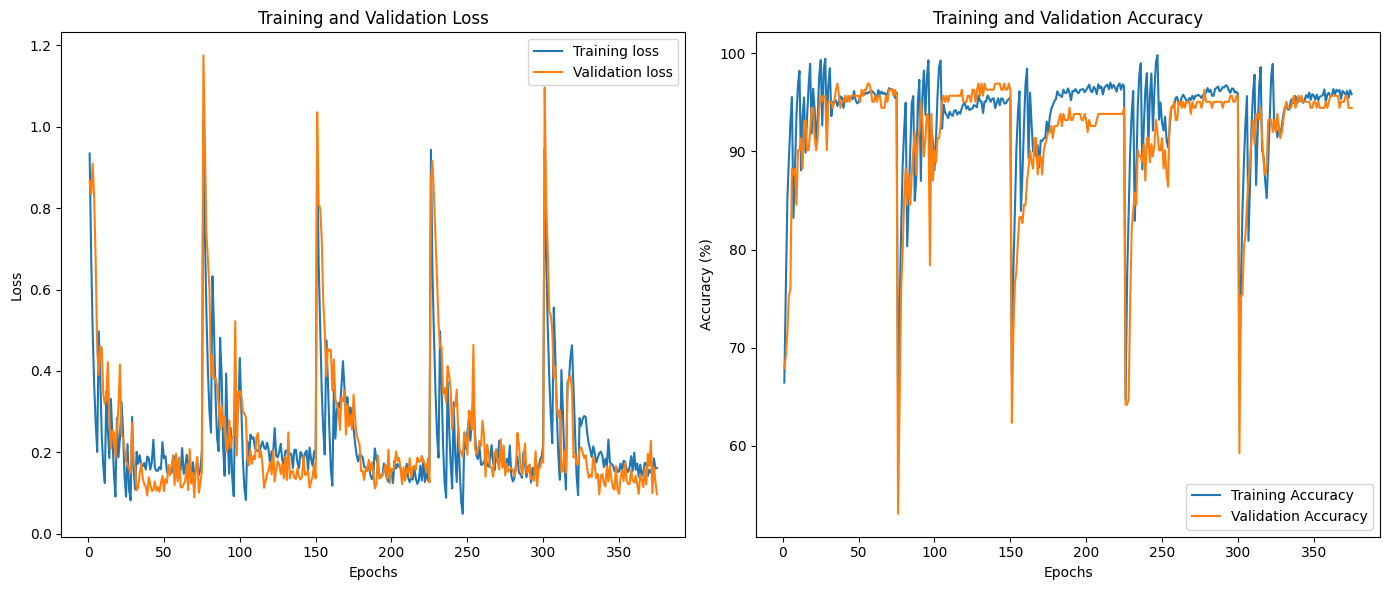

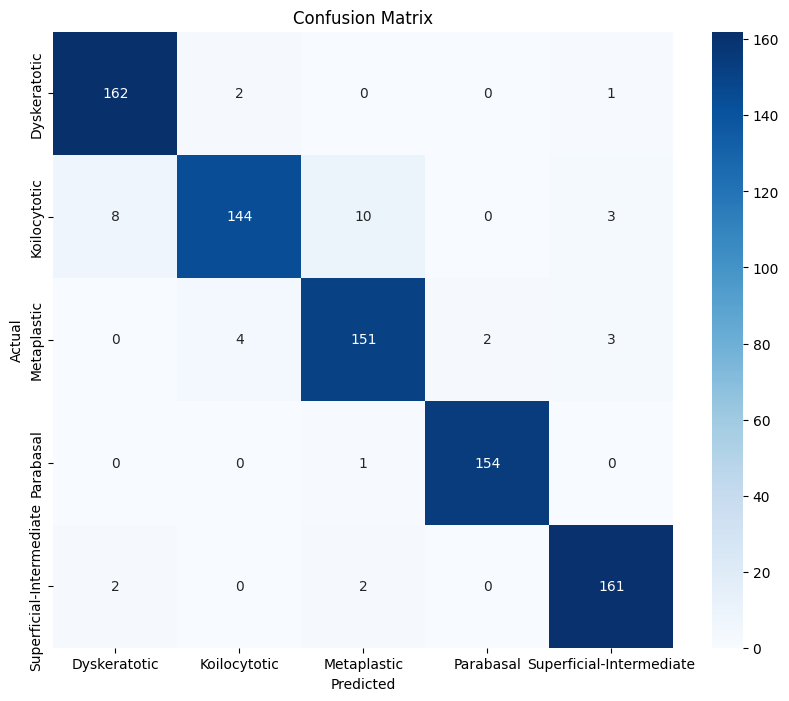

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os


def print_score(y_true, y_pred):
    print('------Weighted------')
    print('Weighted precision', precision_score(y_true, y_pred, average='weighted'))
    print('Weighted recall', recall_score(y_true, y_pred, average='weighted'))
    wf1 = f1_score(y_true, y_pred, average='weighted')
    print('Weighted f1-score', wf1)
    print('------Macro------')
    print('Macro precision', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall', recall_score(y_true, y_pred, average='macro'))
    maf1 = f1_score(y_true, y_pred, average='macro')
    print('Macro f1-score', maf1)
    return wf1, maf1


def is_image_file(filename):
    return filename.endswith('.bmp')


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 0.0, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with autocast():
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 0.0, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total


if __name__ == "__main__":
    dir = '/kaggle/input/sipakmed-dataset/SIPaKMeD dataset'
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(5).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            scheduler.step()
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)

        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Average Test Accuracy: 95.31%, Average Test Loss: 0.1412
Average Precision: 0.9554, Average Recall: 0.9535, Average F1-score: 0.9532


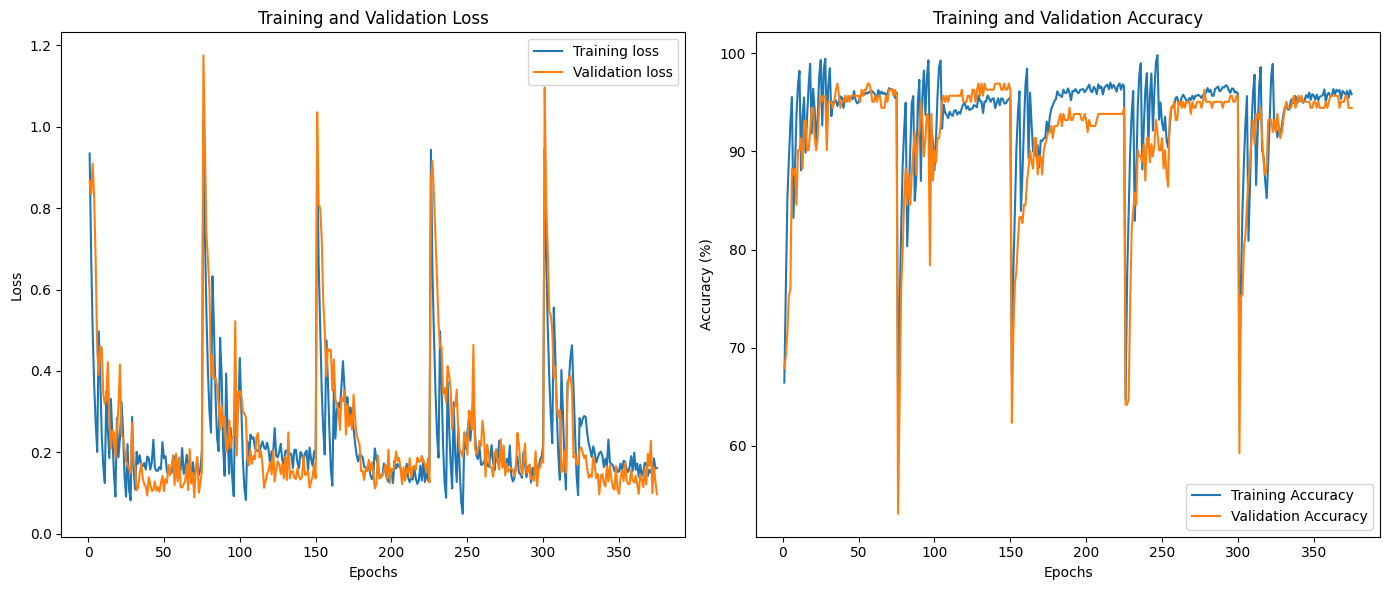

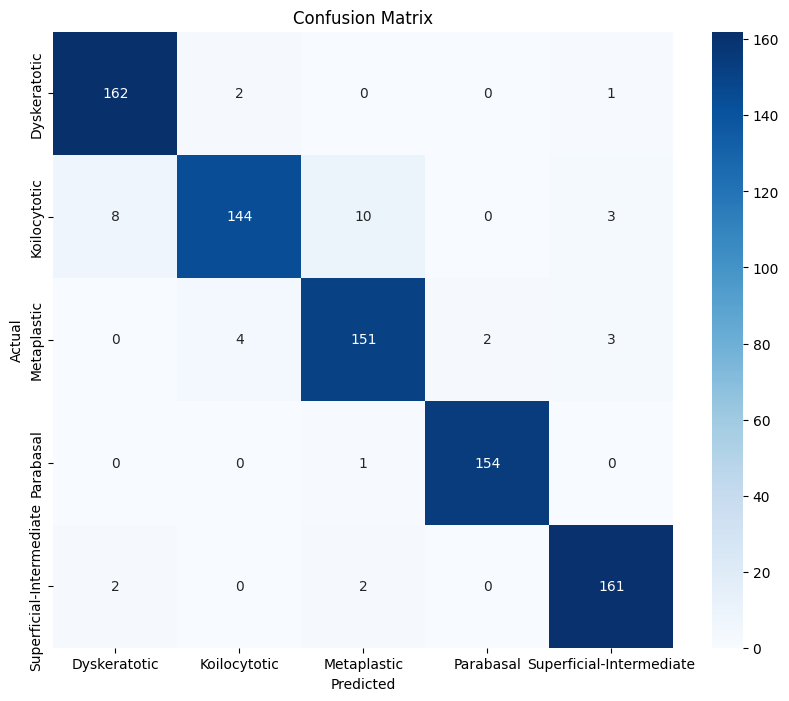

In [9]:

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
